In [2]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [3]:
#Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from fredapi import Fred
import requests
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Data Preprocessing

## Data Sources
In our research, we'll be using multiple sources of oil prices data for each of three regions that are discussed in the paper: United States, Russia and Middle East.
Data for US crude oil benchmark West Texas Intermediate (WTI) is coming from two main sources provided by the U.S. government. The first one is the Energy Information Administration (EIA), which gives us information about the crude oil prices, including prices for derived oil products such as gasoline, jet fuel, diesel, heating oil and propane. The second source is the Federal Reserve Economic Data, St. Louis (FRED), maintained by the Federal Reserve Bank of St. Louis. FRED provides economic time-series data.
The time-series is obtained through open data tools and Application Programming Interface (API).

Middle East region is represented by Dubai crude which is commonly used as benchmark for the pricing of Middle Eastern oil, consisting of Dubai, Oman or Abu Dhabi oil.

Russian oil is represented by Urals blend.

## Methodology

In order to analyze relations between oil and oil products we identified prices of crude oil and related oil products for three separate locations. Data was collected using RESTful API requests to query the government agencies sources such as EIA and IMF. In Python it's done with help of **requests** library allowing us to make the API calls with specified search parameters(time period, frequency, etc). 

In this study, we'll be focusing on the last five years, starting from October 2018 and going up to October 2023. We chose this time frame to assess how COVID-19, the Russia-Ukraine war, and Israel Hammas-Israel war affected petroleum prices. A five-year period provides a sufficiently large dataset for statistical analysis. This will allow us to perform the Exploratory Data Analysis(EDA) to draw meaningful conclusions about the relationships and correlations within the data. EDA is conducted using Python and popular data analysis libraries such as pandas, matplotlib, and seaborn. 

First, we imported oil prices into a Pandas DataFrame for easier work with tabular data. Next step was to organize data by combining all prices in one dataframe, naming columns and setting proper datatime index to manipulate the time-series. Subsequently, the data was inspected for missing values to ensure data quality. As a part of EDA to visualize the cleaned data, libraries  **matplotlib** and **seaborn** were used to illustrate how oil prices changed over time. The dataset contains prices for crude oil and petroleum products, to describe the relationships between them we conducted a correlation analysis by finding correlation coefficients and building correlation matrix. In our project we've plotted a heatmap to demonstrate how each oil product price correlates with others.

For further statistical analysis we calculated the daily returns on the prices and plotted the returns and the distribution of returns. Using returns instead of prices will make our series stationary, meaning that mean and variance does not change over time.

In addition to EDA we conducted Quantile-Quantile (Q-Q) analysis using **scipy** library to assess whether returns follow a particular theoretical distribution.

In next section we performed ARIMA modeling on crude oil prices to help us understand and predict how oil prices might change over time. By analyzing past prices relationships in different regions and influenced by geopolitical events, the model tries to identify trends and patterns that may repeat in the future. Predicting future prices is crucial for managing risks. We utilized Time Series Analysis module of the **statsmodels** Python package. To ensure the data stationarity we used Augmented Dickey-Fuller Test. Next step to set up the ARIMA model is to identify the optimal model parameters by building the autocorrelation function (ACF) and partial autocorrelation function (PACF) plots. We will be using **statsmodels.graphics.tsaplots** library, specifically the plot_acf and plot_pacf functions.

ARIMA models allowed us to run only univariate time series modeling. Since we evaluate multiple variables in our dataset, multivariate techniques must be used to describe the relationships.

Therefore we applied Principal Component Analysis (PCA) to identify the patterns in the data. Machine learning library **scikit-learn** provides methods that we used to implement the PCA on the oil price data.











In [4]:
# EIA API connection details
api_key = "WyIzc4qhpYE6rxEDvB216tCCuvSkHBwGLJ6ddpam"
eia_url = 'https://api.eia.gov/v2/petroleum/pri/spt/data/'

# List of oil products and codes
products = [
  {'name': 'WTI Crude', 'code':'RWTC'},
  {'name': 'Gasoline', 'code':'EER_EPMRU_PF4_Y35NY_DPG'},
  {'name': 'Jet Fuel', 'code':'EER_EPJK_PF4_RGC_DPG'},
  {'name': 'Diesel', 'code':'EER_EPD2DXL0_PF4_Y35NY_DPG'},
  {'name': 'Heating Oil', 'code':'EER_EPD2F_PF4_Y35NY_DPG'},
  {'name': 'Propane', 'code':'EER_EPLLPA_PF4_Y44MB_DPG'}
  ]

start_date = '2018-10-01'
end_date = '2023-10-01'
date_range = pd.date_range(start_date, end_date, freq='D').strftime('%Y-%m-%d')

oil_products_df = pd.DataFrame(date_range, columns=['period'])

for product in products: 
  # Query parameters 
  params = '?frequency=daily&data[0]=value&facets[series][]=%s&start=%s&end=%s&sort[0][column]=period&sort[0][direction]=desc&api_key=%s' % (product['code'], start_date, end_date, api_key)

  # Fetch the data using GET request
  data = requests.get(eia_url + params).json()
  df = pd.DataFrame(data['response']['data'])
  
  # Naming column with oil product name
  df.rename(columns={"value": product['name']}, inplace=True) 

  # Merging price series
  oil_products_df = pd.merge(oil_products_df, df[['period', product['name']]], on='period') 

In [5]:
# Setting proper index
oil_products_df['period'] = pd.to_datetime(df['period'])
oil_products_df.set_index('period', inplace=True)

# Convert oil products prices in $/gal to $/bbl multiplying by 42
# oil_products_df.iloc[:,1:6] = oil_products_df.iloc[:,1:6].multiply(42)

oil_products_df.head()

,WTI Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
period,,,,,,
2023-09-29,75.37,2.195,2.327,2.412,2.389,1.100
2023-09-28,75.16,2.204,2.317,2.397,2.372,1.075
2023-09-27,76.40,2.219,2.345,2.432,2.410,1.063
2023-09-26,74.44,2.189,2.312,2.399,2.379,1.035
2023-09-25,74.26,2.170,2.301,2.388,2.368,1.040


In [6]:
# Basic statistics of the dataset
oil_products_df.describe()

,WTI Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
count,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000
mean,66.325677,2.109614,2.142697,2.315250,2.212883,0.779687
std,20.828979,0.735616,0.851302,0.916478,0.877639,0.303088
min,-36.980000,0.434000,0.407000,0.602000,0.562000,0.203000
25%,53.307500,1.619750,1.700500,1.817750,1.747750,0.515000
50%,64.940000,2.049500,1.923000,2.066500,1.975500,0.719000
75%,79.570000,2.605500,2.627250,2.783750,2.617250,1.007000
max,123.640000,4.509000,5.066000,5.339000,5.152000,1.615000


In [7]:
# Check for missing values
oil_products_df.isna().value_counts()

WTI Crude  Gasoline  Jet Fuel  Diesel  Heating Oil  Propane
False      False     False     False   False        False      1256
dtype: int64

The dataset contains no NA values

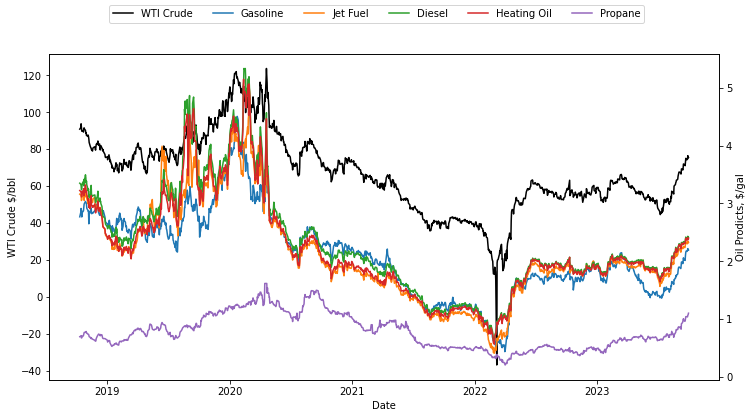

In [8]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the WTI Crude Oil prices on the left axis
ax1.set_xlabel('Date')
ax1.set_ylabel('WTI Crude $/bbl')

ax1.plot(oil_products_df.index, oil_products_df['WTI Crude'], color='k', label='WTI Crude')

# Plot the oil products prices on the right axis
ax2 = ax1.twinx()
ax2.set_ylabel('Oil Prodicts, $/gal')
for column in ['Gasoline', 'Jet Fuel', 'Diesel', 'Heating Oil', 'Propane']:
  ax2.plot(oil_products_df.index, oil_products_df[column], label=column)

# Adjust the legend and show the plot
fig.legend(loc='upper center', ncol=len(oil_products_df.columns))
plt.show()

<AxesSubplot:>

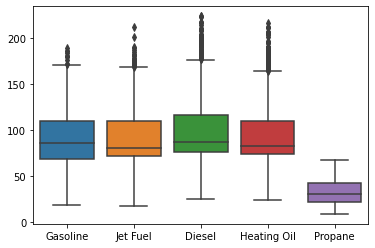

In [9]:
# Plotting blox plot to identify the outliers, oil products price was multipled by 42 to get comparable prices
sns.boxplot(data=oil_products_df.iloc[:,1:6].multiply(42))

In [10]:
# Estimating simple returns
wti_returns_df = oil_products_df.pct_change().dropna()
wti_returns_df.head()

,WTI Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
period,,,,,,
2023-09-28,-0.002786,0.004100,-0.004297,-0.006219,-0.007116,-0.022727
2023-09-27,0.016498,0.006806,0.012085,0.014602,0.016020,-0.011163
2023-09-26,-0.025654,-0.013520,-0.014072,-0.013569,-0.012863,-0.026341
2023-09-25,-0.002418,-0.008680,-0.004758,-0.004585,-0.004624,0.004831
2023-09-22,0.000135,0.002304,0.006084,0.001675,0.000845,0.000962


## Stationarity test

In [11]:
for product in wti_returns_df:
    print("\n", product)
    adf = adfuller(wti_returns_df[product])
    print("ADF Statistic: %f" % adf[0])
    print("p-value: %f" % adf[1])  
    


 WTI Crude
ADF Statistic: -11.077649
p-value: 0.000000

 Gasoline
ADF Statistic: -8.985153
p-value: 0.000000

 Jet Fuel
ADF Statistic: -16.921875
p-value: 0.000000

 Diesel
ADF Statistic: -14.358487
p-value: 0.000000

 Heating Oil
ADF Statistic: -25.449387
p-value: 0.000000

 Propane
ADF Statistic: -35.615987
p-value: 0.000000


Results of the tests show our data is stationary since p-values are extremely low.

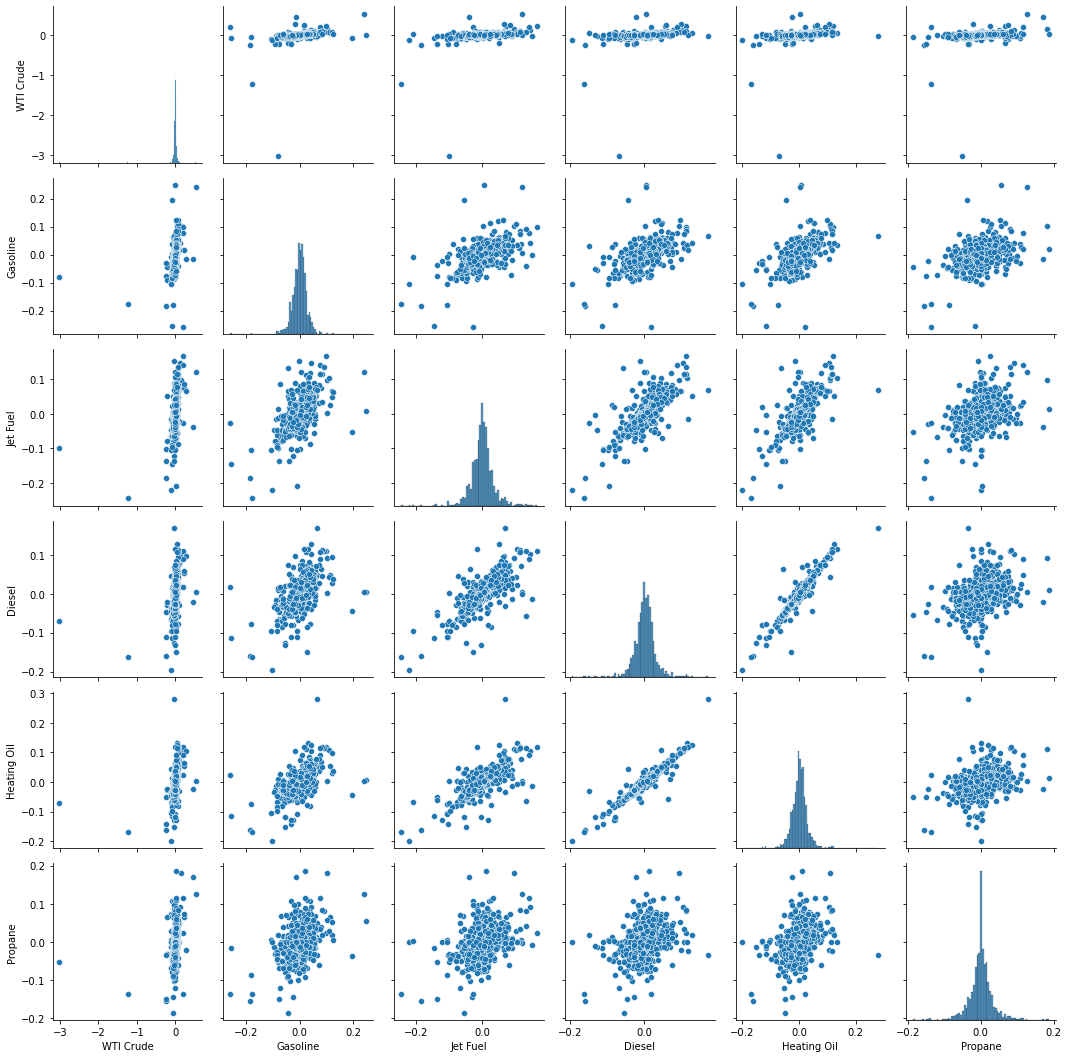

In [12]:
# Distribution of returns and scatterplots showing relationships between returns of various oil products
g = sns.PairGrid(wti_returns_df)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

## Key statistical metrics

In [13]:
# Creating empty DataFrame
stat_metrics = pd.DataFrame()

# Populating the dataframe with metrics
stat_metrics['Product'] = [item['name'] for item in products]
stat_metrics['Mean'] = wti_returns_df.mean().values
stat_metrics['Median'] = wti_returns_df.median().values
stat_metrics['Variance'] = wti_returns_df.var().values
stat_metrics['Skewness'] = stats.skew(wti_returns_df, axis=0, bias=True)
stat_metrics['Kurtosis'] = stats.kurtosis(wti_returns_df, axis=0, bias=True)

stat_metrics

,Product,Mean,Median,Variance,Skewness,Kurtosis
0,WTI Crude,-0.001947,0.001574,0.010033,-23.116553,674.445561
1,Gasoline,0.000711,0.001797,0.001037,-0.313281,15.046342
2,Jet Fuel,0.000847,0.001131,0.001187,-0.450418,7.278923
3,Diesel,0.000693,0.000962,0.000853,-0.366278,6.731837
4,Heating Oil,0.000725,0.000986,0.000969,0.111039,10.271881
5,Propane,0.000135,0.000000,0.001004,0.050325,5.755890


The distributions with a higher kurtosis have heavier tails.

In [14]:
wti_returns_df.cov()

,WTI Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
WTI Crude,0.010033,0.001036,0.001224,0.000931,0.000980,0.000790
Gasoline,0.001036,0.001037,0.000663,0.000564,0.000613,0.000422
Jet Fuel,0.001224,0.000663,0.001187,0.000809,0.000850,0.000432
Diesel,0.000931,0.000564,0.000809,0.000853,0.000867,0.000327
Heating Oil,0.000980,0.000613,0.000850,0.000867,0.000969,0.000345
Propane,0.000790,0.000422,0.000432,0.000327,0.000345,0.001004


In [15]:
# Calculate the correlation matrix
correlation_matrix = wti_returns_df.corr()
correlation_matrix.head()

,WTI Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
WTI Crude,1.000000,0.321283,0.354728,0.318105,0.314123,0.248803
Gasoline,0.321283,1.000000,0.597493,0.600196,0.611698,0.414015
Jet Fuel,0.354728,0.597493,1.000000,0.804222,0.791952,0.395736
Diesel,0.318105,0.600196,0.804222,1.000000,0.953792,0.353460
Heating Oil,0.314123,0.611698,0.791952,0.953792,1.000000,0.349304


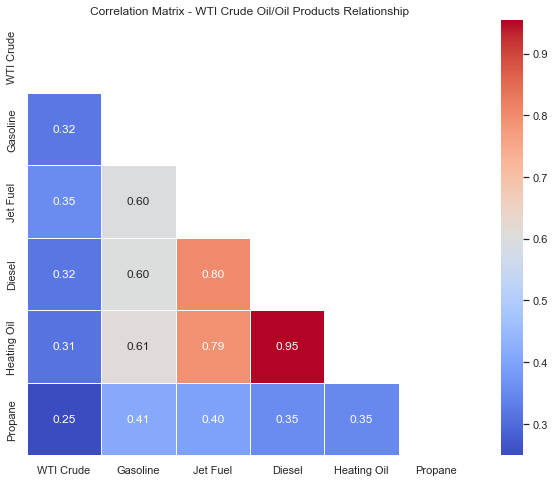

In [16]:
sns.set_theme(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the correlation matrix using Seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Show the plot
plt.title('Correlation Matrix - WTI Crude Oil/Oil Products Relationship')
plt.show()

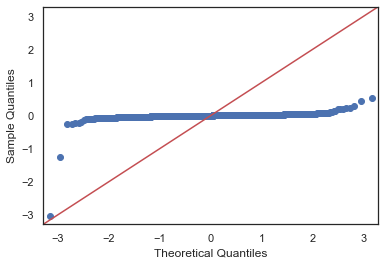

In [17]:
# Plot Q-Q plot
fig = sm.qqplot(wti_returns_df['WTI Crude'], line='45')
plt.show()

## Building ARIMA models

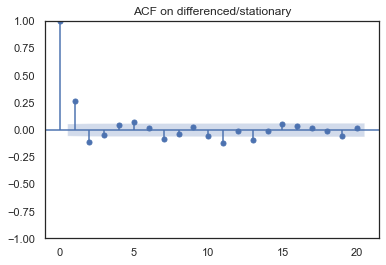

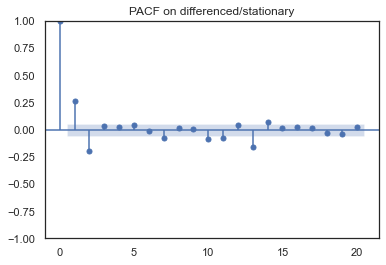

In [24]:
# Plotting ACF and PACF functions
plot_acf(wti_returns_df['WTI Crude'], lags=20,  title='ACF on differenced/stationary')
plot_pacf(wti_returns_df['WTI Crude'], lags=20,  method='ols', title='PACF on differenced/stationary')

plt.show()

ACF and PACF plots indicate that multiple autocorrelations are significantly non-zero. By analyzing the spikes on the graph we chose parameters for our models. As a result orders p=1 and q=1 were selected for ARIMA model since there are significant spikes at lags 1 on both plots.

In [27]:
model = ARIMA(wti_returns_df['WTI Crude'], order=(1,0,1))
model_fit = model.fit()
print(model_fit.summary())

c:\Users\timda\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\timda\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\timda\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\timda\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\timda\anaconda3\lib\site-

                               SARIMAX Results                                
Dep. Variable:              WTI Crude   No. Observations:                 1255
Model:                 ARIMA(1, 0, 1)   Log Likelihood                1172.301
Date:                Tue, 28 Nov 2023   AIC                          -2336.602
Time:                        10:34:13   BIC                          -2316.063
Sample:                             0   HQIC                         -2328.882
                               - 1255                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0020      0.008     -0.251      0.802      -0.017       0.013
ar.L1         -0.1553      0.025     -6.172      0.000      -0.205      -0.106
ma.L1          0.4813      0.020     23.679      0.0

## Principal Components Analysis

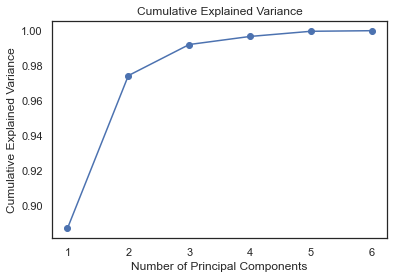

In [20]:
# Standardize the Data
scaler = StandardScaler()
data_standardized = scaler.fit_transform(oil_products_df)

# Apply PCA
pca = PCA()
principal_components = pca.fit_transform(data_standardized)

# Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [21]:
urals_df = pd.read_csv('data/urals_prices.csv', sep=';')
urals_df.head()

,09.11.2023,68.46
0,08.11.2023,68.41
1,07.11.2023,70.46
2,06.11.2023,74.04
3,03.11.2023,73.80
4,02.11.2023,74.46


<AxesSubplot:>

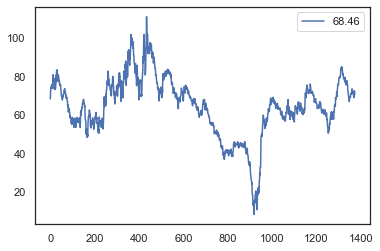

In [22]:
urals_df.plot()

## Dubai Crude prices in $ per barrel from International Monetary Fund API

In [23]:
# Obtaining Dubai Crude time-series from IMF using API query
url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/PCPS/M.W00.POILDUB.USD'
data = (requests.get(url).json()
        ['CompactData']['DataSet']['Series'])

# Preparing the data
data_list = [[obs.get('@TIME_PERIOD'), obs.get('@OBS_VALUE')]
             for obs in data['Obs']]

# Create dataframe from array of dates and values
dubai_crude_df = pd.DataFrame(data_list, columns=['Date', 'Dubai Crude'])

# Setting datetime index
dubai_crude_df['Date'] = pd.to_datetime(dubai_crude_df['Date'])
dubai_crude_df.set_index(['Date'], inplace=True)

# Leaving 2 decimal palces
dubai_crude_df['Dubai Crude'] = dubai_crude_df['Dubai Crude'].astype(float).round(2)

dubai_crude_df.head()

JSONDecodeError: [Errno Expecting value] <!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">

<html xmlns="http://www.w3.org/1999/xhtml"><head><meta http-equiv="Content-Type" content="text/html; charset=UTF-8">
	<title>Bandwidth Limit Exceeded for DataServices</title>
	<script async src="https://www.google-analytics.com/analytics.js"></script><script>
  (function(i,s,o,g,r,a,m){i['GoogleAnalyticsObject']=r;i[r]=i[r]||function(){
  (i[r].q=i[r].q||[]).push(arguments)},i[r].l=1*new Date();a=s.createElement(o),
  m=s.getElementsByTagName(o)[0];a.async=1;a.src=g;m.parentNode.insertBefore(a,m)
  })(window,document,'script','https://www.google-analytics.com/analytics.js','ga');

  ga('create', 'UA-49449241-1', 'auto');
  ga('send', 'pageview');

</script>
	<style>
		#header {
			float: left;
			text-transform: uppercase;
			width: 585px;
			padding: 0;
			text-align: left;
			color: #fff;
			line-height: 1.7em;
			height: 116px;
			margin-left: 60px;
		}

		#wrap {
			width: 1099px;
			max-width: 1099px;
			margin: 0 auto;
			background: url('data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABEsAAAB0CAMAAABKZUwiAAAAGXRFWHRTb2Z0d2FyZQBBZG9iZSBJbWFnZVJlYWR5ccllPAAAAyJpVFh0WE1MOmNvbS5hZG9iZS54bXAAAAAAADw/eHBhY2tldCBiZWdpbj0i77u/IiBpZD0iVzVNME1wQ2VoaUh6cmVTek5UY3prYzlkIj8+IDx4OnhtcG1ldGEgeG1sbnM6eD0iYWRvYmU6bnM6bWV0YS8iIHg6eG1wdGs9IkFkb2JlIFhNUCBDb3JlIDUuMy1jMDExIDY2LjE0NTY2MSwgMjAxMi8wMi8wNi0xNDo1NjoyNyAgICAgICAgIj4gPHJkZjpSREYgeG1sbnM6cmRmPSJodHRwOi8vd3d3LnczLm9yZy8xOTk5LzAyLzIyLXJkZi1zeW50YXgtbnMjIj4gPHJkZjpEZXNjcmlwdGlvbiByZGY6YWJvdXQ9IiIgeG1sbnM6eG1wPSJodHRwOi8vbnMuYWRvYmUuY29tL3hhcC8xLjAvIiB4bWxuczp4bXBNTT0iaHR0cDovL25zLmFkb2JlLmNvbS94YXAvMS4wL21tLyIgeG1sbnM6c3RSZWY9Imh0dHA6Ly9ucy5hZG9iZS5jb20veGFwLzEuMC9zVHlwZS9SZXNvdXJjZVJlZiMiIHhtcDpDcmVhdG9yVG9vbD0iQWRvYmUgUGhvdG9zaG9wIENTNiAoV2luZG93cykiIHhtcE1NOkluc3RhbmNlSUQ9InhtcC5paWQ6NzY1NUExQjEwNDIzMTFFMjhCODVGNDkxRTI4NDNEMTMiIHhtcE1NOkRvY3VtZW50SUQ9InhtcC5kaWQ6NzY1NUExQjIwNDIzMTFFMjhCODVGNDkxRTI4NDNEMTMiPiA8eG1wTU06RGVyaXZlZEZyb20gc3RSZWY6aW5zdGFuY2VJRD0ieG1wLmlpZDo3NjU1QTFBRjA0MjMxMUUyOEI4NUY0OTFFMjg0M0QxMyIgc3RSZWY6ZG9jdW1lbnRJRD0ieG1wLmRpZDo3NjU1QTFCMDA0MjMxMUUyOEI4NUY0OTFFMjg0M0QxMyIvPiA8L3JkZjpEZXNjcmlwdGlvbj4gPC9yZGY6UkRGPiA8L3g6eG1wbWV0YT4gPD94cGFja2V0IGVuZD0iciI/PiTnbekAAAFZUExURZC0zY+zzX6ivH+jvW+TrX6iu3GVrm2RqnGVr2yQqW2Rq26SrI+yzI2xynCUrY2xy3WZsn2hu4ywyXSYsXKWsI6yy4mtxnOXsYWpwoCkvYisxY+zzIKmwH+ivISowXaatIuvyYGlv4GlvnictYquyHmdtnWZs3qeuHyguY6yzH2hunebtWuPqW2SrG2RrIaqxHmdt32iu2uQqYWpw3ufuW+UrWyRqW6TrIOnwIOnwXCVrYmtx3GWsIerxIerxXKXsI2xyXSXsY2wyX+kvYuvyISnwYqux4qtx3aZs4GlvYmtxYGmv3mctXectYClvYaqw3uguXmet32guXqet3+jvIWpwYKnwISpwXGVsHmdtX2huXqfuHGVrXSZsoWqw3abtXaZtGyRqoesxWqOqXOXsHmctnSZsXqfuYKmv3qeuXaas26TrXWZtHSYsnCVrnaatW+TrHGWr3abtHWjv1EAALWhSURBVHja3L35V1vrkiyItkZLQiCEwEKAmEHiSKDDIDGZGQzYYAP2ubfmrlX9Xr331lur+///pTMi8/v2J+FTt6pXr77Hd6MJgW3A7FBkZGTkyMjfwJH4naf884mEXdzdiF7tEZ5L+E+q450i7/iBRDFRrNflibq8WywmEk15hs/inWox0ZQHdXnjUS9Wi8Vqs9isNseqY8XqWFWeqMpzY2Py/tioXPlgbFQOvRvjZXTibGLi4kIenI1OTIxenJ2NXsgTE3osLPC6Ig9vFq4WblZuV1aOVq5W5B53R7crUzdHU1NTt0dHR/dTdszcz8x8mLqfmZo5mfkwM3PyYebDhw8n8rb14eRka+v91s7J1tPJ1nscO3yT45tcvr2fn5fLNS7X/QM55g9mZ2f7D7M8Fh+WFh8Wl+4Wl5Yea49ylUvt8lKuyVot+V7+0Q//+q//eoJjfuvkpN8ql1vPrai/s7W1hStudna2/mlHjve8sS8gPH6b/23+/W/vfztYXf607I/Nzcbm8tL8gXxV1/jKZtc+1voH/fW18bW1tXE91sYr45UKHuG+Ujmflsv5aaUyfT49PT15ejo9fTo5OT2pRw4H744zfJzL5DI4lu/uHu8eV6drd3c1HJulvb1S8rEWHJf+7jKZlO+9lqwl7bi8vOSdf+KHx9zggzk5cB/xoT0/5x7re3yYXl1t4f0ybqP/nS/kC4U0PvC6vlco9OStkyoU8u1CQe5SqV4qJbepXq8nDwu8taOXKqVSpT25lvZKOA5xdyhvmUyJP4bMYUZ+IP4now+O5cIfnvwk5ScqP1D52Y78TR0xeNhDf++xJRFji37Y7hVoDD3krq53ifoIcWNE4CShwAJYKdarxbrgiMBGApjS5BNF4AieEwRpjjUFQcaqvBH0AHwUiSHyNlYdreIeaDKqNxejEwIiZ/LgTN4TUBE8mfDHgry7MHG1wENARdDk6urqhlgioHJ0c3t0dbQyNXVkIIIbYMgMcEVw5IOgycyHLcGQmZOTGbnf2nra4lmNY0tO42/hmTx/8G1+fv7bQX/++qDfx2W2v9ifvRY06QuSAEsWlwRJlhYFSeTsutMzTE4d/D4vbs38K5CLWJKO0uluS47yc6uVXiKQ/JOgyJYHEvmHdwaA5Lf46xBI+621urpqOPJ5c/lzo9FYmr++FnzrA+WWk/1+//vix7XxhoGJwEhlfA0gAiyZFiw5l4ugSWV6UqCEOHJ8fJo7nTw+PZ7MHR/r2XF8jDNlrcFzBkeldle7Kx9W5NvjN7dXSu2VogEoAXbWABe8ADYUQP5j3JCHlwocybngA3ORvTvnUMUgxD5pLn6wXMh32pnx6UK7Pb6xnRLIKBQ25oAkk21BkI7ACEBEIKWtdwAUYkrBY4g7BEjwjSmAKJyUUoYhOBRA9MawZBLgi+P0NKdAguP8bwhAEj/gI0SNEUMJg5ZE8KcULQxJRmL4MHqiMII7PFevk54QLgggZCZF8BTgSL3YbDZBQ6oCIwAZuZf3haNUmwIiReCLwIrhh0LIGDnJ2JjwkLEzARHhISAmckdCIvCBG6MlK4IjvAqKrCwIjFytCA25wbEiIHJ0AwSRW+LH1NEMj3u7CrScfPiwJdcPcjafyNvWiZzQT0/Ek/fGSPQMBi2R40AgRM7Za7ntCykREJkVYvLwsLh4BywRMHms4bp0x/NKTqbL6DUZRVFycUeA5IP8IycHUVlZiRzPG88bNSUlBmJGRnZCUrLjYYTcSI4NpSSNzwATEJMl5Up69OUr6/d3x/1RUT4yDgyR63RlehrAcioPTuUNvEReS48nj+XVddKu7mTZrNUUSHAqrZZbm5lSzoBjXV6xJzPbno8ojiRxURy5BAsJYeTyDYYkPVa4D3n24Z+OcHWgwnfkw5ECjbKU5FohD8qRF0Ap8CoPN/AnNvJAlUK70On0BFEEQ0hECCcpoIm8HwAKoUTAZI+AAkTJAEoOD/ntG5aQneRyjpgY8k7Kj03AZJokT29PR0b+1phJIn7gHxqeDFQ4xlaIHiMxH0kkBh4IA0korhAuBDbqgh7V+pjgR7NJdgIiUic3EcgAeOAJeU9ABWWOUJAqiAoqHoENPqEAIjhSHWVNA1oiF1ISYSNnCyxuFoyTuAoHlETKmRuBkRVgycqNUBIgye3N0dHU7e3U7ZRjJvcAFPASPUBKUHkIL/kgQHLCYgMn9NP7J17eD1ABkBIWOCAm17PXizxhBUv6AJDFWbkuAkzISZbs1OJJJb/7r68RjuQW0GSHUFJubbQIJxvPz4tPWtvIzT8ZkPzomA+PJKocAZLPgJPNzY+LwBD54oAkwpi+y9f270pKWN6Amlh1oziCOxwAkmPAiNzLiXDMCmdSzxFeM1+krommFUtKcjKNr/5zpkxa8jh+WBqv1aK4sqmhjgEZq9WG4eMy+Z+qbBQrDD3mFFkirWPwfjKobKzoIV1ZzguU5DsCI/l8ISsP2oXUMz+3BdQQcEm1SVXyAh/yQdY8qV7BQYgWPXsxK7HyZk/rnExpT6GkRBzJlYybHOdyMaSwLuRPsTKJkhE/3r+x+iYgHgPMxL2NuErG6pkAOkZ8XeOIiGLJSB3cow4wAagAUerQSwRWBDWaddVLmrhtEmWa9TGCB6CFcCLogiqnWQV+sMrhLfGEQAIkwTFBSnI26jHE4YncXi1MrKC8udK6Riqao5Ub3sh70Er0jaREeAgrnYFDaMIMzm8UNzsfKFu833oSauLP32/XiiRgJvPCSOYP5qW+ucbpCpXkATAyy+JGcKS2tHR3hxs5k+7kdVlOsij5KrwE13QUzaPEOSinu+VnwRKDko0vzxtfFq20cULJD9Bk/rcASQ7m52e3gSSfNxtS4QiYLCohOfhOVtLvz37/3m/FtKTCYxr3wrxJTE4plQBMBEiOT+U19fgYOHLszwxCSSldu7u72+XLcmnvsLQmiJFZI3C05CxbHdRJpMS55GPBDqBK7XdQY+53FZK5OVe8AEeEfMwZtMzxAKLgqQgIo0giD/4eOki73RbMaBNOOp1KpH+PYEmPKKLshMUNWUnKmAmoScoehuSEeCK0BAAqb8CRQ4LpYVDneCSRsvCYSAzN6ZxXYX3nfzMKScA0go8lBj7LYIMP6ibEjoSQMlIfecNM+HQ9QbkECispCtRXyCPyoFklhlRVKBFy0gRsjBUVT8BUxnAdpQ7rqho5IMSOnl2MUichnpxNqFByIdczLW0mLvQOnARqyRUYycKVVDdHK1cCJcJMpgRI5JD7W2UkU/f3gfB6zxKHmuvMCRTXD2AlT9RIdpxmYVgihETO4/ekJNezB+Al0EhmiSUHD7NLfULJ4tKdcJIaVNclO6kER0x2JClJl2fxb4GUtJ6BJGAmzxs8du/mD5bev49F17fHb4olATnpr0J1/bi82cCxSKmkr8d3iMJy0wCOCDmhQkKRZFoBxI7TCgQSJSOCJFLbsMoBMcmYGpDJAEruoow7Nmp3yRI1klWcaukB2ZX8o6aS61+iJFHIRFRK1TqGaGFAwY8pyoDYkaYQUMhV+FF5tiwIkm93hJnIAWGk3flH98/stkFSCCNtoIzADKGkh7qmVyiBoSiiOGKyp+RkTyUTlUsETPZyRsykxlM0UdGEP7FJU0tMMpl0pO9vtMZJOFhxrZtYERmJ0cNLKW/AQzkJZFb0alQ4KRJMiCaoYIogJCQjwBEoJFRb7dpsAkeqqGZQ1vAhxRITSsBBxkad5EpSYodASiy5Eka0vFlZMCy5QvtmSiqcq6kbQRDBk9sjJ7oqiICS6IUFDsob6CRs3jxZGwV8ZEdPaTIBYMm88JFrIMnBAdSSWSEk1wcHbNyAliwuzS4ZJVm6W5RbgZJLljjyey6ERA5hJdFr1F0UArR1kgQhETDZULHkC5Dki9x+2d2Y3XnbuAkLnAEsOZCvaQnFjSDJprx9nIVe8l2+wNnvfeVMcvusqit0ErZuhJicT0/KI2Hg1EnYuDkOejdxb8I6N4eZ7TvIyGD3OJNKz/LNlVIvtdqu0P/UclzdWI1jlV2AIJfJv6i7qsxqQCIQEakkQtIRqQIbuRJnDo/m+CH9aDJdEgjpAEwEUdqCFe18r+wKoWWBDilvUp2CP1Ja3hBRyFCIHwPSq3ISLXIOqcEeuiZO7tAjiSsD0cQ55g8yp0WOYsn59OnI31iR43o2iZiYJEKIcfKq007qYTfY1JNEUeudEevZsMDREqeulEQQpYrO8JhCjDKSOm6aQj9Y1lR5U4Q6wkbwaFGl1jFPTM4cmqhGMjFqqiseC6QsLHitxGHJFcBkQUjJDUnJkTyYurkJWjdTrh08MxNUOB942WIDx5o3iiRbVl/sAEvQCI6ZgLzqs3qYVVLSXxRG8mDlDVgJusBLOLWWao930WWSxY0jJQdbUkptLYKQsLghJ2ntAky+bOzurq/v7n7beUNLfpO3+d/wRbz/bX7wOLg+WN1sgJWsCS3ZxFf2HaWNURJ+nXcmlTix5LwizNuEkkm9AEUAJiAlVBBLSt2Vylf+vrwxvgFxpHJ4yHbG3q68M5nK/VsOpxplVyiuaN+g5aswUrv8sd46N1Tj+H6uFTdzTiKZU8xQzSSK9CO88iapyOLg5P8UQiKkowBSIuWNlDv5zKtpLsk/tQsdwRctc9q9dq/Q6fERG8MFU0p62sfZ29sjsAgnSWVKaAqnlJWUSijxSh5QXAeHEuyxIyZKTgSj0cnBj3f6Zyxk3jyXGLxPxF1gV/Q4NkI4KXp24rTYuCVcDAUUISaQXIk3dZVLoMBa2wbXBHo0aOAUq+gKV8lI6sSUMe0IsxtcVdV1zFlJxkaNoYxOnJmz5IxURa4TKHyUllwYmlwpJVmA2ioP0Ma5PVqRq1Q3N9a/QYFzA0QhfEB3/XCvOAJDiRQ5wkm2gCYncRvFTmc4Sua1jXNNjWT++pu89Pev56WmkRP1YZGsxJSSR7kKJ6k9PmoLA+0b0JFkjUhSjtJp8J8loSQbKG2AICxv5MHuLq6CJrvJHxQ487858TeAketrNoClLqotLkbLKHGWDwAfRDqgCW7kK5xd0y6w9m9ATfBqOXk+rRrhNH/7HRnJHXsjSc41bqJHwZE1NIB39+Q0wtmViS5r/429jtwqv1cQEe3/QiSpvWEhtWSomCZN5/Cli6kjih5W2UQKE1RF5ODz4C38aaKyAaZE7OTg03sobfJZVDByh9t2xnWHyh3UPqhwOnprWklPiYl1ceA4UV6i8ivBRGXXPXOWEE/CrnB4sDrEj3J6Wn+wBBL5if+sUPI7n5QYUE5iRPGqrOMfJsIGGqxykboWN64VTFdJ0WwlRWJLk7ylqA0cVDlVtZU0aUrTnrDWNU3tAmsrZ7TqGAkrnbMxZSTwpykhOSM3MRBhV1i9JFds31xNCJJcEU9WVHVdAZIc3Von+JZVzr1SEqqvykhOXCv4RIqbk5OnJ5ISXIJ+LPvA3+zcPThgYXMQkxL0bWBMY+sGQgnFEjnprIUhJ9VrJPVNlAYraZWj2etFKW/K3TIoiVw2CCe7ICVfdr+sC5SsbwxLJO/ntdAapCQHvFyz7KKlJLn5sbFOHBFCwi8RxAQeusXW+uq/EEUgtsJNMo02sPERK3COyUyOvfcq466Z3KZ8Q4+1yRa+tXE5rTJ7cnZ1a7XV3Nrql6QrbpR6XA40fy9/p6hxoKINGOUirtUbaaWjd3igYis/JaIK6yseoohCibyzvbY2PlmYhrUEtQ4qnUzEWig594/o3XTYw1HdpOeudKwVvEetxzcVTNgLBjvZ05Ywb9jF+QGSHLPCMTg5NcmEZrW/hT5OyEkSAYAkYh02EZY+Ca+lxOaRWCmpJ8KjnvC6idIRCijVRKKKJ9AIpl2tXqSLpA7dlTykCT7SRH2DS1N9rmNs45j2euZ6wQAPUhOBkYvRhQs1lqAhvHDhqpuFlRugyAJqGxpLhJcc3d6sAFGmBE+cUHJ/pM2bKVfZgI1ItSHFDZo47AajcSMFzs7T045vocx7R8m1qhPsjjggeZhlfbMEV4ke8voNiRJNjOSrExfT0Ws6SneFlnS75bLqrbxuAEu+kI4ILVlHgSM3rUEy4nQSfhkOTq71IvQIPSXYXAVOVj+utQ6+Qyz5TtnVHfgyH9YVRwRIXHEDTgJbmhDz0+OcK26sMwE5IGcmiklgSK32p1UUObsl0pLJclJ7vl4kuYxdrZeOhwxCyFxQ0nhVRD+gpcqcPdROcKSUI9LaRrvpKrfOkaNEylCUniTtL8BHUqh14DBpZ1OR/nu7AiSgJB2PJVRhyUtSjqK4Jg5kEr3h94pWDuXXvcOSuUukACx5FVoBZZJVjvxA0Q47VbnEi9uVnx5D3tCRRGCbT4x453ygww7dBeAxUg901hGthugtGXGQAuFELWrVhNlK6vUm275VdnG0XTOmTZxRawUXq+pMY1mDZ8+00rkAIQGInKlQYpZ58hEwkiuiCenIAinJlHATcBHBktuVm1uFEcDJrWklM/cmlEwRTj6AlfAOquvTDq7qEaOnZAf9X3lnnsIrVddreNP6dn5KjdOXU3QR9jSa01Di3FEsMdsnbNuvvEmny+moGyXL6XKLRlforS2tbb6sG5ookuA6HxY3fBv0lBDXeHdAk6vwku/9/sH35Y9rte+z37/PfncY4u7kC12qEEZolj9lGW9iK8RCtIBJSVxTwlc3PGdaapTfwPeWzOEMayRdAziJygbFjRU4JpHU/oKbJBpwxs+Zvqp93qQVMxHVVdVIKMUm03Na4xhXUYYy5z5hTvHnuaOspNCRu79jhVSGkb6NZrEATDvfKyicdNq9Qs8wpOBF172wIwyzmqqvh3sUTA5LMYzkQnKS0Z8hbk8haU/S9Ho++ZPwksRf+GDihzM4vm4JWzoxsDifyZBz3j1RLMaURL1qZCWcuUErWOocsBBhJVU0heXxmPaDi1RKqJOYk+TM/CSjzu/KRxcquSojEQQ5Y1XDDs4Cn4Fhnl75iRW5IY4s0C9PNnIjQDIleEIkmbqdMc2VDrV7Byfo3QBOoF7A0E6H69OWiSQ7zug6//7bNfnAwQFOXLkTLDlw/REoJbOz0FsBIzWyEuEll4+1R1Y4r0naSqLXqBx1u3IDTpJuPZc3tL6xPvCuh5L1lxehJetfdwebwECT37z4e21QcuCBxHeBt9cai6xrHJYQTBaBJHKdO2cj+Pz0WN3yeO2UX/YM0MREEoDJsWtylmKX6/odpBKzkESZUmrbO0kUM+luJR+pDQNI7CuLXP83MoqiFQ1VkTnr/0YOQeyBvsf2jZU79mGVSqJIP8DnWQPJ7QZbwoInHQGTBslPRigK5JNOO98hP9FucM9bTNDR6QV4Ql+JmkvYy8l42dWZX+XnkvO0ZJJXljjoqmsH59SRkj8aL0n8f/HpieHWTYglrjvsGYxv/9pM30CBQ7m1qPUNZdemgQnEVpvlYw8YykgdD4oQRmBwHQMTEZLCRnDThviIIu6B6q6QXBdAT4SZjKKqubiYCDxqV9YMvlq5usVFAOVo5eoIagmoSdAJ9t2bDzNqeLUxHHZntzDCh67N03vgiW/fsHWjveC4fTPf9yAihc3sonpcaSq5gzXt8vHx8jXJMwwNhNdXARIpceBvBY6kW61yOaAl6AF/2fjyZXf9C4QSHNvbLy8v6Xj45rf5N7zkGgdvYXO5ViyRyuv76/jyrFddVXS1rxYEanENc3xQA0+hDNr83rGztx6rPGIDJtAWD9nFkdfhQ6JI69+s7VtBP9hN3XBk0c0b4Ru/fIslA974ZNzzVSU1spYMfa1W0Bg6zEUxthi0WLGj1Qw12aR92H1OMmrns/lOtpPNCglJwXZSkqJHOElWxVflJCh3BDzarHIUSFKDIzl7WuCk4pbwngmvA4drok/qLM6piU+Ol5yf//R6yRArCdo4cYd3JHbIO1dJ3OpR0KiPjLih4JEYWOo6DlxvshfcTFjvl6ykXoWxBOprk/1gVjicDEa9MwbFBL0bPfDATK40z59VbTiYSHJxoeXNqB8JBj1hjbMipORKLlLk3K4s3IKW3Agvub25nVqB2kq59WjK3bj+zf0Mx4JP4Jk/gZH9hI3gpycb5XsCL/mmeAKXq2MCBxRe0SGBpwSAoqcna5vaYg3VDXWDu5paPeV3vCbXLl84ywomaQ8j9LmqQY20RDDkC7Fkd/Vl/evqy/aSh5L384HR9drVN8AR6q1wy6stTWqc7+sb+OK+B2iieMebaPKc9Q1c3cJKjvV33s3vWQc4N0DfjdPvZY5Pc6XU3rLix2RZJRIaW5Pe1Fr7fePIYOfXA4fSD9VXTSL1AknkjqQyjjnDCqtrYinF1zhaF5XlqUxHiUkBZOQ5KqfyBYquAh/QSjrOPA/ZtZ1i88b8rwokBe+iT3nZBGiiqmvJ/3wGBvqOHTmZ5ERTTEtg5/lbmO37IbAkEsF0cDjdF/AU55aPnSaxEFu0uWDr1+g4DpRWeOXrSlEAH1LiEFikyBlTfwm7OE2O8yl6jFq1460lY4oivFxoH/gsbgKb3qqGkpWVCVVKILxyLBia69SK1TfOWXJPf2sslnwwrQQtYCDJ04m8qei6E8zkzsdkgNVNH29ypgqWLC5ilu9BgeRhCbpr7VFOq0fn8ySW+LPhtdstt6S+0Uk+xRHAyO6XL6qUbDhOIsfL9tf11dXVlwObCLbK5rcBVqLdYFrl9esimHwPqcisS0AAmqBp/cxf7klr3NBQdQq/twsTyB2b4wqmznhwja/D2r+oUCIpr47PxTZ5rW1iaaT2o27N3ACgROpddbVNUuHB0Q0HD0mDDCe6Ru4DkfaJXW0TxSWRlknL61GUs75wFp2c4+lUx+QTqXDaBfOqtXtmpO/YtDB7OcGcsFdf9xA1cJhJZfboUytlPOCqryRmJrmc1TfH6nhFRXlemYZB8Oe1liTCR4nE4AROCCmJYKKPLnkPGUX7aNFjSB2Pi3TIq+l1xPrBdXOaNCGgmEACD301oS3hJjs31aoBimaVjI5Ze9j7Ss5GnbuElGR0AdXNBAsb016ptk5MrJhHjUN8sKcZJ+GVcuuRNm6UksSdYBY6FFwFRT582EF9gwLn6f3TznuoJV4q+faNaPJt/pvUEUQTdFoXHSeB/kBrGof4hJKgvkFDGKJBpMEc6AJDcgUtURghkBgdobVk94vzlLysK55sb29/5eW/w5T2/rfhLrCmpszb9F5fR28OZr9//w7D/EOMIf5qhVh0eqqmKc7u6SjwpPOShOkb4euumrPUmpY63LhMrjemU8t+gI9GEppKan9pVM8m9bSXo3BgxUkskRg5sWJFr2lfujisiWUU9zn+Ad/WtucESwRG6H4FigBA8nCXsCUsFEXeKJR0fF94QChR+XWP1AR9nMOSEhPwEvWrOZPaoRerjxVGWOIcH0+zJ8ymmU4qnFd+YhYyLJIM4MtI3L/xcQIjfip4JBjsiyUTYylAlqqZTIra06mqP40SieAH7hNAkSo4yRjrG5pciy5mwEuvozC9jgbSKzs4GL7h2wWsJEpLFtyVlIR2EtKTK7m70cGb21vEDAiQYCRYcYRQcq+ueaeUzFj00cnWjMAJ0wVQ3zztbAUGsW+AEhKCb6ht5q/7OH1nD4LOCOubR1pKHrUX/Oj1AxpK2BGOuoIjLaKI6wI7S8kuZBLzp5GQQHfdxsHb5Y1rISOKJb8NtnAgAV/Ll4Qi5zuJiSDJdzPiDvSBZx2SLC412LixViXdrblJx0XiYWD1hR9qeSO1DcfaUiWeTXu5nCBKbj1J7FCffDL5HzlJ5oZ8rlHsa51zJY/jEwYT2vzVCsfprx5GkjGAzDlUSbqOjgOUzPNcVGJHGOIrLLBtaLAF8JQOdNdexzWEFU8ESdrO8ZpyzpJgro8jwoe4mPM1rgNjbmLuElpe6fxDI+f8dHry3NyBPyuIJPzcbyIMOkokgs5NIjEyII6MhFM5xkP4Z+v1GFXqrugxC6w65nX+RsucupARmFybaOHQ6ApWMlpl/NGYxg5o+FGTnhJlJ/SXKJ5MjLouDtWRUbPNX3hmMgF7q0EJ8wVuVjjGt8Ku8M3R7S3m+QxI2A1GSMmUmUpY33zYYvNGPfMIKtkBLUGFM6/2NPZuYFDrgwQgWaAPg9qsNnD6fMmnm4SuEiElwJFHOixqr5fm0kxGr8JLummpbtIbLYsWEEIijGQXmqsQEe3ebGxodfNVypsXgZJP26sCJqvLu0NmeThceXdtDRy1pVFrjb1zMTMRNFlq/Y/d51Zrd7OifhJ/HLN7CXeamyXJeZeraiQsb3j+7NGydSin1XL60mUcJdn6/Uv5AZETV5M2gmczu2zzOnai1tV0SDgCkXWAiESxtcRjzoAqm9zOtsoNAonO95GU5Du9HvhJwTlMTDrpUXdVg4kKryxzSjbVR9Or5ZeUVHX1vpKS6wbj4hMH1D5P5qf9m0kUOOc/IZYkfmRRe+N4TbyxtI4MhZTUh0f6bHbYYtTYwimq+MqGTp1jfHWNQWKEWp06a1MTGG18jxhS1dlgny2gb8JHxs7OXCzj6NkFI9QIJGdElAV1qMEzP2EyycKV2UoouwJOjm6mrgRHBElWbtU6f+9crvfOoDbjO8EwziugEEo0wCweCaYkoQGMEDiBJIIfi33hI0gqWaJDTSubpcda8o5I8lpLvr7WIjRvyq/pslxf2cApdzF5U37m+A2QZFftaevqTkOJIyjy8iLFzcuq8JLV1U942xhUXQEi8y6dhF3g7xSC+94tH5tKFh8gkzxv1hYj1u3mnrJkkhwV1+PA35o7zGW8Ne1wT2N/BD3wwE6rvdSqDe0BSWJva20oMC0OFzHzmEYWKRmZ83azKKmjeUlX0yTn0r4VMxfSkSGMQV8snXwDN6qxRKl8JkPdFc3fbDbPIDXASR6hJjDEEk8glbR78ZSfy0HCrHAhtWcTwiX9xhVRaStRs9qhi1Y7jqeEtYlzrJxEDSYVMwae/3w1TuIHmJIYHhN2JUxx5K17xFtjNWFgJFBPFHfkD4F+jJh1HokkCQSqqedEG8TqUms2Ldi1rnN8lEz0xpU3mk8SlzkuqMQ7XtG/CXJKXJLaygS6wPCYEEqIIrdHkFyBKVOOk9zDS3I/NXM/FFSC4wPiGOlyfTp5es/y5klN8xy9+WYu04Nv1FwPaJnHZLCcoAQT9cs/osy5rEF5xSjKZfRaUxvVa5RMJyGSlGFzbZUjTWHUyRuEHu3utmBzVYlErtsvX1/Wv65/3RVGsrpKKFldXV5dPog9JdcKbY6P8IpZ5T7BJGAkDyAkD+wC77bkS41omkf5DsHkeBrGTItLi7HExoFLGdNZM5pImMGMG3k+X6kn6Zq5tPbv5bDYGuahWSM4Mue75geoKd7E0qEHkTOLzAW1zdywTjL0pDaG48ZxFP1ZrfPZvHno1bHWpkENs8M0rIGftKma9NSkZmpJT0udPWdYIx9LmWDEW2efd8klsYUeeZYaH0V5W43FCKs7Pz//qXhJ4i0LSQzjS+x5Hf7sOGpgJJEYjEEaqfssxhFX2DRpca3XlZW43m+iycJmTAAERQ5HbqrNBDvC+BDjSqi2aviR9m1cSrSFHY1O2KMxDAdfLFygGXzF8ubK6SUCJ5y9gXseAQMYvUFINOf4ACqIiJ66D2wl8VQwsgW2ZggmW8x13VEU0aCSJ5hL5hnD+O2A/jScvn2dv+Fk8APyBdwc39Li5RItXJAiH9VREsm5JUjSTcMzH5GRlGPZVXvAG+Yo2TUg0VvBEgGSF0CJ1DjLAJTl1vBEcFzdHHxngfOd5c3i8+ruUsxKwElgx93dQLNpl5kC8gvugjVyx36Iz9wkZCVM+ckc6mB9SQ3j9GuZZQv3mTSz0nQcOFn7S8M2zhSfNAOJTvxqAslcjCKhjDo3ABYBE3n7XDSXDsobe1zIYrYvK4QEnRwosMwzoXgC3VWVEmJKD7e0qwFLem1M5DhIKbnwEnPRlzTz1Yqbw6Bv7kRrEhIOWk8f+6iBc44+VdDM+RuIKkmESdGedYyMhNPArqoZiSPUGPQ6MmhRq2vXJuFKG4bOJ1DIcCCYCWqJMRrVmk0dD64yypV9HGoko0UNmqdhzemtzk8yZsRkQoobKCMXowtxVIldfaorWjhXzFCj8rpyq275lamZYARHGziBTnJygslghDEKIVFiApeaWuc5PUf3+jfaSfwJLAzggThixjSIJI8mlzzePT5CiLxDF/j1ki+tNWEk6Qgg0m3xJk0YMcu8jQQTQXatC/z1K/o3L46V6LG8vDiolgBFrq99H/igbwElG+ON1Y3ldNDBgfll8S5J1bV1fmqx8sw4OtXujRrTgjPCUXeUNsJHcPKkDveYUuh7G4XUYTcIk9dUgd+Hk420hQewBZzc/XM66Ryu0VuSMUg+QvSYewsmb4UUFWMbgJIsJ4TBQvLwuhby2bZCChhJh63gvE4JC3y0C2pUg24SZ72iiWNhr5hkDNo4pSHR1ajJcc5GI00rOWWErtY4HMz+meqZ4aZwYqjGCWb5EmEo40ginLwZGRzdKzrjfN2Ma/TLM0BNnfTQXI2Y1Isa5poYqyOlBK7XMVQ0TZY1trjCkgV0nI8TOdVRDyA603fGBDXorPC+mkqioa4IYURpg/g0qWfgKbmBv/X2aOXo6PaGrRsHJfcu01Un+u5hKLk/+aBFzgc6S05gKnlCQnQw+zLvEtQ47NK/7qvmeqCGdM2XZ4EDyXXJzJ9JdVsgpCQptfxrspx+bZGUtLoIhWYj2GULcBp4Q4XXbSlvXtbRA4bauq1Asow3HGU/wkfZ5uD7AfdVsBM862IF+ovR4uz3h9mlxcDX7+xpgn01t6SCuymOB1JJM7HgmmGUAHPDDksWS4jkjr3DvVRvz7kuepUfAchQzuJctFwW+NjslCOzy8N6mmlnp+esihkqWAZlj8HjRyCSfvNZ9sfLQJK83nS00nHaiRrqO0gwQbSJHxPuWVajfHftODJanSUpy1ODYKKZJZl4nYUvD9Xsd2ysBLYdxZMKzWoVzfyv/KRyyRA5CWEljhMYKn+8gz4UXutFgxAIr8UR50wboUBCQKlb8rzgiJQzdQapQYc1P5o2gJsWNFAchYV+1MZxxnxYSdX8aZrDiOkbbMC50N7NgmUewefqco9W/AzOFXZW3Mrb0Qo6wS5CbcaFqN3PTH24p2QChWRGEYTdmxOd5tvZegoizOhWv9aJXC6/mQcj6SPs6IHpAixwgCEgJVh+c2nT9q+1SwQLIBy6C6EkzeGbtI7xueEbx0qe2cQRRoIy50WBBFjylUDyaZUrbz4tf14+oM/1gC5Xf1yz3DpAKLTXW6W0Ke/K1wFfv1rT4mP3NMdYHuQJyG985th8VX7Bi7EShZLU4aHFJFMlAaK4E4wv2L9rJZlLuhZNN5XPp0qFUsv8qADYZ8oXA6XMEMX4ITwMg0k6JDOxNXbOPmnapBLIrnIjkNIBKWFqo1ygmSB5gIVOm9KrTy/hbF9vL7bQ7zk02dtTg8mhpr0e+jS1eKqPiZa+iKReor6SyqnRkspPx0uGQlwTAyuzvGckLH3Cto4PQKr7PVpQSuoatVasx0kDTbtn5pFO3jR1EQ6ghLM3UtxojUN3SZUxr6NjOorjtmiNjZnBVYMYBUBGzxAsQGfJhTnmJ3ymKwNLVlyu64q1gY9uYJr38dC6+4bXWCVhGCNqG8YdwVhywtQj87mqTEL3vHZMIJf05/W0ne3D6IpVWg9Ls9a9WbpDNPTdkq2+oXCgKyu65ddIdZJ0l74StG7KsKa1tHuz8WUdszemkggxeQGKrG9TI9leBpjY/qzPy8uzqGx0ii+e4AOKfLd8Eg8lDwIjkbz8JYU7AVEAJ0uKKUvJTbJvdXlPBgGMRBCO3kAkSUEJEFJCHIlLG/ZxPDUpvA4iyOXAPgqNOBpvsyFbWE/6Cd5oI5tqDSki4exe2gFE+veBZBhU0r4v7GSTPwNJGuuNDmXXgimwjEVizcOtWx2dxPHR0dRKwvyScKOFLrPQBHpGz6v2mgvrHC1wWD26CSd0cQgm2GNW+cl6wm9CBhKD8uvwJB+NI4k4ej5GmgBSEi5WYMSPBkMwIXUpFi1/kSED/p06gqHrY4kq65tq05LTNLSEOomLm3c5JWPWA0aNg/LmDGqJkBOhJlL3mOB6NeGCBm5ML+E48NHRDQLUqLve+tEb8hKdCb53TWDcb6HMOZmx3Xg2fKPN4HnKJNfavVE8oSoxf2DmNNpHZ52hZGlptsbsU6ytwDRw0rZVCJq8diG3dluttCVDc/UNg0q+aFbJC2XXrzCmye02zSTAEylwPn1y5Y2uz+przpEO8mll8/2AkivhxIeooF09+/DvH6cnNxcXt88rS56UoHm92OLcWcaNizh6PjCghtfdPbjEmfsDb5a8Mvf40syTbFpdL7tv+MhGN05/JjMpt9W73s7n0n7cZi5VcjgCueQHZGMIN9JvqpkhSXaOrtiwRmpAKqng6YovcyC5dhiM1GYEbL7gBFgIr51U2/nnVSvpub0W1gnXlRZoBx8Gm/qGU5AyusNC5xImB+ZwuDUEQbs/a4WT+EFDeGQoKs170kbepsuPJGJuYiVO3LVJaH4am7/mKeF6vipcJUWSkqZmljBjgEM4CirVauwqGXVmV8uGRtKA2V1dJ1huz3xgCfZ7CidBgtrVFYodtnDQB15AhaMNnKlYdXWprjqEA9f8zBaz5rG8QlNdn3ZsJd5OmBTierB9IAnmbrCVDyesvMrf+Y0VNXnxrz1ePl5qaAfbpBEm+brltNyky9q6eX7GIN8ux4FpmrdA1/UvcJRsfyUrWV/dNqHEkAS3n4Elq7TLQ20lkHzXZHl2gweijgTmIrRutoVQj1fWNmoOSeYaUHfWOQschqXJqRGorewEc+TEdXCYJea4Ce1byzoDzKQjhxtlLWvWx8t+mx5AZZPG9SwA5Vx98jjZ1/Ib3jgyNzeECh5KGD4353Bk0FUSQEyMPPy70xH+7n9BgbNGZ1wrAxZCRHM9YYqtHBNuuzKnoMHRHO1THOn1CJ17/O7ZDtfOuDaF2cQpHQbjwRldjZqhUqJyiUVxn3s0qYyDloz/RBiS+LF7fhhLEm+d87Ho6p4sum4wY12LXFqBBXxxJ0czBph8xP18xA0GMTa1pClW/X5PgkjV5aeNjcUpai5eYNSiXJk6r3HzNLleXMTVjcuIhlDCnjAbOLfwk9xyKPhoMCH63oqce92jpVPBgBEEN8Mx76LTdr699x0cHcO97suthsz349kWVDcWxMiwkjssC36Fbyt6tXUVyagMHEkrjmh+GjiJpR5BcmWc6xcdv9Hhm6/GSVR1NWKySVayuTuvE3wH5k3Dg+/9AZ3E9YH/Ho6SZ3Qh1xcdK1n658nJr60/6wQ8HfMZ9m88KQFDN63VxQ9qXEcwlmKv1S1nSzO5pLy2hx29kS6xWp1zfjQ5k0vovxayYAbZya4ZQKLdbKo8CCIeDd7qq8SMtLsNPx4TlrDaGW+/PH9G/6aDQirawOq+rI3kZJ2xBAZ6TPdhDRdDkDqaM2BpA/a97oV5SCUCimaWxBlIh86gpvlH1LOxVug4N62LLDj3hK1DKpVgfXPlZ9FYh6AkEXZrvFIyWODEKUhDXjXvLjEmYr55NafpAhyLY0RbBzoJd+FwFR+JSXGMez3Nm1Y1U4lN8bnsowBMMH5zYQQF+7R0J9+oyxdYUOn1its9IZJcmVJyQ9VVYcTC0+SdeyDK0ZHv39hivq0tzODsEEkwFPxkm3qZV2KZzGjdfONFNU6u+aSWKSfrUtjCodpaY05JxHQBQAly07rdLkTXtI7elDfYCH5mlCsSXa0JrHdfOXezuv0VtY01gSmWLBNLGpubn5OGJX1u9RIQOaBWMjsUmwakKwNLavLLGxmOyNu2LY/TUZE4mSSnKonLJlFDSaakC6XU4VraG9IOyoOSawOlgYDnOOuazcKy+V3BE6bzq3J+J8ut5eNC/s92vifL+fw/B33fIUQw0JCb9DCe/G5DJ35iDbBF7Mrn1j5vNwpmWNNIpE6bkAKlpOPH+mAwKbgNoJo4MDCIw+R5t7NPTcCHNtV36ODYxBL76ZqxhCOUp9hhduqQhKtE/qAwkvivRSP53s2A5yTEEVte4d4r2nt+5oZ9XwQN1EfqJo9UzWoiAEIrbB0QYgtx5BHW4TSRTUI8MYmE4gl3j1t9owosEo8uFEmgl0ArWYjX30zoIq0rARKGQ2tpc8NAV2wKVlYydXvkEgbunTvtg1nnZ9gCPmHwkS4d5yDf1vsttbp+ez+/g4FgjXOl5nrgxlv6S/R9LUHL1JlgXO64rkJfp+l0RfoiRFdkuiKlxOeUfFFOsmtDfEgpQW2jnIStYEdJpML5tLz8adNrJZubjaVrc7r2zezKieB+bJhfdJGzD9oBnqsF/Zul3UldwOc2eRovV4KO0DRuZnC0hDpjqVdSa4WGePgJ/EI3bgTL/TqrhONGRUAECJJrl+eSkctM7FrSouY7uzIlk62ko4BkzA1BAj8UQAmRpOzcJVoBKVUZmviLVgkjtJXk83+atD5wh51g1V81+xVsBJykwCEdLAel8Gqhry7ptWBrcSw0WtvCh0rcDgcio53rNdhiYR0c7ywBNRn/I/aEE/8Jd9rvx6nFSz69c82LrCOBfa1ugSUjFu1q3taiJroiVkDX8jXrhA6oJfKQ5jTdpMVqxzJKNKeEVpLRsaqrc+L9fJwMVsnkjA0c6K5W6NgOnCtX5lxZ82aBOz5vbhkzryPBPvPofirOhp7x4zdMiUZENBRXg5InbsDxSSW6JphRjHLKzvev3aTcA2XXJYUSQZJFXcd3eXcJUgKfazfN/Tf4hQcZ6TL2iIZ5+OaFl3xBQsmXdZY4NLgi7+jruumtHL8BM7HuzeYnByWNWSLJtW3hmz3ANPD3sLJxWa4KHg+6yVivtWT6q47BW3pgvDOLIzfUW/dsgO8wtaca4x5943HjBkcbL9/lmJO8rqXa3IqH+dtOg4G24+s636vr83xyYjKQRsez2e23Hd/uf9QFHipo0tr71WdNXkH4UZY4onhSAbTQYdLJGqSwh5NXXwm1knw+xewB3a+lA30Fv7EvpCalkmcmGb/00wFJxq8OPj6FVsIB7NNza+Bosm5FC5zKeOUnk14H046C+JJE4GCzAIGRMCuNG27c1puBfk4x7uj4Zo1mMzYRLl+3ab5iYowbLJgwAKcaM+ebxVE6T2w4mLM3mn406rFkwqAEU3wIYpwI9wVrfpqtHbdDOMoR5/lY4NxDL5m6mRrQXWcYMeDC5iG6YhE4+8DYPO628r13oa7fdOuMhqhqtBCaJQ+c5oOtZOnBRZUsuTbwIwdSajxnXpPpLl801TPPFVrPA5FHuPgC5+vL6otcnTtNWcmnZblsfgaWyN2mLuKbZbV1fc0+sG4b/R5IJai/Hh6IduwBP8TNm6XyZLhb/Nj50tyEKz3zmnKkMEKV5LBkU22OlWBfDM+4VNypSa5Su7SeSKdQarQEMlbnbMOEjdQM+lihkyxn861h5TRGhchTlnT0tvf7o36wJybn2fjI/30UtbJuIgdJjWAl6lLLc8ZP/fPqKbHMgRRXk/e0KWzDOJYYrcNI7G/pjIETmpx3ftKlHzFqYJIZMRUnuqLC4XYzOf5oeJH4L4DKUE3j/4Z6IkyQDpIGRsJuDooZp7Q21U7CXNe6iyqh/NpUo7xqr0wUQNS8remjs3XMGjgBPxlzYKLS69mFG+a7ODtj6tHCGVxqJrdOcOs428BXBiWUSpCgJnQkRJEjjARrhNqMzQZjhg+y6xbmbzCJA6+rzynx+z3VVsKdFQez1/MaoHatpytOVDZWtR+MBg56OK+QXbHYEyCCkWCh4+lWt7wBxfXZAhiZdKSRR4gqedFoAZjmUd9ohfNJna6r9JMIjgieNJSVYDWw6a59fkW2hO+7jxRgo3p2cfBQ0FtDIQ/Xw6RfCuyGSWxy3gkBvEkdWrjp0CGv22AgvY+Bl2QTIibyyTjRn80W8pnG9J91Jm85cK/ODbZh1rPZ4yHukZ4b0EvSJre+uQ540vBEa7qyKXeZCp7ZNt/8vlz35NllNasxc0B35HDAr8A0k7bbsuXUkgKTGjVWrSRoIojqTPRc2ydvGY1ndNYSVyfm4tAS4snp9DHEklOUOKAk46q9gpZU1sb/0CzkP8gaGPLSJ0L5dWRwKCcwzNcHUwdC/6t/15U3ZlATOKmrf77J57SFY/60og7hICqaLvpRN4JTdXmurszBSq2xM+3fjAachFIJfSXIYbxh0oCO82F+7zYIPILgen/v3WluZ4WWN1tPWyqW7LitfO9d2HxAS3TNd1/oiXZd9XR1K/lUKKlpTsndI0b4LmEt6cpViHq51ZWj3H32hhKbCmbAAEqc3d0vbpTv69ft1a/bFlKicILi5rOprsZKPjY2a66DQ5Oru8b+NK+TPAxiiVz/Ue1pbgKYkOKC5dH7xZnB0wTetD1jI3uDWIJZN8326G3HtOSlp+s1MWib1/BDOVn/RP25dZwM/GhzA9CxKzXIspNUh1q86XQgxxJT0kGZkw4+rh9It/ezq7vj+9kW/pGcFTnyhioqpXoJOEmnnbdstQKzozssy3qGJoyATek36MKQCuYp0Y446r6UDeHEHjUfppbTsYRjp5ZMnwYLcYyTKCv56/OSxH/mMxI/fibxg0y1xEBgY7jPYnCCD4BhvRy3Eydhqa51iz3iXZV++aZmRFM84USwJbpqYolvA48FrRt30DiPOEYuC9YpHL0nhuBOlVeKrle3K7caesQlOPCUxIN8U2p2jVUSGNOYLaChRyeQSp62kDVvpY3iyLcDgsmB1jdMY57VMX6OBC8ZJ/GaK8f4dNdlN8mY+XIkhU03TXeahUK3np/VLw868oVxrjbGt65dYOEiSCpRU8knKCVmKRFe8tnRkkbZlJLY4jrkKpkdYCVLTtaR69pxGMBohm+lJRRctclZUh6vpqzUQAy72rfowAA7aXksQW+1nRlf3t5eXst0XApifhzYsZzfHQwgCVhFOZvdnxwoboKCJaxzjJsEiOIJi/8z5UaGamuFLWBPSzJRRPMrddhsliM4lHagveKSyntaogEEbgdoymaEUz4EyQdG607yQwuLdoNMLiT3WPdYoHkjh/OpYclqxY3ijP8Ba5zfBZph33wisM+PBA98anTgLPGTfX4kOPa0YVi4WLQCJ6Frgpu6CAdIosPAaAULKwH5qBYxJoyrEJHRJu2udLuaR61q7Zsz2xl8xo7wBEdwRs1UsrCApvCVrR1niXODdjCMalBKrgREVm6Y6Yqx4Hj1zdFUuHL8Hp1gsBL1lqARzO032F3h+sAIdWVUybdv8ITNsoMjp6dcF/t9/2pPe9rd4tLd46Of5cMYn1Q2uImiV+itKpagEfy84WeCFUxcCOO2kpKvTIcWQPmEfIHV0Oe6TK2kYcfasiEJ5oG/f/8+KLuy/Jr1EQiDJc4L12ehuIl1EnNsMv/Ylzi64JLnzV7cFO0ZkgRG881y+vnz9HSuVGpspCMLXpybxORLm5TgfyIfMV9oxXkiQ6ixmn03nraGcDeQV0O+YTfltIcYR0kGfCb6YCObfQeTWpTZ1z5OCXWmG+/jRSNfC50sG8OdArZaSHVm8dHaCuZ2HJh84y1b9hNxzXLMGDCQweeWWAPnWEdxfAtHj1PLUsNl3B0/bdRAgC6JUIo1DSQObSzWE+G+8aIvdWyJVt1lRevyccBJk6gypquzGM/ItVpN5kI3LdwV+qvrBbN/M2rpR35Dn2LJGXePUyg5G11wpY12ca74hjG+Kw0quaWr5AYN4albxh9hpI858wIkM/duCw7yj7hL6wQb+SyLkUnztirYcZL389fO7Io8RmEk14wqWXQJ7ktoB9/dLT3WmOv6ePmoxs8aAgaQeYS1npEQEt17I/zk2ccLYPpmQ2NKds1Tsr3+9cUP8pGcmGN+9dMmtJKG4AiFV4WSj42aUpLv/aF0ed0W+DA0xLfkWdS/4NXSzcOr0/XQLeGj5YohHOahkEshtdfDo56vbXTNA6sAM2TgZf1PmxsuJY1x8nObHZ152e8U8tO76KBkG903PRkFjHT5OR2UNr56CZiJh5C0/ZG4CArJi7aJd3NCRnJ4JscKJ7Uq1Ch9aGPCWb+mnLIO1BKKJrYhh1BCr0lPkVPKuXAduXVxMga6hOBDHV/K+Z04x1pGHmtgiZQ4SJ9XRsL8o2lf4vwUvtfE73WB49QSyK0jwahfnBU9EueWKIBwvaemzCf8h+smkzCgpIkYNdhLhIRgc3BVt/Jxr5YOA3PBFiucUdcSHuPy8dGBmOgJrXFsKJiukvDQxeNqUtNWsDATbNG61Sg12EridVoAkCk3zXfvEqK3Zj7oVDA28qlO8t7vHbcFVjrTf8A2MPRNDZpna8TsaZwJtqXjj5eava7haYIkyTJWVWACB6qrtm9ISzALzNAjTTxiDiNzSjAW7BJKPjlO8llwBEDymWgibx8bmx8ba2ubs67E+T60qmJ4GHjRWXKhEH/JhUcMJAhAtmQBOT3YqjB1oBSIJLrdoZfqWZ+D3d98qZWMBrYBM2x1Oetm/F1jFu//3+PLn7YHG7vpEBQ8aqR9VziNVlh3QDcJjCbDMzu4O86+w7+2FkXb8m+uqqm2nCMlycZoYtREDScd4SS9lAolZCVWwRVMLbHsefdDOVTPq6344OBBLiQmLkiNUonL+WcLx/o4hiPja+NrP0GNkxi2kAz1fOJWjQ8gGEh7jbdWFOPAkoRfHFw0+ytv664pjD5wvd7UjeMcwQEXaTIyjWUNFdeitW+qbsnnmGvcjI3GkYxu9/iERR9dxI6SFbZwGC9whYhoTXWFR+2WnvkV1DVHWt1Y3Px9vP+G5Q0Dj7a4u4KmEgYM7HyzfjAZCTd8XjNfoH/dZ5v1wSwbPDHvuJLvEWgCPsJuhu7EpqOEWAJG0kq3dIav5Vd77tI3T8X164vmQmvWEYaCDUo+fVomgGx+bkiB0zBS8nFt7eNaY62xqkvG+2+A5GFAbg3LG/lCJ99uzqIx7TCDhoTmlx5q+mDKKSWlXirGEHk/bz3TXhv3nfyuDxVw62jwY5hWlVMbsMwyy2b3CSv7LdeISQ91gJ033sFJ2hCkmw4QRyAm3fWSSXqoa4xn1/EP7Wf3SxmWN9vIxNzMqwSbzQYpjR1dVE7x1YQS+V6RhtTWeq6nI0fQX4Gv+oPxjledLTh0IUj6k6VtntUNBvo0t24SmYzgJafnNhvs0OQPU+P8yIGW+MueWA1sDc0lQVLJyMBM8IguvxkZ6OqER71uS8dBSwxMKLaye1Ov67Lgqo4Du+FgG8XRZTi+uNHShkHRoxwOnsAczsWot6YtmN/VckpWtNLhpuCrm5upGybN3/iZYKok934xnwtQm5nRXGilJUZKnp781gpdFtwXIMEWTTRL5hkvoDWFlA/eUcLqBsM3tSXgyCuySpguEGH6JsJaz3ILzWAIrow8etaNFZYOrVrJNlnJi5Y22go2tfUz+sHAkUasuQqIjH8EngiY/DtlkiAXmq2bB6fmWFGjq9HtWDV3t0MR0PMczfKWv+giXDWgg05PviB70wUlV4CIbriTumDcBBJLkJ+zXNZoLW9TdDEv4d1+vjzoIEnHvnhPVJyPtWuIQ+yQR2WFGn0nHbpRYuaSjiqBr4QcJShufApSvCOnoMN9HV2KY1tx2Bjei2dymDlPkw2dwDrtqFEDh5m4faNiCdUSel6xBnGaXZxJjWU8V7er0ZKfRS95mzYQJLsG6JIIUkwwrad9GjxRt1TokQBhioOIMqJLPQkpiDzC7k+uqygyMK0O2bXJ1PniaFVZCaqaMVvUV/Wrx6tW2qAFrNZ53fF5MSHAorLrhFvPp8twrqS4ucFmvtubW1hKjqCXTN3c3LqdFTrNp6N897pwnLorLGqcv9lxjeAnL5XsaKgrTCWMG6KHgxsrDvpLD0s8XZcsYgBaiWAJmze1JOZvkgw9wutol4s9QUm0F6w4oqb59Wd2gRVJ6JxfRaQr9VbGlKB785mCCcQSQRDqJYIfgiVyK8xkfG1tvHE3aHRdXNQw14CQuDkhu51Taxr7NrncoWclkA4ZMG8dChdNAiNFjy2cnpxWhic9LraT4qZHLEmlDUu4wCY5F/m1NhslBg65uiJrMmj+X4asZ4oaZcdHfKljFMUoSDfyQombx+mGikk3bvZELVdT2b/Mh+1sJ+tCo/OW1cjdOECXQk/nhfOxV63XK/hhgXigz9GSTMZ4yQ+CBhDd4PKPjrkOB8mMXIhTscMhiZQ4az8FjgwFMb6Z1nHjv/XQW+JcJPUBn4mu7bOSJkGA0X5wnYHQHOxTvRUiq07wsf+LbjDdrdWqi3a1YeAx28vn9VaXNg8Y4fIbPpgIk10nJuLRYMZE33BhxdXKChZqIWv+VrOPbumZR37ajOcl8LjqON/JhxnqJCdb782gZrTkG6WS964TPA/b/CzVEiz31CLCv8qjGXx3V0u+PkZ3tcsIy28QxYg5vjLz07SD4xXXL192pdbB0psNM7q+IBbajd5sm+S6qv2bT3CTfPq82VCja2Nt8yORZA2kBFAiv4jRQ7BinIrrw5BMEnASwb2KSxY4HFjBh3LmkAlhGdtt6U2eTiNRENH2TR5pyhAtgSX5/zFnK7K0unG7wOd0so7m9fWNP2fyjplkM+m5oKoxMOnGOmu62/Vd3zLrGyt70oNmVyMnA4qtw5ZphQ+tqQRD3gW44mf71GLSBiHROKRC2wUOpBRH6Jxn42pPmRqXkJdsFEcncYIt5BnXwjk+1vnrSRuh5CLy6fNJGw2ugJvERc7PFtH4ppxJBEpssNEibu4MTgibCltk28biXJE1gDkcLvm0BLV6cayONTjgIU3uDmZayViVMzmWDm2qq1v4ORpHRZ/5pBKQk4szXc134TXXCd1XoYXODR5eYZrvlvFHMJaAnrDGmbm/H86ah9N1SzdXnGDm5uRkh5LJlmvgeDxh94ahR7a1iku0ltDAwZbgJZNJHu9qj8kl5M3rdJueCGWcGbb7htv4ys+GJXj7Qq88vWkvNhK8anGuEEmAI5+WBUKEmDRwu0nJtfHRCpyGAxKCSWU3ICXWA7Y41yWvud55LNmMnZm0fR8e5uKtwMpLSraxgXHrhZS2MvjGe4YXtiFRdtDJkRNwU3eJ65LfZLBwk4Cxm8pnd/UM3z0vZFN/3t3MlaOBXkwsjQSNGwWTrkcR69V0gTnpdOBaSw/a6a3OSb9knTjjjo62grO+wNEkFSQNwF9XsFxG+wbVh9fWLcKlIETuMKUZr6xuSn6TYc4vI2cKt2Ml2gc+P5+unHKg79zZSn5eLPmBXS0RokjYvhlo5rjUkpG4DeyUWJ3tQxsYwYxcHAxYUatrsYmMVzKTIpwlvKVW0nSBrtV4AMcFM16cOYfaBNKPdAvOhWclmu1KTIHXVTs4UEtusbpCrjGQxB4137yxRMYPmutqzeAnph5t+fpGF3waLUGu+/yBLZhZ6i+qbeNBX+51RfCSLvfEKB+WBfPXupsUNGmRkzxrTAklV009+vJlY915SrS6eTGbq3ZwljES/Ek5CenIpmHJmhY34CREEXfU/JThm96NYUlMoxrOl+aU10M3orZ3qPuz8OrLk8aaoE567GllQ+oPB0anrYbzfGecS/fmdNONJS3OzQXBRo3n0B2SHsgRiIuZdMA+nNCa1qqn7PRYp606INIaJ+3BJRwlblEn2Y9dr04ENkRxHZxOR51qNh8MwQTt4J7lRyuIFJSgqYLkxwvMJcwqMefGrM3yCvEVlCQXeEush2NoUoml17U/kBISGOJ/RypJBKM3SkjiXnAikQhpScBH4vBFm8Cps9JRAGHQALUT85lob6fIkJIqowcAG/S/usU3OpjDLvCoq280WyDmJrp8HG9W4Jzpes8zV+WsaHHDBZ/gJHCoSV0DQMFQ8K2LPgqyGA1MwEqUlKjbdcvvCd7xhtd5XRX8HlvHbRL3uq8Ttzbeou0QOUGJJtzAzVk+tHBeWdaXW1FLTSUUSrR301IwWd/wS7QglbwwX+DT121bWLGsA8HLqwolnxvx8VGYybiHEldvVzaVk3hLydLSQARjUN+ghRNPspY4xJcjRU/5vgQGTvasvtnzs7GmupoPtNehC4M7qjoV3bpn5vi5obzEN5nP6cAGb/wj/Xe7rbLDCteeceVL1+kl5bjv4/lMOnathYEEkQkmXnr1XlcTTqSmUWQpaKUj4MhhRERG91yKSTtIVtCG1p5KJSmuBuLSsZLbiJNzXZxJCxqwuAG2gk850cekaI4IG5CsqVry18eS/5c9nqCq8bxkZGRwKjh+b2SwXxMHlqCgMXjhFgtkHtHkiiw1PEJPuGiIUrVJPpVIBEOKsXt+9MwlRZtUggVauIFPbQIZrxfcsqWUZGHB3a1w8zjz025vKLrCUHKrvvlbn8UYDuAgqmQGGys+zGy5Hg79JFta3HxzYILq5hv3RNDqetB/kBIHDrX4Bf6OUfOKJZevXMcNV0myTGNJ9MqdfMiFRsi87RvXGifYoaW9YEiuuvsGw8BUWz9zjG/5sxQ4GAym3PpxbVOYyUeUN1bdsA0A41N5EXmuwyN8sejqYmiX0lwunvPrxZl0pLkCmRRISYqnS0ltFNb+1dUOrHVgJtFxlby+yftgJXPhoj3DkOTv5ATEiSNpVityv/kum820nCCSdiyl7GhKWT5TLmV9mvhR9q2cqByM7AThSPC95sMix7emrchRpcTU144hiR/nGxwZSKVcZomPZtSQ10Of0KCMxNIuY7MrvPPQSbCmT6OiLWbA93Dwf/nxj+Ec+QuFTNCxSYRibCKGlEToKwm8JXW3eLxubtcRnbyxNx0JRrqreUs4v6dRA9rFqY9BI6kqGfEbtdC4sWjXUbeeb+zCZ6hdmGBC8XVBK5yFeKOWTuBAJLFBPt7SMn+7EuRD37vI+cA6z+2eJ9RfETDAfIGtnffvw0zX9+85ETyvgSWIUoVFra8xjFxSpQ2cu8fFx8c7W1mBEDUNYgTLx7IKSiXPLfSCWxy+0XUV61reEE9eVHJ1e28+rW5/spx5jyYNq25ISmgrWTMs8ewYFXhDvqpoMahxnOBa2x5HOiAcmJvAkmQYCV3C0hv2NHX2JlNyWitW3vTcqdTT2NNCr836ptehiNDptLnfLv/f2AZ2yzqTP9o+MffDNAAvkICXbP6vd9kNfbfsMGKg8dt1dCZKl2Nq0u3GtjaTaON/Y1lLHHISCyzJBu3grF+Mw/qGo81KR7QrnPJxryW3W4vFH2eDDzUi6tDvI7Mme7CDHH7XU64emqZLbdKQZFqV17gdTDj5IwchJX4nB2lo9CaYCK6HSdEjQyPCAya1hC3BSXCrVrWOBEZkD8Aur1uD601NG6jCDTtmoQI6ezMqdQ934FRdVInbhCM4Mupl1wlM9AmUCJKcOaXEeedXrtQ5jy2ftys3V+jjrOim4Nsg9Ggq2O6pSsmJdYJJStgLZqzr1ns1uzKIUceCsbTiWldFQCs5eLDlnks+Pk0jork/9xJd4EvaStKvlF5Vdm2ZVKLeNE7zxTZXaK8vL6tcerPqk9M++Zx5+tI+f14eVzD5uPaxobXN2lrocarwt/PuIRy5cV/nZeM0WJ+1DlPdpoam0e99qFrJoTY5OWSy5z3y1gQucBKYKzF5hkFtZeJHRwfjqJXYXgp3SQ7ktjqVZC4dOtOcmurvupvv/q+yERWqJV0nnKSpo7Cx03XDORBQ3N/SJUeJHSi+m5PKZvf3w+Imn/V6CZZ/dph71LEgJCAJYTJlOy06KR99VHI7cVj7HQZ5DMLnctzbnvGLl3MusmTyNAfTPDyv05alNl0J+sFGTvh/2vjpIqMTQ+EkvpipByQlTDgZAJURZyup696KQIhlM8eKmqYuCMb8Xr2oUdFxqusYd/RZB8dJJWfIGZgYcKmNji6M2vYb2Eq4UesCa8cXJkwquVJWcqMzOFBLpmzxuN+n5RmJOl6RefRkMgn6NztPT5bGuONJyTzBpD9va/lmZ68PdPZG92YuPVixUFvivoo7bNNCeQN32mtSB884fcPLs27RejZSsqGE5CsW8u1+RVCJnwqm1XV5OUaSzwomxkk214yThLTEErlw/P3s7MPdYhCbBihJW0vSxRhfwg3zv2NSgty0PVf+UyUppSzJtecWwsBfgSNlUyptDq/Aa469me38OFcR6v69GELmfridk5oHz35gwIbPJEGVAqPqfm5trbGbDtmIwkzMVQKrvQcibfYMB7+mo0Zc2mgv2Ptds+zd6KgQV1pAedWBvo5zqaXoeu2xfeU2kdtssI3igM8dat5LuO0z5+3zcpzD9Irg+fNTRs9XLOM1dpYomHz8+IdURhK/Q1MSA875IE0gkQi4Sp1+2EGZJFRMVI5lzVPX4WAqJcw/ajKohPUNdBJcuZlPc+a5LtgRFDfM5/TWMRdZAq1E6h10b4SlTCxcXJz5Do6501jerGgHB+tw4He9mVo5up26vb25Pbqfss3jDkyYx3gvjAQwInCygzYwOcnW1vunp/d+mg9jwcwX+PYt3l01S6HkwfdEWD/cIaoEYIKdua9+/Q1GRhDoGnWfwUmYxMiNFZZUAsv8BpdWYPvNC4QSQ5JP3k+y6jKP1JwGQoLyRrCkMd4YNyjh1XcDoOdtx1Z5b5cv2+KsYxu72cZXfpnjJJpmCsSV/16YLl/o9dx5RMIvb20muObtdGMOGQwZ47Z4b25ocy+3gQ/rJemBB9MtqqyRgYv86F7237375V3nRQudshISchFvMImcGa3skSX0voY11O6+86nZrbfPd9q2l1x3bqFeY8AApWTd90kfTY+r+jRuwLb0lfZijVrXax0Gq4NNKWHyJaN0YVM7nZTS5pQTfecKJNN8FZDLmv5/0nj4B5vX+4+F10QYzpgI1NaRYCtfnBydCPbleFkWPd+66+5wBod9G80r0Zk+mkqwU4uBJWNu16cLF9AwRq7CqY4O4AhVkjOAyOiFHBY0f2HVzYI7sOnTRc2vwJ92RJvr0crRoFZyr2N8aOF8UOc8LWpbH1R0ZSeYlGQnzj0SIPl27dZqHvQRfoikkgcVSZzji6vHdY1WMnknYAJGghhGTsKXu92WO54ReSRFzi5N86xsNPHoK/Kht5FW4kIYP61qTImmlLCq2dw0Q0mDv2/wuQqGfByobioVw5LpL9jmaV0bu0kPpsvnJmtLd3eP/3hoJjWfmqZ5HD2zlTi9sdDRbJK2jstCJ+moTgJews1U+TYSBNTpGiDJ8ApxV3p4Ryuv622ChWqo1D26L+94VAQ+4MiJlJPEtU45UhnW/qpy2BJKpweDTMr5QHPNZp3UqnjS8e8yUY2pjB0bEG4bM9H9yKm40NGoW64PzigeZzwlyQ2JJdyAeMxOMEaDz60b7ByvLphxXKFEytfGH7a0edsnHgCVRCzMukKmPhImzQchat4sD19s0esmYCK6NlgKHMqvbrMWO8LFMe3faDhjs2loMmrOEiSUjMWLtXw+NAKizxgOfcHlFdwYPHHhnSUTK/HGYLCSK4AIZvmmbFdw7Cth3LxGuzKrxMAEqz4xyqdrxwVHpMaZ9xnRdJTM67oK8JLZA0GR/qxLJrvT/iq6N9w7fpm8pD8tAith6FG6hZfSlsVDm2l+1yb5rH+zi1xoqW9e/Do+DvIRSeBLayyb4mqqKwFFq5uP42Ft473YmPI4jxYXo8ZSYClBpqsPTqNGuIovOpfB7j1oJUrYnSBge29oq0ilen72Bh5X9G7ahSwzgyxqGYJDPrseJbVfM/fDxeFhOHzgfdfuS6HRLSsilF1B86X97t2v+Xwq9S7767t3vX/eKDuZxGCoa9pr17EZ704ZioEtl7LZ2DvvdZKsM5d03FJyHezLE0sKKgul2jbG2PbAyv0Ve4cWXGI2tdii5kyvx87zanuDp6eP1ahWsbjoaY1kDETXcfUw/wxzwoNW+kGPSSIMPxqQYUPXfBE6yUjCbCQKJnVNhVZEaQobYY+4mmgKrNQJIPVq05CEw3xcq6Vpah5APCXxBvozbAtG6tHZGRmK87o6WnI1oeu0kHsklETzSmBQg1eN8UdTqHBsndaUj5qn7MoWDuNKTjTW9SlgJFympV7Xay4d72OYb/ZAaAltG9hbAXMaYuaBJWAlj5c1nQl2L8Dya/9qiusG5JLyBnbxtbiw4su6xqfp6pt1BRLNTlt2Fc7AvgpVSjYdjmhlA5nO+DHQRF7wxs/PsRpBKvI1AZEvlZpvBC9KjRNsoeTWm9VactkMr+pMg2eePYqSKYw9p5XwUuj4JVRcI9OxFqq8sqNOyJQjNxQ894OWzeBiG4cqc2aOTy//Hy19uhtLJN2N3XJ3/V1W2Mmvv7yTmmc7jc3LsTEtHfd+gERdZ3zthiVPFG2ksvuuG7w/wE+yLmqAVKWTRVq0Bker+U5rOrRwVIAO0URTGXWx1uEelysfHsbuefpdYZxHdXNqkSVqUZueDpbhhEAi/6esYBt/FInkB88kfif3NV6wFUfRJ4Z9JJYgPTAS7LxoWIJDtzx3WHBCmEmuTeYNaCOYG/o4GszsoyZ3fQIzkFnSjIMGrLZRg8kEI9Rgm8ey4DPndb2I2zcTpCMaFK1J0TeWMcBe8K01cWYYo4alWh+mAjSZMXva1g6X4OjaYGsHczef1De63hO++QfuruoDTR5c/+ZOXRqPtaXapQWVXCYZD911rkwzp5W5R4vetC+a5WrVDcxp24gWQHoaU9Pc5A2cJZ8+w1OyvGliiTnm6XbFL15lzWiJCq5afYM587XvdFe+yv85Hphcaz7DmC+e24J625OMAYNZM8V14xiid3GuKfN4umV1elbhrs2UEotbljPO6oPV0E/yFk6UhnQDS1qQWiTEJDvuUMGy0syb1m1l9oWW7L/L/pIJesRhD7kbaK/xLGDaFodsjHsEeeflV67ty/p+sF8nDJNah7FO6i4hI+ulmKWwZ9YS5reU1Hljzvlw17IlMx7n4qToY7IS6wajg8N+cEhK1pSUNHD7sbH5V48m+UtZA4kBiSXYSW4K60icwei9r4PEJE6JHinS3lqHm4T6q+bN2/5xveeWz7F6k6s+i25LcDUIKrEAJB8y4DZ90lLCVo52b7AN58y3gZ1gwkXBGA3mMq0VTt/cCp7ojs8p753nLJ9KJsCRLSSonWzNxF7XLUSV7AyorrSTvEeRQ8XVQlQXF93MHFjJkmao1XQz32UEf5q8NidfnVBYdnu0tBWM4RvtBDOLkZb5bSzAoaPE7Rs3RwnyFwVJGp/NV/JRna7IKdHCOgASVjj49bRXPfzOnj4vLu5ObgfmtE0HJriZw7aNu9qqiSQa5brn0klwxyYwOxgsb/I+MY2LY9rqM+eCKlMxG9xQkZybi364pNMFKkYWqhgHoiksNN6Vu37SxkNEV5hI7t2vwk1+3c+3sAiEPrXIybD4nNb4Hl31ajVxqIKZhb/7lCGKOFayr3hiFU5Hy5y2kpMOk16z7bzLGfCHZbUMjQenDnW6YE83tfvypuTGg4+Vm7guDlvBSGScPPflaOUNmKzpS8Yf0uQ6GCgfyquxjz4RBrsGa8iD0mYkXs3HNDUuDS7q4oqmzvMVvfjKbOiEFDIwv9bZyBmrUjbR7cFAj+aotoGrY76m0Ys1gSeovU5YNvSZMhKTSq4W4tx5MBJkqF3dMpWRasmN7wTrIJ/yEV2C88EWj5/sfHhi2PwTlVdzvNpo8PyBrgtmwMD8dT+OZH4YiBFC60YNaqAlkYBJxKIfumBLXlKNl2xoQjTH+DDJx9pmQ8dvbF2FBkNvaxNYlwQDRJAM7eubj1BI+NK15nuI+FWcNsVVS/DTc/7W5k6nxzfHJ4+TZnK9QyMHjMQySL/Uaq1l+YJ3W9t/sgG+ko2X8MoWcJvRPz7KFaDS7uhZ12mbxmBJaXJOZnTxRHLQSBJGJqYHpvDK7sRXWlHON9jJwWLULksZ1UHS2+9AS/blNrexsWZN5LJaYaGgVOSjDe+Q7eo/sxsjyH52cKovL3DyTtEjK8AISAGcUELuqLuk47/fQiG0vLqA15JfRQ5KktKWcC7u4RznMsfmLHGJjOZSm3bprtOuF8wWzpr1gtmmE2Lyh46gHwpU882ZoShpv/zTdYfpNUnEdlc30ucHc2gm0QU4EF5hUYNbLaEzwhi6aaLKadowX3NM6hs1ujbjhAHPScbodh3j+A0z1M4u0AzWpVoLzvFqYgmkEkYxYiRYoISb+W79/huf58q0ow9OKpHyhjCy4/LmqbhSLqFDDbRk/ptgCJXXPkQSDgXDnvaw9OAy1NAEeZRX9keEurKJI8yE+/jkFoxEva5lJro+A0h2W27Bp8muL2wC657g1VUXebTKPvDnT8hytQKHpQ2Gb4J5YNe9IU8+rZy7Ohy/ttwJp2Op6/H0zVIFv+z/WBb2tK1TaKXctnzptW23FjgVb+GzHXUmlBSoHHD3lI7RwuLaccO1rmho2Qa+YL3EYOYzn+t23RQeHum4DW9Xs2UznoVlS6vCbs6+3fyJTIUGepNe9/jxluKRU1Kihnw2EeRdXv6Yn7wZUkoCwYS6K1aQWyfYLxNmE7wXj+EULLUkVfILUXWwemAN+aQTXtWohiw1DXeloOUj53nR7g0FsI9US/7/xZLEf9aZlvhR8zjEi4HYEh9M7+wlZnQdKQ6bTIqqwhJG6rrps2h1DnrABBIGl3AoB6orbWlNWku8V21UbWq6JliLG8dL6HeFVIKmcKiV6Hq+qxWdEXbHEYXXqVumzhuS3GNRn8ti1K3jnMDxMWraDlZK8m3H3GnawtEVn7PzXF2li6pm+7N+GYRmlSBggEHzl7Y9N9IUUrywavPmWQf5np9dEqOWN0gp4RYtNHC+bpt5Hg2cz5+YdbTMbIEGM11VK/kM1XV83OULmFOyYk5XUhKm60zriyACMvCbfG4VDlyuUS53OF4DBn7VV1I0ggEm0zgV/ARfz70Gq6nCjnYPYiv3T+lmKuqv2U4n9mysAkrmDE/SUToIFum68GdVQnRET5HD1TPdcg6KSdm3ang8A0R+ofyK49cOBpvSKHS69LqVU8JXft3/9TTWTvgXtrL7ABNcgSi9ZyTbxylIDkc6eU0esH5wm7M4Be1VFYyQaWCJudR6JSpKGjJQSmVKrokTdHCsxjnNHXtIP1XLKwvQUxsPHh/0zY+zGTz+kVXOH6pdkxgZaNf80JTi6xzfzxlKZLSRmx8Y6NkC5kdVLSnqhfIrZm+q9KmxcQNzSZNRSC4nWq6jo35bcNVRkrOzMesFI/HowsaDDUMEOc4WXIAa80oott7iAXJKjo6OVnRvxdFtTEoYfHQfjOB80B7OlimvQBElJKqVfLM2jnpdZ3U5L7KP+pZ2uLgYz8fd1WhRu9QddZFFRJfLyUjzjroQXTHHBz6yS9v8+i4jj0BMdl9sR7CmC+iGYDSCVzcFTD5xiZabB9Yhvo8BJ6nYTDAEV5AR3XBdIZDkpjVthyMgubWkS2m6u4s+lR+ZiZDLWCezVKp82t6c3Nu9TG4s5wIer9ECJhz09IWagmteCQl4SWzTUEBZVqsrc43eZDinHeeIYtdZlye+K2e65cJqmkCRhltYUCVKt1K/EEN++VXYxb6AyrsNTRywSqec20f5I3CxEafUE6V282Fls63DfftxHpJTedqEEwtB4lqwfA8rSxVTXKKtAMqemkw48MgYbYRF0+N36FZrBUFqCiEaywiVhH5XVqLjMSkJJ3D4//vRjYD/YZq+if+AwcTg4T9SD1hJIiArw6PBak0jAwkCo+t1qq/VOieC2dBBrBqhI2FVDmlJlVu1mD3PAeGqJjOOukaws5VcEEo4gyOPLhwbuVgIxoJX1DnPDX0kJVdHU8w9mhrY88ndfPc+2lW3fPq9FVsfnp7eb8VRjH7xuKLJwYGAyHV/vq+5Qv3Z2I7OfjBX8t2p7or6hgVOOnrFqdJicdNieNqzZs1/sfpm3amu69jG97LqRFd4SpY1HZq+EgwGb2riES4f6Tv4qKprxY8EmzWNrQEGiIKKOCix/VnLSaQ03aEou1Mq1dL5+L04zTVC4sq0jvLpKFvPJXagq9HDxiwMAqMJLKiS1dwxlymvd/9QHvatB8KJ11Rdkwu1igkcrjVT3suW/SAw6El6Fc4SNnF+waOsPF4um4keFrZxSB/gLPu/NuKUaWsMZRgWrViCL+3vs4Mpry61RDeAFdpZkq22dr7bHbfKwvaIpZyUxBh+dnJ8RvRhxkVFB2lqk2wHH7tdOOcQXfHfpKmM9nJQMdcy+8FI3IRY8of0qv1IKxmYv4kD1EYSwYiw2edHBpvDxcCq5mxqdTWZcK1WvV5NMCcaT1c1LHrMBnLGxuCgL2qhQ7drUw0lY0EeozsuOBxMwVUdahrtqkCy4lRX1wsWToLV47fkJnG+wD1crihzZqwX/MHW8ll187TFyeCn9z6OcV59JRzBET4yz3xoxh5ZRDRngi32SNsg7N/UhIhEr6/pJJoUZXm9bEU6f9N6VkDRJVrrsLq6TNcXLK3Y3nZL+Qgkwkw2aZxnODR3VkByNWX/4/h4kHkEO4lOc4CSnNu02DGLm9wpM0XjXeO5f1u/u2MgwhJXkt6tM1qeWKKLGUqr6ag1nvLhJI6StGF4tcRTdG/cUL461LKd+PU9n5+M3rjkg0U2Gr9q+UZuArhc7uqSdlNfj99tl8s6t8c6ZVKKGiolv/4ixIQ1zruMGer54X1qKPvCTN7tuWliNx4clQv7npoASzadUBJrJvl9MJIO40s0twSMREef21rTaLqCk5F0G/uejj8ynMFy1EqZIFQKzZuM1jen2sHhKpzz82kbwhkPNlgoK/moOLJmA1d/kIi0xF+SYt9WNwNw86aNM+IKmxGPJEU1z8NcorssiokqHri9FUUdxNGFWm6gz0/fhGqJZQ1wUTA5CS0muuDTrPNuKhhQckVzGjRX3F6t3GrmvO3Tug3S04gngT9NqhpurkA+NMubp6cnX+PMq7Nknkv5nGsegfMHbkPEge3MtLSSO91ZweWeyUuM8SV1dwuoubISKq48np1WssvejQ4Fb39d/SqX1e1lKXA4ytdAB4ftm8ZnZgx4R4kgycfx2OnqHPNYaF2x5g2whLldFEuO3U5Pm37PnX+pAU7uNCO/NdlY/rQ2id17e3s9NYT3fMiR5q3rLhgGCYCLtAuafYpesPWBrX/DdZrycPxNwlGcyJoOR/TcSd8lLzEc6aLSafVyKG7QxRHAaKhE8ssvYCbADIom2VZX65tVKXh+/dWelQ8LgufKXn/Bvzv+zhc56K79w3442Nfx8YydrNp322Z3bbeDbnBPo+NSgXN+z/bhlEwssSA1XqwVnJnkZq1T4jr7N+eTHkgMSzwlWYut8xy3ggPgr9+p+f2FFoMd4TgybSQRSyUDWz3x0eIAIykOM5Q6E+ctTY0TfS5ZjfPA9KdRKxkr6vqKcGGwjQX7zRVa7KjoOjaqQ8FnWM+nHRzLmbfI+auViZUVLW90Y7AwklvOBR9pC0etrjN+/fjJvVNLYHj9sMXpG4z0uVG++R1r36jVFTtwDmb7WDyO4mZ2CWbXJZ8vsHS5dEmzKzcFq2m+a17XKK06Sav1hdM3DIgWZrL+JVxZse5yoS0c+hMpyaabCg4CXVWRAyFpxP0b7SRqPwB6ySmyuk4xfioYcno8Obw9C8f0ahJMykJW5FgulXRq3rbdpNp7BTN35nXqxud40ATa1niPrHrmO1bg2G1WsSQdxDZHcaxAumu3zo1G6OjGFhLnJmm0VDpJl5fzoCFZKCW//vrrr4Yrghy7FsEt+AE0MZjZ3y+ksvnywG6LhtESuW7EuWoutcS5SniPFX3ZPGFEw6J7CGZJ2RSB7vFwUlIYMVDSTZ8lNRLn/ECfBrxqdTNpW4NPvaPQsqJjqQR3DV0qIP/x8nvwVyUkQ2zkh5JJIvSnBYu1BnAl2Bqsd0x2VWuacRVix4jb2McUJLWbQHmtV5HxigA1ecR0aPITLhAOl+HoGot42SfSSi5saTAWWHCj1sSZZpZYsqtLP5pg7hFH+W6xr+IWh3pKjoKdwQhlpFxy4sSSLYwHa9CAFDdPO0+hVuJWael2PqglnOWbfVjsc1mV7bl7RC+Y4dBJjWFM8oRJ8kW23OpiTbAzlnD4ZkNABSXOhlrmMRD88rJK37wb5VOj66azzGMIx0TXNUglaz7Ygqz43DVwzmmZr/CX9RxaySkK9NPT42NjJZqm4VYEpyYFTh4dlNSm9w73NKSksr2x3siksNsTYmNbJROTDIgkuhpTI8cK+Vh1yLq5lnedydAnn47jjTiYpEECjpSUueAj5igqoxJPNrqwjLQaWZY2vypYgI78QtlEnvrv+sndRtgqVn5iWOJmfcbNoLbPFlMu2MnjkCSb9SNFGBPOFjQAu6dhcRqOXUh5yraXUmOwW0Jug8G5TLzpM3PMSWyg+al2g4WZMKykUtGWcCXo4GhihI5XaQ44x8E/b/4VZNb/TNRaYihazVORxMggH/FWtZidFAMOYjY1BpeoxbWuqSX0rCEjekypSZXNG4S8as48jK9FWxXcjB2vbge5mdScbKJSyZmlHl0EqysmFi7YxFlRuYSbgleOsAnn6MZbSlboU7u3TZ8CIJReseDzA25OmDDA2WBzp733znkhJe+/ve9bgFofC4P7D4uugfNgqusdSxypb7iV7xJZHWnKrt20uko0qQRI8oWukl14501zVZ/r+vaqi3M12/wnYoiSEj/FxxeqcYwFf1yLu4fGkc81KRRiXgV6iU6PCZgcu4gSH4TudmhhJ/DhWuTAJGl7cFOZltRq8NptT+o5U3C+tDbUEh13Q0YJd+zmrTpw2yB4tvKJ4240MFwXFzXddLDVxubxymQn2IdqXRzt8qCXvrr36zv5V35FeQMysv8LOzjv9GYZXWP5g7uY0Mnu/4rmLxRYQZQCJJmyj39Vz2selU4u3S1ZM9gNCqvzNUvzHfiWpiiAjeXNm+e2Ejpzyd6eBpdo6PxhycKiDzO5IHRefvCnx3FkyaTLPqpo9NF03MGpOLPr+MePZnj92ECg7+bm5z92ANKPjPQxeiis1H2ZM1JMjLzdYlFXrwlzSupNq2h0sK+ujhK806xrBtKYrg7WOb4xC4m23CNkDLjqRts3LG+AIxfqdr3gls+zC8dIFkBPFqwZLPUNtnwiYeBI7m9Z4dzGnITxAvczYeL8FnZXIK8EpOS9pjFuWS94B1nzICS+xgGUIPboYPYag3zYXuFTl2tS4Vwy9cjGgpNqoUhjLp6rggEk3MrH+Zv1DYuZByfZRZwrRNdPL6tuU/AyPWpwzJtOsukmgtfWGi4+La5ujJOwhXMKnQTlDdY3sUD3Nikfg35oWa60VO2VxpOKJWlGgwmalNmIqnHK+XUumSznem3Lb+3Q45pXywUqG6MiPB9RHsCA7sXMUjkYtgmD0rxdpOu9aKqgstJh1waaNVwjy6nJ6fHV3ZY8Mvhwqusvv/Lx/v+yP7/8K4ocbzzBTUr++u1Vi5wuT7L0MWqSKrXzea+7tvNebs27xAFIsAULZWkbkLhhvkIq3oHq/K50zxtM5+IMbl2Ggy7ONFIZIZacnp+ensfTfLqir2KeEtCScbT8sV3+46byks9/DaD4L2bBJgbHhePUtHiJRSLxNpTR5UPXnVm+SNxRoYSFjduFowa1BCPV6iqRNMdoL3EyCfrBo1Wra5yhxHZqCYwAUC5Y4lg/2OIF4HSdmOAkH92uykiEmiDYdUq9Ja7A0dkbdnKc3RVRJfHqCrpcn8LNfN8USvrz17SnzR+weaP5aYsqloCTWMjAJfvAtWTtVbfyIT3N1t8YK9nYaPlNwTDNaw4jLPO64XPbiMmnOGieOyuWlw1I1Gqg0dCaMr/mYWTasZIKu8DT58pJctyY4CJKTCjJuRVaumYc6WmH24YlauJcpoTMuATNTEgmt0uM8KDgCkKCPXZa52gb1W/A22eEqt+HlyoHqzu9n5VoUlb88KFoZcWSritvur61gycRtb2N7g3AZJ93Uu+o1eRdpkwXCp0nWuP84rBE/orG/vizfHyjsi9M5Y173t1pwkCW3jQACDeRW86AGw3uaZYcuuPeeGNo4jxqpcxhTPz8EA4KTUivkMFJSuh1PR8Ywal4scQFSCgtofT6h8SS0PvqbSOD5teg7Bno3dTfJKgliupvTWhGSd1SS3Qmh/aSpsap+bngorIRYgr6wzZ/41ZrhaN8cTuYe3Agui64gGhBkjMzu64gbf5qAY4SZjHe3HBd8K1JJYxlvL/3A8H3lhA9wwWftgPnSbNKWN3gDpN8WuJw9AbURJCErKTfR4GzxPhUt7MC3ZDLVwwF16LkZZSGQa2bdmjiY484zLe7u9HSOT7DEsTMr1ImsdV8LoRx2ZbffLasko9uhZaxkjULBD2Pra6AEq5IYE0unAT1zbGfKnObb9hk4NwIGw/oQDRATZLKSnJJAxDbwsGl4slxyAZZXa0r9B9chMlpHZATX9v4OJB9FBJySZWDDcDOhtrV8WAqrF1FD47SlH3/pswZHCAJZ3E4jlOuvCNEACh4R16Cd35ZBb+paN3DQgd+eUAH+sKb2Sy0E8WRbFyB4ehlUvzi3/nlwVhnoVWOERJLno+3fdoWD6rUCK7MpJzqCgt9LpMZyGQ8tlU4OVpLKLqec/l42MQx7Rx58yhwIIl9dGWt7T/6w6QeJd4KriFi+MGbkXBzRYJbg0fqsXBSN+HVFTfOVE9DmgklCGVU8RVNG2itdaywYFZ0saiVTdP2V7gsNRsNdkDiIeXsDNkCjFODVrJwES7UsmE+FDk3V9gZjCGcq1shJ4Ilt1Nh7tHU0DqtrZMZ7d6YbZ69YCS7aoHzjb6S+QOu5cMs30H/+kDXBWO9p1nUmA39iJUVS5dJeF2RaprWZNe0rgqWU6FFo6uLdX1mxoArcF50/c329st2XN0w9Ojz8uomxoI3N33O/JqurQjWaBkxdrFHrMBPp3VkbJIyHzO8XCeYw2XxHLztuimltKXJOmeZr7ZlKMiKIsExl0OMB8ucNrum2NPdNltaJ17e6R4oA3iXLXX9xL8O6kVxE9j0ERpalZ9oR0YfKZCAwWhXp4VpPtVegRYCKUZLftnPr6fTq/v7SkrUgpLlZxXkD355x06w1TZa1qhu8g9rQptSlnyUtT3kbbXNqKGkYDVOx9SSYDhYswYOLd917zDe9Pn/MHeuT02u25YnAXInJCQQMSLINYSA5BWCBpSrCHKRm1W79zld55zafbqru051V/X//6GfOcacz/O86Nqnv2xdUUFda7uXmszMOeaYv5FTHoxnu7q/BpxEsSuhLu73N7X0gFPjFKt+V30KLC1t/OmUkp9k4ASXvOcfhbpizEZfX5hDzsjgipleLe9Thpx1jDnraqCvZGBQm9RwrXXKsJNMH5/W/oRYxkmfqqVpwSwmDL+xvOCTOCxYkoKXaVCTHY7c8sGmFgYbtCUvo02whnwim+8tT3DE7AqI2lvS5r+/tv0NpBLAGOWa74Obbz68f3Nl2Zk4tr2Fy3X2FrYSmW1G+9wGZ59kfyMgQUTyubZEEz6lmGhiBXbB92u6vZGehAfB18irmNczPpQS+UBTdU2vgu35V5Or4BYqiXjTDl1ngjmHRUQWkbmoIxnC9gDABnsStCXgb6zKb6Tj3muXRk/1iy8jvCz6i+xx8DW/mS/F4Q95E199alVRX66Sa4PGwzSTeoCMSPXwJURaD0wzvAfWYgL/PGYc98MG1BHor9KB9LAd7on31VWRpZUx1UkGg0Rc9EoTEMHqf0tbkmIesZQsQRZulryphBkWm1gIS900fK0ZXvcw5QTSQNWHkPNP0nJwhoWAP7JcraZP59PrhmNC1II9zdSSVeMMUCbbkGfCb6olmczfLSWZtDgSdSUx0RUjTcUPMyPx9Q0ignXA8bzoioZVmKmk4o/5oJdIU9IW1RWnOWhQKsytMGfJtJpetTfRgiLeeYR8HgE1oA41eFzPEPPpOpIz2EogwLqO5FzhAvE+2HMGvsodH6hHn94q+eiF3PLpLtgDSxB/8wI4xs9QXXkcLLsbfLBTvstFQOZPIZdkecs3Por+PFvHMd8DZxwCXTvgHtloI9d892v3NJYIpAQENU4410uYbZYi4tHqxcVqdHyjqivybxpqoMSHJg/5mrwAsXdHNXITi07DvLKhIR26/qSwNl5fcS+R7qndJfJx6qvJ2j9jhQOvfNlM51ul0I+UBkGKKHKkcC/r5niIqOhnlXgmNSJLuUQhaKgg9T6qyTgHG2gldTYq9W1a1DjG9AQ4MMizCclLaUny7ieSvMmueXYng233/9spplODx9bqD7IPBvatM4YQ8i1tTDZLMslBKFGtZJMwSoNB7Sl9Qb2uAnfVvkT07GpknD+gSQ1/DwUaj4ErgS+5ZXK56SQNW/Kv0omoZiJ0JfLtz9OSeFrJj7ucdux2zQSiGvJw0v4S8EgyIxU/97RZbiT2Riabdhs6CXyvWOO4AacN5Dz6EdAGTHQFel5LiUqvQTCZpLHkBKIrvfMQXsGK1u1N8MwDM/DlDMEVyxBeXTvCHc5LrnGUe2QZOCKZKCHaVZFvWN5Y1CfIRySo6eM9bSXu25s3giu5uqJBzXUm8KY93SK0And8/SesQaGUPHhGdJ1GV2W67mi2p/jTHqGTwFRyf83UCvcmdD0vrnlXSW7UQQ3AAGqJMeZ1fwNYSUsfuBZTrUTkvlQNwVddWZL8ZbijoU8bx2ukMzrrBROrIsQ/j47Wl3JIpCqXPFbAayWDkhQODZzBUAGVwlWVRt8YieN6B1xX4VWlVbnD4agz7gecuiq0Our0uyVucRJ10ONXT9Th6mpYr2gTDoabASwm+WK57grGtq8l0q40cJFckP/osap5XQ00UDLSq9SQ0haoCnaGs0etpOpV1yo119xuzoI+c/6oD18PqJTQ5COcAVSSY4Jljhupcz4/wQaLGjY4cj3hnhV/lpkm8xPAayZ4XWOXazuK6PuBoZaSUtiZSDOirUlGG5L1NtMr8APJCp5cX0f+OGKDKb1a+g2zK1KwElnmYKw5muL+ZgK7YJ9bga9utpHTvuUzsI++aFOy/wVmkv39lFDCCWfGcPMI5cMK5y1ucGCaf/vNk12/q+qK4eb9hw9SS169efUBKThXIrsKJJql5HL0Fs55tCWIwHkCmLjOyAogXTtdCCUkC2hSsJjTBFPyaHxoVUqW0Je4549Ee5pnfl498+qGbKRStFo1roKRISlfoJM0Nfz64EAJ8znPPPJSSdXTSXY19IYvlc5zqWROPyEVeLTe2kq9/PI6HqCgFGHe4G0d1q+cLvDq7e+szv+1+9gsJ1utbRQTjDTqVaNxvq/+tGydgisWxFJv6v2GFA66XWUP7K9x+NkVLR76DayayOBTXlr5S2nH1fb70gBDjvRNBY20MDbjFs6I0JMogmXTLgTg7uU6WH1qQC6AxwjqfJXnwbuSlcoAiyH+oC3rM4fEEGIG6HY91pRPeF7T+eNQwnhwtWEjDnoS2Iz+TDJJJgWcz6QM9sHlymTPkRgY7U0nlaiOjGQ0ls/igvFR1BHEfkp2BcIrbI9DS4mMNxJBvj4ZPTQrWFHRJ2QNHDHAAuSjKS+WLNDoKo6SgCrZPxOxRLY3CA0+lxDyuJb4ahIxBkQrifKCv0k034t3lqaFWkLiPJzzPOm7uqI7zafg4JJv0V8FPxklOlsf112w3OBovifaEqkkHbkJvpctMCklkerKoGBxlNwsidXRe0rmV32OljeVGPQIuSpIRpDRptCCtwSRCboLzhU8c1TXwJz0d4Fx1Sg+HzE+Vu6O/vCQWIq5UcbvZefmda4phU2wtCEBLVREtmYJJ3b4YbHR6f572Zs+ZFYprNU9cxGdiO6C2ZHwc7+vOor7l1YGrCJmnU+SpDdI9JdED5IANDAAiWDAWlLaqY/fbS7J1d+YTlz5Lb1dboQAYaUgbWJiQ9BPaYu+eVh8xwx9tBeT1HY9aACJZK6W7MZ816aP6MMdDrSSxnGzAc7AsXYljdpqOugTcyzeO7i88RPOb64lP+ommWdFJBO6kzT/yPtf26GWjMTKiWEZRXxdRxqORgiDON+epkONHYorIZMkDVQQGUz2EVyu69NBbdWKMjE1STsJjPMnR0aI9hBGu8Ux1VX6ETflCNb1y/LyzP6y7YJJdf36NZ3z+fLTWz3lU0z0t3cvuA8WVgkMat9ffFbb/AcNruD2ZhFHwZaBI9gPNCXQSU5n3ZAD13zWXglutHkAXmAnYI92mBb8KDla2/cYcK6vVXS9hq/kBlBXrgKtK7GUYAKiOd8QeiE+BfFjS/1oHdpFcIE3wdH5TcE91Qv+4Mwrrrv0gAcw9K57zfykjshvcQ6xwCBBX2yWSuFWPx9LmgMPUi1CMeGrWr7DZS1f/BBR842dcRVJvNlEVzk64/S1sLivD7CWqGAi30ukMcFHlpdBbyC//iBJcIuTYLjK57tCGlhzreK/5hWD1NFcctwfylrHfh+yl5KrYFGEuL4JJ31Ky/Y1ZBfUOTffyAoMLLXhMK4kplGpUkIeoybzHZKe2UpZ5+mbdx8Fo8bb4A1Y5xk+754Zv7clyfxxhkXmuds1rIdj8yvjxxXC+MxfYjY1/VThWljStLAk5gaYrHl10VcokUyKsYTZfLbBmYxKyqRMNW7KAUDt5MiqiZjlp84Mo4abYPW6SkXZh9NV7ST7ge36NbUKhkFNdNePbz8i3PMbG5OIEY3rmxfYA7/+4JUSJo8vviJB7dJ9EO7RrBjnvUL51KdOwq7Ezm/qIJbc4UvwlKwBn7biEdGik6x4QPQ81sEMCZ4n8mh+1d9qmPQPOLSEVUhbIrO4m8kFe0RDCQDFPE8tWE6LVJIhDCXDXb4Ydqt7PoyP1ony2OqzQvKsOwEGugCv+ZZONZxulH/oK0sCh0eee1o1eMBj5v5RQp9Ii1VXNZE+hBHkGsJYonUE7Up3rKhuV7jV+CHJ2+FN0e78BnnscPT/dyA8AldHqg/jWaWq/XNXzS41i+rzp32IByvhBIe6q4/7FMVV7Wl7Y6GVw5CTg37NSjJkF2j5zO7v4AA9CQCZert9fOzTKywu2PY3NdBo5m2J47oRSCU3N792xsmkjmxS25rMz2+Ho3y+sBD2VSXGIFl5aUfg6OhIeB2+ksx0m/6SDIcaaiWgpin6CJjoSX6qTASyq/fN4yvMrlMM1ZL+RLCumqeFzuRsyu5v6FET/hEs83IX7Cac/TiazwyvX18S8KobnJe6C/7GQK23/gJHToO5xfnsepLPrpR8/kC7q2TzsZKgjiDl89ZM808453tyTYlsb/rjWkhAGehCKsEa2JiuIrquiKfETTgYboTF6PPG7ZRPhLeL1Q1me16sRuGetDbhAIeYefd2d1hocXkj080BdNdmITowQzUZVhnYwrPW3SjTk7hBqAF79dH0NnjOUJNz/JFk3fwvk15L0VgzoCCBlyx6A5NNVCRVd4i+6l01KHBdQ8NrHx41DDZ9bVd4NiwdSwfYxZ4aSnqoRalHnhNQvtezWxz8ByWD/LaUjtp2vy4N07DrEQhjK//UDIKPBmttkVgizt69sc2SOucR8wmVZM8CxxCGo8gXtRCDflTwwBKscdAfomE8bFp4BfZuoHvXwgkOtJL5GlzzpruimgDMKWi9lT+TuSSTVl0zqWStlDASfacdEQc8W0B3O1BdR9oVPQs26bWi61+4SSquCZFZR3NwLOSTGEbPKZk00fVEzfNHJ0jTcmVkQeSSBTO8gg89ZdF8y2qdZwjOl2WBlXyZST98X/L1E8zzH99KKXn7kYOO5HzaMth2wZLK50oJ84LBiH7//srz0zSlSrSS28tTkF0ZO46v9W429CSAMcJT8tCxzAq9wQFqnoHj8lWUEtpKvNtVrSWrhDFerJptvhHWN9KQHLp6wifqoYw5gio5OIjIAvJBIvjkmT7kGSsyF6pg+PjxBnIJXi3l1R9l1zlMOOhI5nCp1y0pEVWJH3jlwj2vw83Ar3FMB4WogfnDakmxuEYeA+cb9ayxKZFHtq5uv/pOAcNNArGk10sGxJeYDJsQMuCGHFYwABpZUNx/Rhn7oE7uL+6HW10fz1NvZrP/rsgS+VpoFLATRohpSZODS4rbH/MDjtGiLR11aHadauRRC/Hjehbc4oDTgELeCN75msWj8SKC53wXdKldQCbZULKeKyZ/NnR05qeIJIPJj0QctfhI2EpJJTQlymfMiHW+XVE+dGWaR33qeZ1kBjnUkXUjlVAn0dyKSfOoTUQpn2J2BQJJrK4nuA8GtwRZWhRexabG+Ipl5uAwvWIG13wCd31JVslXcl1ndIcjFDUpI3IZ/JHB43KAwyHnO2TX1+J2RTl5/fn961fvX8M4/+rVK2XNY30ze8mcT/d4mj3NoidR2VU69a7Z5glkJNX1bsdw87gK3n6UMK3ta8w48lS5NgYjUSWeVXIxfyGJ4yFDSz4fGxgaeQjwuR7SWInUa2+Y9zbXqnrUpJjs4sE2fZdZFWrmLI9tjlXnUrsbDjZZFJQ5hUDPdde69YelYeRzhT+tqG0JzSUDyp+JGj2SnhdNvQXkn+o246gyooNNn1XEPq6ijrB0oG6A9FrUHbBfBaOiJFxLi/Mk4aiTn4dNrlvOy37YtyVr7rtrSNfiHU53dO7e/aBQCLySsdKY4l2ZC+T+uMqiLg1xSw300RBaCYlHseOV442dBUO+kmV9Q0o/lZJavAzWvsT2/7rCudnYMH6NvNf8qXyvz3c6oUFpR7QjP9TYOrit/UmIrGD1aLdHfC/Cn1LsvEZYVNqT5B/R37pOGKN0JJ7tqiucyXB+A9M8ZpsTeNNOTk4WBMl4xvmGQZ/AqPE8WC/6YCuZ2T8HJTq9wzG15CuCcGAr+YZviB33GZ9c4EgpEU7JZ2GngRGNY74rOl1faQSO2EoWkcuHC7invgDURCvJ9rPd8a4Q53kW3GFWsCR8hqbk3j2ImmcAzrXqJNcYkOmcZ5O76k3ztZpPCtbtDWZubAXkhB1vfDhEFUdDJLuaUOK50N42P2Z0wXLQStybcidqSSCW8ANSgZEMPIo3dnlv7zZNzkRDgi6gSKlCmauS+QunR09f7LbFwRHNoFFXyzyAAbS9SvFQexoblnpTVjbFnm9EBqqcoDuRKmUmE6yMIM7YfxK6E+RquL+d3Xx+E12V3HDPte6y2TuiBgRVW5p3v81CeSU7Ov4/W0zD2dsSHmUht8ddcHSDA52E9vndkPI5LFh8RU5vgw9xW2nBwXHWZ+O41mikyUdaTDZWNZCRG5wb6VXlreb6+nf1If+J4Jq+Eg5iyc/SPuk5UQ/sCLFHGUW4VjQYB9Uko9gSaUlkN4xDPuyDKxW2JVgHByQj0UeBVBIQr0eSzSf+kpOTowUZdLAO5gkO9JIzKq+YbvbdeHMOsOu+EUteIuPzJRADnwArwYNkV+EevVNXyTvAXXGFww0Ocj4/fHZlRFc4khcsITh+fYNCIhmfEFxlxJHwm76cmchLoMsLnIcHFBPdB+/4loQmNeyCr1FFVtjBylNmiSxGvwzGZfDqaorpSosak6wZxgePmjxlC5jNww5BtRIYHnJVS25RBNhuLJVAD2Duy79YMzIHDUg+Z7m8GdXoTk0Yx6uy/tgY411wHqd8g7yCE43fnOStY9CT3rxXSmVcqZnoihak74camun76Fea9M0Xk7/hl8G6Rs+FceWXUH0deGgjNF78x2DYGQxyPCzsuu5ppa9tyYPwXrdLthV2Y00nO7fUYeV82t7VfXBzfPR0xSvTzPkc07vgMfLmCUASvFRBOAOFoWbzNbEMbuHCsimMAVni8EK4UUuFBms1ueB8s6FNyZLub+RpAVXtz0WIDjpqOP9N9yrBv8ZeJP3vajiOANUyGhjcRiRORVGvUFCUM4DMigqYR9jeVKa9WGIOtYmAPQoF5YTWeelIjgCJ5gbHn+GgMznjeAOd5JwuNQnCUdl1XyKD2ZJ8nfk0Q8aA60hwGfz24zc343yTS75vusL5bmRXC8FBboX41K6u3r+/gmke880VKwlkV3GVyITzJDqJ2NN4jKbB4wQMPNBUctfRSrItvhL3TT4jko/L4CXLHVfRdUMn5rShZFX7Ee4BYFNgFWFo0yFt8wcRp4SaYAFGV9+VoDn3zjSaXcua0lAeyz5TXefU8zpnOsNcKsRzzv2+t6voToqUTKi8DrwHNTH3WKKLlSRRvqJIJnVubfrmKxH/vJpK4KXvjzfoKUkSrUhJomJLnvIreCWQYQbe84oRJ2QF52vj3lCSb3DMyZXms9l5nDozVmur1I0lok5ThpyanEqv8QaHJ8KAHw0RqpXbhakkZwSHeBlcOBThtXBoaon1JMctgBgN7rpqaxxFlbAdvdjQUoI3GJ1wfvFOOPPMQPJD9OcPBzl+pMn8PCvY8xejFAuMO/IRcglnmowe44B6NI3bYJ7dTE+323q+x290va7HhOioJyEBCciSKayCJxbkGmdBdzgwqDF43I0555aHI6b5mfP9mTDguEIikklYBn+EQe0ldJJPn+SY7+07nXHefX/hMyuY8fme2XyvPwM37+rIFbFHt5IVLOd8yPdUXoloriKV1JmmxbDg+oMmaXX9IZ/NNxxuQirftZJKljAfw1GwsQGTAdDBq7UQyFdjZ4yBG+9wLUw3gsNoFlpNL5HAlGZVRINteYKmAkk13gJjQyGeTknhW5qLbfOjdKeNIuNGTGramViDoil8493Vf+MuBX0J+gG8qPPFhMcztKMmSdE3KNA/esUdVgyVTMzhqr2K/IE+ekMJzCTu1+jBoSYHflwMm7qb9/55ANUU6sp1UgPtyAYrS267Xl/N5+e7nWrJ4scBPurE++/RnRxl6G5gDHAmZAAOa7JRYPyQY0GfMLoq9uHQhC3XktQMexRlBoM0sGqAmg2DDFglWaJEv/K7djZ/vBX+MbQv0I+QEuyqBLY3I2mCmh7ecMjBPzd7CQP6bImTqejxDaK0dLaZJnhep5uJ6el0HZlU8JFw1IAqOZEZh35X0U1oKYE3bWr5bOGc8w3k1mWmV7gv5yBF06L2VTc44nj9xOsbV07gdpXlzUcBqb37+C5gor1t/oNEVwhj4P1n7ILfWJyWrXAWEYBzecld8CklVzmDRYPe7YPF+CAzzsPdHRY4HlWy8yi++UdEfN7rAuc6RSvBKZ9FjkvXu1qbj2oJtRLcBB/TNI9gBNkGy3TeDMNNBGL0tzc5Xt3Aqrm75+P49jSvorzp3n7raWMJpRKor+xMRlFB/Kzjs6zcJII7O5EokkHe2InF8BL3q5ceLKuIpOgVG/TM19mOWHfiZdd6fUt/gR798yhHkHEHgfvKzgTSTI/yDCUTBm5hbV1dkwzQgee6kmDC7GC96CuVt1aC5Cyj65p8p56D9mrld090EggmLChDRTJ6tCu/AfB6WCioSc3+zgisCjxGP+HULtCFXohcAuV9w0wCbgBWaufv2+N4nMBI5o+v/SJTScpCEif1jXiVRMsJqSU4CGZicAVRWuvgMcpo07bcYNwJaxGRoxwjlkzYefDE5GSUg6N7YHGUHElrshBcJQuahXOmflcBHy0vQC35Amsa48ehlrxkMXkZ8Rg/wlkijQkCcN4Jc/7bixeB7QpkCc/5ZL758B6UaHYl9Lta+jh4JaOzGhfsHhplaVbXrjLUBFbC+xsrJo+YbsRXcq+meRwFX6/crLArmb+5kVs+pafNq1DiRhu9wAkMLoG5Hh63mrzjI5AYQ7rCocMCJ+fP4XdhUKuO8QQnHJYIxHVPQR1jzyxqVE1Ma00n3XgoNHlp86qz5n0F8ftgXbf0bIMrigeZaL2/9JU9h5NgnuDUeSOM6rImNQckNT0ETgJ9Mbrk4/8rTa95357gPwaCbNG1Hi1xwNa7ne2W0fLz8JLILVF+iwTbw3q0wBodHd9u7e5pzqfscFiH5dPQKkkhOnMiqET+EvQmqimBiQdUSZCoZbQStbsq0SrEV8zHPcmN6CU4z7qGB+k3SK+Z/x8EwbPb4XYQVMg78n2JSbI62hhMTarKOqywurdhXzLND9MMHV9X3ys4r5M+CQeyCWM+AwBp0pAl0EkmAFGzeD61lqCU0FcijzM6S5axBD6fiU9wXkJ1JW+e93wy2WjGpzrULOeTXtfv2AeL01UoA6/FNY/H1atXkEkol0haMPIyn1hLTk/FWCIhc3UABrp9XQTLgPNwt3N3t+Nj+WS+cV+F67oCqeRaSwm0erniU7kEfGicioboG+tKkO3pvoh/snkAd1qLh3zCYtQhJxACaZ+qKjtwjF8sYq5su2BNe8H6c4fyiM44WTYkqToy90MtIVCgyxcttsBqdbVrmUE+sd3toKgNiQw57uNQRdc6y4e65nU5PN7vP/YwDaGc9BQZ7f1uSZ7lQ9USrp/l8wDmfR8czLXOoGa/gfEa8SuWVsr7YPIFauPRPnzM3PPRGQ7K8nB3ONzNadZnoRrlBhcOcrJJK7gCf8CW8RAfGk17G6hZcoUIYKs+Ccfcae4bWlQOOHI57sbga+lhf72pJH25F0pGJhNBGDPptiUTq7Ijz3Y4NthUMp5W0lY7fduWOevahyhwQP3zQodmaLAnqZEtYNh5f4JzNGULHJlwQHjFgDNB8XXKJ1ecYTEsNWQB0eOyxRHrvImu+PpV2EdftYzglO8txRK9wBHIwItvkT3Noiu+f/78+v3r94iteA/XPDTXK9eNSEsyu7iIrLtZC9Ri4Hb/yXUl3b5wokUp8a4SH8yndtfH+7VHOQteIfWIX5kXDKd0ZC6gol+zs2DV/RtefAVeoCHh1pzJ1VDSNIdaVUd45itoaDY5x1WNBtZMhj2f6zm2KS6tv0JwxTdub+Z8SzKX7k/GNfiXKePjnSIvb8xZItYxlUrwYk94OsOkLFjOoHYUMNL0g9FEk260Uen09DhYykmS2IjEypLvFdOYgWRgakk+MvN73MBhx9ZQByX1zW8hL1gykcuI53PtWW7pod59lFvp037T/bFUVXQdo9yEKyaQG1ijh2Fhpn8BTZ4vCK6Evh+xzvsUnOPgK/G2kguc9Pm2ZN68rhL+usJgAveU+W1Gkr+PQ4oPb4KpNZWHw7LSDkHkbd4DY3njk4Ox/GUAudSTaXWpVabbIpGoAFvhAid1GxwucMJpH4glMKYtTHC+mTqKmIxnoB+Jo+T87GzhC/xp+1/O9xmqZeQjTDdfX/qOxI5wAFHjiCMLnG9+ulGK2mvQj2BUk8zgD8jTupJl8CIJaqwlszrh8I0ri0S4fl30R5VdH6ySiLNEOpO7NT3CEcDACoqJimkYhrWUzG/YHhipj6Lr1y60ljTUMN+oWez4IW0lopbAW3lQiL2uOS0nAtbIDd0Tf1fZX0F1pUoiSgBDxqWQ4FU15o/4ILZmf/6Iw4E1xuphwB1wntf/A8ikiXe3S+3QEkDpJGFnkqyZRNK3YgK+Kz64P9kqpyPmfaKUUDLR3qdnp8OJ3vvYTMW1cEyIFq5KaXNsLHc4f5Gjcz5fJkHNjTmbCPpkhpiUlL0VKOvXevCIPznJM4SxZAyWv+rQNmWqUDULOZ5CScznQXCVHCvX9bhhEeTAHl3gA6M+fSERTviSyq7IgF3RK4vt+9/oe/3jsL6glgQXfSYTedRGQhhfRQ0l+Ln1TDtA6Bkc3FbbGm0k00EqwWjDq+BpSelLhfMFY0mqjkxoFI5kB4N9ZO3Igob0iWmeHjX0JmJSm5HY4OiWb4ZXwTMRYEDO+aSYfNIIHCkkbwU6bxY1ENSwwIFWIraSqw+v3rx/A8Pr4qJZS+Qs+JZCyWx2VJbB427EgaNKQ3DMo4Zrvjvc4OxsexTjvbJKttU0v6SR4yq3bVhSsCZSrwZKiTYleFoe01fSPBbfgqZVHOSiND4qrhpri3tgvYyP7m80LwrXsHrCVhaiWLkmkw3QtXPWhszNBak1KieWUEEn2HykkfQMbFYULEDCgaZnAcCygsGdLxYxOW9O891JHdzojuBfxneCPyUBf16dr8VikloE5/F/kmftGogPdzDIR0HkPi6YF0RbAcpIHmOJqRWbnhS913wYPZ2dnS+zJUFk8C54DcJOq1Zz1ehPmxVc6zmvLN0ICnOJrNwEeqdJARaoterxR7Ky84laSxhuxPss1F/pSBRI4Z47vx3qmonbkJ/9fOxMa0eXfG0vu7ZTp8G8Bm6r/grivBUTiSLHlLNOnQS21/W2NCVSX+h2nZh+1pVMWhAOy8kRmfNpnQT3N2dIrmBn4mqJhPMBouaTK74qR+1lkF2/YhuM6eYTRFe5DX6HE5x3IZnv9YsPJB8Bx/jhAwPIRSu5uqROIjRGSfK+vby8FRLq6alr7EcVgyzxFeOaOt7VqOC7OxVLLOLTdSXu28rjNi6C2buKseRmwxOiLzYuyCq5QJKWPOHsik85JTAoHJIPDdwfBD7SiXPqKvG2+VzOB9xWGca3q/Q0agAoJbIIHhuTV5GAOyTEYQdVBDcBo9FUM/dcdbVEcX7c5ipYL3nxklbRNIG1JLGmgvd5yaCHocf9sBkZ1Dx1Xj78BT/T0jkJv6wG9+lCuQcqI3+SfAMeA5F7oOyUvHYkVlDi6SavK2FgBkoR1ZVL8txSt77BFo4N3XBXDGr6YMJQOJ5EP0JMtPtO66CAGOdDkngFwlurpbFHNe8r0VKyocB5tCXX18RQXFtbsv17qkgmqhQ/02Az6SrDuQaekchcYlVkpN32cTjQStqZwBqYZrwWqglStLC9maZ+IiIsNVdFqSlHLU4fR/74EesIHCUnSK8AifHEo9SE6yqZwWcLZ1OI05KF8Iy0JedxU6I0xpfWmXx6qW5XboI/yiUfeCXvgnletsHeoPb5lVheRXjFKnjxyp/zXYrqugh82imug7Oqlrj30Gy8wuk8uDFn565ztxPd8snuRtbARj3y2CNV68EIppAvgW3zBmKMcrQasCe0GMh3TGd2U/MqUEkKqvz5/c0Qnswx8Fyhue56BVHOXvc29/heXIJjHMAOObqv2iFfasSZ051NKCW6v+FVXvffimZf58sdPYJ0EZr92+OMw8km0dYE31aQfKPcAU3CwU90/iqfO6wixb/c1bv/IUXIToQTdeYbe542V4PMDhTI9DwIx+BH0XFwiYFamPOktlop8ccFegZpFzhQsnEYPAwZOOabl7+QJo+2ZQQ1zzxYatZiBuS8QV3tKBi5wbgKZgKsfFy5RiW5v/9dZeRny98fnCfeWcI9jpKPIvSRgNQil1rbHwqvo3a06Zpv+yWOKyC48JuUwM91Blise4/apO1uJp73JGxGTo7kCkeP+SYsCMf7XcEXYBoO9jdoSpaXtSnZf7bEMeI8zvk++hUO2K6I1TK6gEiugJbINd8HCcP5LE0JA7UEfXQp2+BLjQuG3VUI7U9PSK6Q/c14nzRGi63AAY4mafHrI4PHH61jvWZTsqTlBCjGCx1uJDA4vG1ZUjCtCQiObOGW71DslBK4cnAYbm9SSxy9Yx3qHV9VawgO6PcoluwhqIFucSR6gsC+BBajaq/WioynioiPu8kyXrxfLdKflsgJjuITe7SYKbSI8kivRwMrxhvpTHotu+KzZTDcrpHDBH1I0pO6Mj+w8Sax82NVenHHR/Mt1NeiFRSJ/Sp6snXIHwdgQMqoBFjsCQCJGThc3OyRWWIAJBYTfxw8rMK0M9RQLd3CH6AjaZpPDcd8x4c4dnCflIMX3fNd1OBFXOXy5oKG5yUYXkVFA0acMw4ktrXH3x6tlfmDu5yYqpbJpPc3Ke9rpa2nNkZ45Y+niUKic21aInHaSnhdr7ShutKgVkFnsr4OcURPhSOSWqy+ijuNm2Cm86lYMkWf69TyFC75zr/obfAXEAYQ8/klIpZ81exxZnxKGRHh9RNRagzne/fthT/nwxnOZ5IGXgmu5P3VB8GoSSF5c4U1DkwltwiuELEEsJKnp1NhqIHsKrwSCiUSpYUZhzBG5R4ByLh9bzTG62uZcACIxknwjd6FykWwwRjZljSMMIBtcEtoJRRdpXk+aB4y77rJT76EMJavOkQ3PhzLVRmePbYbya7wpmHOQcQlc2AUmZwv9el0nZv7A81Vq0s/RPH9n3zYp+i6VtghA8XGa1diRaWoJQU/9torD3KMytj3rMY8foWCoEwKgXvUMwutb4bM1DJ4vr8p5s1NEhqSfBm5g3LE54qoqyf/8dCtGSG6urLW2rNJcNdnfOIUB+gG00o05DPE85HEKDmfiDxzVR8QtYYlGIVrPqTgxOnjMATcwDZ/c31zDccANzgr9CQ9/j6hJPLUZ1KRWoFHnwmhn8oSaMcaSVvTcNqZMOpkCJgnQI1XfVRfzaCmh3zres+XcVVEfmhXODFyPtSSKdjUeNFHq2skmCxDLzlTZMn58plscM73z87PcdAHltrXfW+dlymH6ePSlnxkPB9M85BLJMJCVzjvTCwBav41aSXiUIOvRGP5JL3i8vLSlZPT01tzzqMnyfbhmx9X07x81RWOEgZoK5FUvjXFutqQI6XkemOJWgl2wBs8C+YWZ/Ui9pQosFw588ckHh0iISEmlRQioUTA6EMNq9jllGPjjeLBeLtW3lNXxSZGHe34t1r0lXg7hldNxuc41dS96krucwd3dVgJU8kw17u/6+Uel5tdpu3xh0nSrftH34oKMkHNCovNcg4/W+p5bImeCcJVwv4EzANADwYRTqXoQz4D9WgTx8FIDd7akkWw+92L4Tdbo8umMzra8VtzUo92Nf5DrTrDWHT1OZ8QSlhOmhpcQTgEy4kGkKTZrnAlXlAsEYuR3eCIp0SPyIXjKUehv8M3n/lZEs4PwcEh/jP2t46kgUjtEV9TfEQfL4O5B85oDWlXzOXqfmKyosMNUoOjhE9UkWlPLDma8MgSQUQDpxaGm6nQmSwsUChhptYXaUykKYFxnp6S/Qh7RGSJWF1ffnor3zSZT65vxFoSARldY8I1sJttPiMx+L2VEuEM2AJHbPNSSwCcHwVofrTPHt+9AGBQ69DuapQBE13Zl0gonxEG3FPkxsabmxvY00ICzoUJcjVjMXLGZlAwa4mrIQetgpvIofQdPlsG49RsWLD0myEWEDBF7Ck8ba+subhygFN2L6UtMXyKVUtC+KhI7rAtmUtd843P+XFHg27q47rNaXkFQ0TQxPqGRPe15pov9kwsSbjodZ/GIt21bxwTetWYr1XP98obXfDVdnrERCf+lx+Y5TWfT/IKQMAuOKWVMDpd55wtS/pEHrKswt0fw79mzZ+3VN6rSlnZ0zycXb3n0+lG2xISS1Tt1vsbX0hk/qRDDeUkBHz6loQ9yYXwGDf8YTDYrhh6N2gU0AUOhFdpbn8hNS3z9/wmmeh7mfRY438cfSej13xtv8YJOaBurplWVEmGaZ/rlvdZoTGN1zd2lOMHm2nPUUsNOVOEDBxpEk5Y4Mh8c6bLYDBL4HYVTvT52bIYS5bFPS83fSKaiG1evn59mUbOS6gWlBL5+u7FW3WovZP7mxdUSl6TNv9Bu5I3718tvhK/qww4sryRruT28nR0lBQ115PMZrMUSuphFSwFZedBhhxJHmcKDpL5tu2Wz1wlK1JHTCdBegE0OKj6tQvWEov3pKXkGJAB0ELlSQvT/KEcoiq/S1E8POmDgyqnbYmZ0wI8bc90AUWaSj6dWCr0nVpeeeXxudEfphtvceUKR4UT+db1eJJiMULN05XW03YErFfWENjXdMezQq2k73sT+x45a/V6p9irEdVYr3ElpPsglV3zGmnBDQ6+DlKKayleCVMvEbEVRbOMyODN3JO3zbe2ygU5x2mYFwfXB2O8r0bKZ7VqcVrDILnyGwO1aHY9ZI6idJQ1nXIixkCNLejFxUacGKxFRLY3HHCQmySI8fv7f1hfkvlJExIOf39oTdJB5BZ/M5I+Bw7/yDclI74jsVrS5jq4ktF0PnYm04gi95HBsKetS+anpgbrLmdCEa8plUR4jEc85DtCIo6cCVs63zIS+gA+WsZWGC3J+ZkrI+czHhSddpbEnGhtS1BMDDDwIuyDv782qcQ9XGvyShwlH4ygpnRX8tNmZy9RRk5HT8dPsyCW+N78gfd8AAzI/uZh7e7O7oLFOQ+1RPrVbYiu14YXWBJYiQ7MCNIS3/x8LUaowaF2rLor3us8q0t2Bq6a5OI7Prvl47WIngbbQcmecY+kM9nCLV9Zaojk1G2imvgpoPlTg1qcMc6iQrDzRl7jrhQH4BfDXLmIWpIQN4I1ML6DHU6xN6yHP8b0algblHn3CxQ0k0vS+aC65mNeNHc4CV37g5L2Ks+yjbWquMaL6RX5vGyBXfHck2Xwlj9prLsRsCX2oS5xJUzTwmCza9njYQkMT0lO08cZAy+eH7Go0Zt8zGpiuG+rJsCB469doVe0zePd5RpURkw22AWviFdaJuWd30BlTG1tQlxWqDQRnjH0J6m6ohZ5u/areJHVDzgy4ayrXrI+vW5iiTYnGdjU1hHyacnjLCSKLZmI9BJ6S5gbfOKV14Xgm19els/nuMM5/yK664JMNV8suML2N1/Nofbpk4/B0XQ+ucERYslbFpLv5DG+YHbF6w/gHn3gMhjkI8UxXi6+ub0E2fV01JWS2Utd4Iyq6CoHOCAydoQxUH8AjVGUErO6PkrE5zZT+VwV2b5mV3LNJw5gjJhxFPS5mr4Ipr8JvhJ5UipWh+30QS5a3Vg1IadkqEfBu/Sm8SMZ6nKDs2mxL2UGwSDzsszxRs5m8eqr/Uxs5WxDPwnmmz5DspqDJABYUSWgi4QAClSTxKzzRRpPEHBT1Q1OP11NxukykVbE/W9yXOu0FFOS2A0yrfpcAxd7Bnq1sOBiqjkhaN7ij0vYWsneamwtO5qtB5jcX8pjG0h0/a/8o0NLItkVnG2qVKOIUDOlhIfBBc9Qk12wLYNbrWOfqNVYNViJZ81fQCmT3IoNgo9uVCxZYi3hcHwv5Ju1X7W4yfw00CIz8qPcGtbEAe4a5Xz+ZAms5USCb9bbFj/umxLJ+GxPK/4I93wVzDiivK7Hw41ug1PMkil+52hyKnKoxTscLISXxaKGW74zMKK/iEtNnCXnYRn81SxqPupTIAOQXCW94qNoJcGfRrDra044ghmA2fXD1Ss4Xa+wCxaH2uLtrIgls7CUgMmIqM+nUVta9nF/o6b5O5zg7HTWOtaVPALs6p4IZJWs2IgjvezNxrzf4AgHx4fch3RZ7oIFfMHxW6NvkMfnJhwP3jmwROyhuh94yydtSSQhlo0xsIdasgdOshts3Fu0EIGitsR9+u/jP/HLa4inUOSyEtmp0uvQ/K66zdEBhrsbel57hBmxpPAUZ4Di0g2GVxpLxsftT3a83ingf1PAoV8X//5AXSrkPw4894geWGXOFs3eWtJtjm1vNoOlBENdeWz8WTbh6F3zgb7mXc+JFsIrVsHDXLUai64hvEI40YTNu78izXZG5kirphY1/rWuNjR9HFNtCOdDhMnSvPJKtnHLh5AC19Eywn5n51e1JZmfsl0zmecoJH92EyHU2tFKeCS41NqhMVHYQLuieis9axX+hOyEeYqzLgg1+NWYHrwuyut0pL2m6khEZMR1MLSSiZOU5XVqeUqPcFBJlFqy/2V/+XxGL/r2g9k1Mqp5V8nHj5843UhwsG5v3glgAPYSpAZ//vz59YdXSiy5knpypekV0F1n4ZufPWXQQ/apbqdtTOazZTA2wXd33AXfkza/pknBFvK5Qkz0Blvaebvmu7BUvlqgqNFWcsg1gGTg8IlaEF5JIeRoaUPC8pGTbhw+1yHeUcP1zW5VDvjGYElzXzc38aEsDotSeWvLRzpIV1KmqLDbCab5OU408qFP3dVrJbIYLijJNQnwRVvV2DdtV3S8KWqv4j7txLQSNZao2aS+rc75eakw/fuemWh7qr0OOMyQmjJQuJvdBhfj2cYnlm7lkVuR34JSsrW1nY4Vk4vNWcBLZmd3FDHg92FDKK92gENGDBsSGW6ahSYZdzQB2f2NRJBHhGgfGnxB3zw3eFJOpFllGAFF1yVUk+1H4Yyzzf2Fk01Kh82kLWmp6PERL7PGiOiR2GTShuyqlhLWjkzFb4pRRTLqm6dJrbKudjUY511lmVzX1E8TS0I58VBGLnFOkBc8NTGhuPkTDQyG7rqg22ByBvYloW9GupIvX4CcJ/loRu+C4zOcT4zn+4YdDi+DoZYYZeD7dxVLEBgsjclrwuYXX0XoI1CiL8WlxkKCmE/J2eYzvlt37bGvJh3MNwCpSSXZ2abuqsVkW72uaGRJib7Z8L6Si2h7E6KCZdjGdONt80xJgOraVNkVT2o54uMkLzjjMX8UTMr83p7scZQrYA+ZbUrlMtfAeR8PrBql+/Dfghst3PHZFQ6bkjqSf2vF3sDLIzgLZrXQu5uiXeb1qJnCbGKXfvPmdFWHSV8BazLlbLOt6XUkHbRfG2ggRo/LHEHOm+c1P1AOU2x0lWjjLb/F0YhPaUnkDEe2VuVSIzv6QzGBFVHePJawwYHXFTQpO7smZSDYXZsElvBm+9BgJWTNc8CphcNg3gXPq9/1RnM+PY1x6Xrbr2+uxaX26JF8O7/aWZJ5ntj3k/C++CC4MpIKwolOb9ptk13JjZbawgmHTUnFO0zAicYKR6xpNM5XMOTgMTkZknBSJDXMOEcIHxeVRMwlCydc3+jjDJucs7OFc+1J9s/BnP/yBRCkmZlzfxs8MxNKidjmP0U5nzSpfYPq+v0FQz5hd2VT8lk50TC7MupzkbXk9haNCSacp1m5URl1bQku0czranRXvQy+21GHmutMH+/v72Es0WfG0grBNjcEMqryZvE3q2YriTDzdLuKZCJLxgOpJnze+swK80vlqgVO8jklMVpTwgQcoahhDyzgIykfiH/Bjb0KCXnpR/yiQywY5LcHdhpbEh1rRA3t4xLJ1YBCjy6SorEXi6qy9vxCx7oRqieUUiDDjplGMh4FCWvCxTanojy6lH7VoEjhog9FKykyRcOgjHEe6cDHlOICJ78VPPNyflPzNYThYsIDnx1F6JF8rTEHR7oSKSVD8tMI4/ZkVxwGM00Euisf0klqQB8l11W96YM/7UKBV/KXb5nBN3TMX1tmEt+A1h4fARtf+8f0Jf+ZiT495cQLnEyKDz0SQEcp7iuQ0W09vjHgq6Kh8b0KXK4SI0yrGjK1phn4ObmO8GAeCLsvFfOnTUx4itpkqCQ85hOa2tRUrJbYXTBsamJ4FZeaBOBILcEJzhcbcLSUKHP+k98Eu+FG07TevXtnOZ++MZHT4O/CPfrMaD5kfL4XzsCiho+/wf3N7aUbcE4x35yeSl6w5GmJVMAMnIcOPSVdxZX4WvJIo+t9GG903Sdm13lkBqOWyF5QAnBEdzW3a63hgytgKmkcHh8etFoHB4ct2ToeHDD3Wp7FuUJgHmERTKWwigoScvnKiGUo7ynwCDJJeUsEg029btNXnCZocTIYbMTqq0443qMmMXt9fOr+GwLz0GaoyV29aD0e4uCfqNEVW+He36Qx4Y64E7Y3kf7KGYdG2SqjLUSM6XlZZlDUJsTvbAZ5n2TMwhKijkt+xoFHTeqIq6bNzo89CcoK3jzk0UAhYchnbkwRujH4SBsTsI9ax4K60w3OsemtQfyqafQi7yQ2bImztOF58zTOWyVhsqMbl9nl7uz8+loSX+z90KwE+3xUPfw/9A5YgwpU6DOBNJJRApJHM8pBzrpYTWTSadNXAqVE+ALrIV1Li4jaStKO1wkJ1JKt8BQCcVBJFmKf2pT0I2fn5wvEu4rhdZ9TTnTQ93KGFzhfkaj1Cd9cIfmoZzi85wsWtdcUS4grIZGR+XxvruTbG4uvwBUOnlZ4hmWfdJshzBIoJRBMOqRE76jw6qoJVddH6O+PusJZ4eEn3358mFaUW3FhkGgaEcBPo4LnvmDPSBLjYaEQYPOh34Z5iiTXoQ44XjjEpZrON/C5ilKAbY441QJaLG9VhEl8+UGu78ebcXWT+NYkq0d9rpwc6mJFb4ATPaCh9CrF4G+JDjpY5+DSj5VG/lfHYEcjM9gaE+PSb2Miypc6Ald8NG03b41J3oIzrBsp5hXwOiil7CWml8iuCr9dOcKp1dMlJFQUFhLxJo62xoby5zkkDGYYePPM+GTcqve6tvQwuEV6Wqqa+AUOGQNWSeRNRRxqKwpRw/34CoOmH7cp4JMWvNP5x1aPzN/lvUYtSnCp+bIxEgCMI+lMHG8yCTtgL5PIaXDF7K6kDVAu4f5GM8jXCZ2v2PpGh5yURe2IncmU2EkEehTWOKSnqWQiWNcFSCXnUktkeyMWtS9RKYmNJV/tOPjTt0/cBst88+JbBHaVc77vAB/JTfBnItR8ON8VD4Mvb4Gbv1zkLZ88niScj1sMDa9gT/KglAEpI3eoJI+M+RRgycoSPfNyg3NtWskNpXuorjXxlVyo7toICxyMOC2LVBGhxJY41pGkcCWoJmooYYILPVYgDIB4hGBc2NMI/MmLVCJO160tU0nci1DrCR+FCMJoR8HamaAj4Yu+4UHx4eqmZ/4R5lckSQjZYiqwWund53y3/qPDhETpR0Oq7bhakzN6WqI5O4MBMWr5CBNtPyrlY7uazHCbnsgoTtfGw9Pc6A8PuhHxYVaZVwUgjyBsq7EkF6+DSWN0PaOorsdI+YS+ddwIF8FeK1GBfdXn8gE2IVLJCvO0lgBk5Ihzj/STbT6XSOb75YHBmR9KTWYkShqP3WjxZw96Bfy1HYXhrHsRRRoR+bl1aLLSnKwDOtBmYZmebqOK0Fqi2cHrIe9z2s83KC5HJ6woRzy/0dvgE+OV0KO2AKVk4WxG8K4Lbrw5h0lNpBKFRKt53lcT7UpkxIFx/qNkj+st3zszqFF1lcDgzx8+azWBc35RmxI339yKWMJoPlH2GYIjRzgIDNYFjutJcM93p8fB8lcuiOh7dKcrfoPjW1gxzsNVcmEJn6uERJMirPtDngU3mH8DkLmbcFpNTcDxUFcGjucYWSF2+SqHHKkhloCztwvHPE7qDSywuanaY3kzXzLfvF+i2rygsTK6rQlKiaol7Cbq/2PMgrQGiZ7gmFUNcw11VjpebSWsbQstJslq3YcIS3nSvC35+F+wBHb/y9JOfQfIR/7asrHxYisz0XU1PMgHxKtWSK0gqJhbwFBu/d+5ZxWEDYno626ePT2dDY+sCK671aHFHxZiqaRwiAScA0mtOOCFw+Gx1pFGXEfs/GZVuUcX84q+QhQ98XrXll1xfb8tRxfbvpCs8Uz0l9WSn/KOIo5JmGvCT2QyIbePP0OptZJSYSvEqmGuIb6Ep3zY20xOV2ihn4apxFUOmEwmKygh+I5yBqZTbcmJ3eIQOT81QcHkRHHzFj8uGZ/nZ/rhfHl5Ruiu+4Qf+SFHC4mCBhRZgvEGHDVd4Ojj+3e1lrzWgz6pIywmV29geF3U0+DF2Vs34twyuULMaaMaqZX1mmtXMQPSkri/cIExopLIiKMENVrnl7Y1S+tGTEnKYyRFbfXCwqkhlUD4hy/hWIQSy8A5PGjhkk9KSS7KwPHpLNWq8kfZloSbYKLmXSERvQSnfFJKtmSVAfv8Vn4LKskPnI8iasm495Rks3EdUe11J5f3SeMDRoTbZKPNCaCudtKnBjUWl6THnU7cmGAdbDb6Tqmot8Qa3EesgQ06+YRTTjEiurIIYkQr5QNGrSS/RxQVqaRbGqp1eppqSE61oqQf9eEQrh3747Y/fjH5EC2AeoJjvsPjZlgIt+wMJ87TqmEXrH/5cLvinIJoLHiPVlBIHu/Fn4YhB/MNhuffm43zHIYUMNI+dzyiNUap4yE5ONM20xpjPzNWRgBUm6ZvvoII8vXpCg1qkE4igpoMPBPBrzahgVpiK9HR5ihY1DDk6GPZdSfnqCICdz2XCAvXmlBx/UpXidKPvqrq6h6SXYFC8umjBOF8M+HV7oIhlAhtHlhXvQvWzGCucIA9WpyV+eb2FuM07vmeaCrBLpjGeWiuiPlEW+L7EpoVze6qphI8a9zH+fklE97m5xUdbAKdHuAwRsXyb2DMViCxrQ5sn4D7d3yRJzwzK1J4AfA3IJTIJd+eaI6yCUaCQynsgUslf0obHrVsXESYAiRfhKkoRaVTpdMVY0ee+99E0SS8mYEykgg+vmcNihpf6TtDqdkInhL1qOFOuJs30wo11wHobCaX8PAGpQU1JAiwUExsd+N/f9KX4IrR9WP10Z/NN7Nc38yepovJ9pBnwcGlJn8BB2oqgYwlYlaTe/sGrcrPToI1nGRet8HKULshJFqpv2oq4SnfNuIddx531jwI527n18mtf2Clj2ADKWtJVE+iQ+GMRZCDNMBJpk3qa1s110xFxRL7JLub9UlY6XHIp7tgIF61noT0iknGj7MpOZk4mfCE6IUTf9N3duYhr0J3PTvb/7KM6+D98/1zmF4DlFHT+ZheIUmfopRghSOs+bfMDH6rFjXjRH+Icj5fyy548Y1ugy+vVHdFDM7p6ZPsCLOjpzrhZPv9LmsJcYwdV0/ugFGD6Kq4EoEMEOu6AluJ60pWkOgo7ciSWNRuFKhFl1otigsOlQSFRG753JMUb4EHzL8J6+AcYDxoSXAssquTjSspe2VXUAAqwf5GkUe8BhZqBxbBW/S8ermEH43hPsg3bcQZz9bVotbXzsT9sNPU1azS4HtEnUnmJ7c11nhYGVF/ve51gkxbirqSvnGR+vUy4CTSlQwSTDMDHxsM1r1l8TAGpxhDS8wno1tupvJtym9fSmm5PvezYqLhAqmHILBasBPncuFYQQ9woLoi/6Zp/SNk12ApaQTaPGPTVpV5BaVEjAE3lNEA2sPyBuONqyXCB5anEjoSYZB3Or9Cd82M/AFxIFVERtJG2Gi6iZHRZjfxHQk5SHS7onys23cw24jddRKpwQY/EpPa5DqaEVaTSX+BM2nGkiNdCQuQ8ejENScLcohzZGZXm3HOiXZlYvDyuZtwbLIxs6tcB780XIn401BOXn5Uc8k3jQxWFqPugqGXaAA5RNcr9/UKwHk61KC4LkpksKj6YiqRd+c6VFciBuwwGFfBO7SoecSAqCWR1fXaVjgShbNhKxxhV1zM+zLS8Buc42OFqLFtbkImwa4AxvmCDTm2mtQzPtI1MN3s0Vyypxk43N9gDQxDyZac4HAZrDscs2M8exRbtgCGTATMgHro69nxJUSCD4yW1rNrnESVkZ6d9CkrGqNNkiQBraYabJIsKbRERZM+xJh/Vr02SV/xhUucAdNGB+ZLKypzQM1pJSO7yndJVdgiZN6Cgymqn47S6Io5ZzTdlVyK5blrEZ+FqClhV9JsGa3kuNXE2g3zTa1hd8GrBhmYX6VtnjE4G/NGUNPnhcfNy/2NLHAeTXHF4LyDNeEv70kyzwItMpnnkcKZeCcMs1o7lYjD8IqMPwdWDj2D+irEMmbawKdpuJZoJUzoM3+apn0GTDSNJZNhgyMJ5HLTx2ActCRHJ0yuYHzFMoHzQhs4Z9gn0/miaz5a52eCRQ2hFTgN/qToo28IsPBHOHSnmfgqBjVzqAlCbRHZ47eLwESfhg0OKMoMzqXsWu8i49Mcamt3O4oZEGvR/aOWEpIYRVO7BpRiaV7FknmlaV1cXOgobfONhleo30kCtbBnZEuNb7lUYDAaE3YlUkt2fSKUwUq9y3VPNsF7PLspl6MjNw9m1z1OZBtt2QpYz/rQlGS5ZNkxrllCSknPPPM9shkHRX8MrHEWTOBLjN2opjb5d8Y000LHG3yvxTUzRRg0ItLw5Is23LhPiTVQ8famFNBHfnwr4fe7pZvwUrnz3OwKufUHqYTl5NI1JhbybjRGjcFptgqEd2twxbFVEr2BqEUbHGKP7ABrg2fBesq3srShhGj40x5XgtfVPavgNZAx+nfg1J4bXoN3PiWTjDzbAAcRth0VFM3DqfgFsY03aqCnpQR3fXCoyY8YGrwekdSisM+TgC3hBkdh0f6az4RXeEqE7woyo5ttpJDsnwfR9Stzg1+a6EqQGpnzn9CVCN7VQ9QQXvHdhFcY57G+kdBgSa54tWgpOLO3rjUZpd81eyqu+SfwSurZbrjBkQ0Oq8ndnY61riHBgbjsgmmdl3oCghpDPm+i3IoLjR8PWkmrpmRX3Ji2mK6CPUEzeOZVeLW0uKqucHJKUAuokj1w5scsAEd3wXkRTnxDgpeYvO62wv40qJiDpjle1VGiQFY4QXIJ60figSQJ5RIa0vSED8qp7XdQSeBRU1esHugkxR077PPektVe+N+ZnyTxiNe8pZHbNPYMLuAvFHkbIPA0GehKBLaUV7yvBIIr18CnP9FKZiU4enbF9yTBnUbGAP+OJE2LN92H8j6gXNcaD/p0FQzu0YVFqc1v8DIYhWRDNVdUkzWZcNbCHpgjzh2eZ//oQvL3Q3FCsqe3ztt1n9EZVXCt+PKhRUPj+fS0T6ebdTXNS/VgLZlGHZnGRV9lkiQk8qKVVxLJJfFd35FG4MgKZ8KbXUE/YlfCFAtRXpf3RXcFjXH/y0zqIdwjPef7ROu8ul0/glfy9tuLZ7fBYir5jkpCe9qHD0pRu7JErTdCUXPPq1u8T52eZp9On6C6jo/7nkSB83SW4C1jzRPnHymdrVg03zUTYRGnJbb5JZVcI0D0M1PJseYzoXk+wLdUHSmk+NDu7RKpLbnd6pg/59vjVTBS+dibEI1MUrK8yDbpKLfLtxTro4i3+gG0V88YwPJGqPtwl/T/mpcVbaJ9g4br8SYnIXvRFsHamyRMxPmbnfkV+S/xX6uhQMmvqx3Kv6igKxHCiQwzA4NF51V8hdoarK4llr9S2EOV+NtUXy/MrnLHuDm2WT6OZZJTrHD4t50ebyCXXF7edsxWEsEYcRYld5aoJnS8NqiWHDei7IpVAqJRRi5Ih56nZR60ec+aB6pkm2nTYid49F3JjqSj/MNryc8qSCYT20wyqSEnbTeR/qPtk7baz91q6amHyxtRX7UvYUsi3BIvkyD2k7QSjcKxNfDks2CtE80hn0A7wnWwP8JR97xa1JbPJRPniysj53IfTK0EhFdjzrsvsroBKpqr4I/oSFRzfWEBFvCVfP+sGDWGauEk+JXySgiJFo7a6S0ugzHbzI5iGdxHCA6ucCy6gjBGkUs8dl6MrlziKG8efsabFdBK5JQLJDWc8l2Yad4HatWI35KHvNNJlBbH8YMD35T4IafAo1WsK2kpQZJWdTdK5lO36+YW343FTiLvzlshR9cjlUt5Ixzmw1XLYIfdSH9cmUdMFYN3fqmoGXwyhlApUdNI0fcqvVA09EIHjUrCdJtBogti9+tsoi2BWgLpZKPHqiR2tAGRsXmDHnlQtP5H+nS+Yj6ABnwpkYopfRhYT5v8Uxgby4ZCMqoWomctySV111u566xbwmcOu+ADBbsqSub48JBSucQ8RxY175ufZ7rn6qoGV/D8RrT4a4vmuyYJeHtFnkESO619CfY36EoeflUtycSpnnECaNqQFmNLfoKdf15AsMBZZykZYW5FhtorcfPtSZ7hYKqZFkQ0CAPTgcjoXfMTGj8eEV6nILpOAX7khpuTBbsODiEWSNciZsBNOCgkYYUjEw4w0TPPJhxXSaQlkXryVi1qPjcYcgn2we9pnQf86BWyKxZhLHHTzeyixOBAknOFRA+D6+7NuZsl1LWLyOAHeudVfHUDDpCM2/eaPa7JFWp1XZJTPkPOc3uTRkQfa5gWw4JluUhh70AezUAqCeCjqkeVCGN+F+k31bAM3qNBDYSBMgoKUMkl2wXbFU50tRK/KOW1Oq+u177aXUXL4Fp8vFu2uYOOs3yRo0uvaLMN+Wmcd2iXT3y3Aj8sdRUpGO4fdcz0ilIyT7k1wQYYDEZXsKSs5HkRPAjXwAOtJ8W8iT++PJZoeC0hrUNZ+xBMxsY6qa4kftgP5T0FBcU9HXaG3uhqpBIQZA4x3aCIHBseOvKpqacEIZ8CdtX55iaEaW0seda8RToi3lHaW020l5YEXYl7xv0/AQYA1evfwJomb+UAAAAASUVORK5CYII=') no-repeat scroll left top #FFFFFF;
		}

		body {
			background: url('data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAAYAAACVCAYAAAB7PoulAAAACXBIWXMAAAsTAAALEwEAmpwYAAAKT2lDQ1BQaG90b3Nob3AgSUNDIHByb2ZpbGUAAHjanVNnVFPpFj333vRCS4iAlEtvUhUIIFJCi4AUkSYqIQkQSoghodkVUcERRUUEG8igiAOOjoCMFVEsDIoK2AfkIaKOg6OIisr74Xuja9a89+bN/rXXPues852zzwfACAyWSDNRNYAMqUIeEeCDx8TG4eQuQIEKJHAAEAizZCFz/SMBAPh+PDwrIsAHvgABeNMLCADATZvAMByH/w/qQplcAYCEAcB0kThLCIAUAEB6jkKmAEBGAYCdmCZTAKAEAGDLY2LjAFAtAGAnf+bTAICd+Jl7AQBblCEVAaCRACATZYhEAGg7AKzPVopFAFgwABRmS8Q5ANgtADBJV2ZIALC3AMDOEAuyAAgMADBRiIUpAAR7AGDIIyN4AISZABRG8lc88SuuEOcqAAB4mbI8uSQ5RYFbCC1xB1dXLh4ozkkXKxQ2YQJhmkAuwnmZGTKBNA/g88wAAKCRFRHgg/P9eM4Ors7ONo62Dl8t6r8G/yJiYuP+5c+rcEAAAOF0ftH+LC+zGoA7BoBt/qIl7gRoXgugdfeLZrIPQLUAoOnaV/Nw+H48PEWhkLnZ2eXk5NhKxEJbYcpXff5nwl/AV/1s+X48/Pf14L7iJIEyXYFHBPjgwsz0TKUcz5IJhGLc5o9H/LcL//wd0yLESWK5WCoU41EScY5EmozzMqUiiUKSKcUl0v9k4t8s+wM+3zUAsGo+AXuRLahdYwP2SycQWHTA4vcAAPK7b8HUKAgDgGiD4c93/+8//UegJQCAZkmScQAAXkQkLlTKsz/HCAAARKCBKrBBG/TBGCzABhzBBdzBC/xgNoRCJMTCQhBCCmSAHHJgKayCQiiGzbAdKmAv1EAdNMBRaIaTcA4uwlW4Dj1wD/phCJ7BKLyBCQRByAgTYSHaiAFiilgjjggXmYX4IcFIBBKLJCDJiBRRIkuRNUgxUopUIFVIHfI9cgI5h1xGupE7yAAygvyGvEcxlIGyUT3UDLVDuag3GoRGogvQZHQxmo8WoJvQcrQaPYw2oefQq2gP2o8+Q8cwwOgYBzPEbDAuxsNCsTgsCZNjy7EirAyrxhqwVqwDu4n1Y8+xdwQSgUXACTYEd0IgYR5BSFhMWE7YSKggHCQ0EdoJNwkDhFHCJyKTqEu0JroR+cQYYjIxh1hILCPWEo8TLxB7iEPENyQSiUMyJ7mQAkmxpFTSEtJG0m5SI+ksqZs0SBojk8naZGuyBzmULCAryIXkneTD5DPkG+Qh8lsKnWJAcaT4U+IoUspqShnlEOU05QZlmDJBVaOaUt2ooVQRNY9aQq2htlKvUYeoEzR1mjnNgxZJS6WtopXTGmgXaPdpr+h0uhHdlR5Ol9BX0svpR+iX6AP0dwwNhhWDx4hnKBmbGAcYZxl3GK+YTKYZ04sZx1QwNzHrmOeZD5lvVVgqtip8FZHKCpVKlSaVGyovVKmqpqreqgtV81XLVI+pXlN9rkZVM1PjqQnUlqtVqp1Q61MbU2epO6iHqmeob1Q/pH5Z/YkGWcNMw09DpFGgsV/jvMYgC2MZs3gsIWsNq4Z1gTXEJrHN2Xx2KruY/R27iz2qqaE5QzNKM1ezUvOUZj8H45hx+Jx0TgnnKKeX836K3hTvKeIpG6Y0TLkxZVxrqpaXllirSKtRq0frvTau7aedpr1Fu1n7gQ5Bx0onXCdHZ4/OBZ3nU9lT3acKpxZNPTr1ri6qa6UbobtEd79up+6Ynr5egJ5Mb6feeb3n+hx9L/1U/W36p/VHDFgGswwkBtsMzhg8xTVxbzwdL8fb8VFDXcNAQ6VhlWGX4YSRudE8o9VGjUYPjGnGXOMk423GbcajJgYmISZLTepN7ppSTbmmKaY7TDtMx83MzaLN1pk1mz0x1zLnm+eb15vft2BaeFostqi2uGVJsuRaplnutrxuhVo5WaVYVVpds0atna0l1rutu6cRp7lOk06rntZnw7Dxtsm2qbcZsOXYBtuutm22fWFnYhdnt8Wuw+6TvZN9un2N/T0HDYfZDqsdWh1+c7RyFDpWOt6azpzuP33F9JbpL2dYzxDP2DPjthPLKcRpnVOb00dnF2e5c4PziIuJS4LLLpc+Lpsbxt3IveRKdPVxXeF60vWdm7Obwu2o26/uNu5p7ofcn8w0nymeWTNz0MPIQ+BR5dE/C5+VMGvfrH5PQ0+BZ7XnIy9jL5FXrdewt6V3qvdh7xc+9j5yn+M+4zw33jLeWV/MN8C3yLfLT8Nvnl+F30N/I/9k/3r/0QCngCUBZwOJgUGBWwL7+Hp8Ib+OPzrbZfay2e1BjKC5QRVBj4KtguXBrSFoyOyQrSH355jOkc5pDoVQfujW0Adh5mGLw34MJ4WHhVeGP45wiFga0TGXNXfR3ENz30T6RJZE3ptnMU85ry1KNSo+qi5qPNo3ujS6P8YuZlnM1VidWElsSxw5LiquNm5svt/87fOH4p3iC+N7F5gvyF1weaHOwvSFpxapLhIsOpZATIhOOJTwQRAqqBaMJfITdyWOCnnCHcJnIi/RNtGI2ENcKh5O8kgqTXqS7JG8NXkkxTOlLOW5hCepkLxMDUzdmzqeFpp2IG0yPTq9MYOSkZBxQqohTZO2Z+pn5mZ2y6xlhbL+xW6Lty8elQfJa7OQrAVZLQq2QqboVFoo1yoHsmdlV2a/zYnKOZarnivN7cyzytuQN5zvn//tEsIS4ZK2pYZLVy0dWOa9rGo5sjxxedsK4xUFK4ZWBqw8uIq2Km3VT6vtV5eufr0mek1rgV7ByoLBtQFr6wtVCuWFfevc1+1dT1gvWd+1YfqGnRs+FYmKrhTbF5cVf9go3HjlG4dvyr+Z3JS0qavEuWTPZtJm6ebeLZ5bDpaql+aXDm4N2dq0Dd9WtO319kXbL5fNKNu7g7ZDuaO/PLi8ZafJzs07P1SkVPRU+lQ27tLdtWHX+G7R7ht7vPY07NXbW7z3/T7JvttVAVVN1WbVZftJ+7P3P66Jqun4lvttXa1ObXHtxwPSA/0HIw6217nU1R3SPVRSj9Yr60cOxx++/p3vdy0NNg1VjZzG4iNwRHnk6fcJ3/ceDTradox7rOEH0x92HWcdL2pCmvKaRptTmvtbYlu6T8w+0dbq3nr8R9sfD5w0PFl5SvNUyWna6YLTk2fyz4ydlZ19fi753GDborZ752PO32oPb++6EHTh0kX/i+c7vDvOXPK4dPKy2+UTV7hXmq86X23qdOo8/pPTT8e7nLuarrlca7nuer21e2b36RueN87d9L158Rb/1tWeOT3dvfN6b/fF9/XfFt1+cif9zsu72Xcn7q28T7xf9EDtQdlD3YfVP1v+3Njv3H9qwHeg89HcR/cGhYPP/pH1jw9DBY+Zj8uGDYbrnjg+OTniP3L96fynQ89kzyaeF/6i/suuFxYvfvjV69fO0ZjRoZfyl5O/bXyl/erA6xmv28bCxh6+yXgzMV70VvvtwXfcdx3vo98PT+R8IH8o/2j5sfVT0Kf7kxmTk/8EA5jz/GMzLdsAAAAgY0hSTQAAeiUAAICDAAD5/wAAgOkAAHUwAADqYAAAOpgAABdvkl/FRgAAADNJREFUeNrs0KEBACAQxDCemRmJSVjssAgQ+NTGtcZcaZd6ewQAAAAAAAA4qySWAPAJewCJvAb/sZg3IAAAAABJRU5ErkJggg==') left top repeat-x #EFEFEF;
			margin: 0;
			overflow: hidden;
		}

		img {
			vertical-align: middle;
			border: none;
		}

		#header img.logo {
			margin-top: 15px;
		}

		#header img {
			float: left;
			padding: 10px 20px 0 0;
		}

		#EddContent {
			display: table;
			height: 100%;
			width: 100%;
		}

			#EddContent .EddMessage {
				display: table-cell;
				vertical-align: middle;
				text-align: center;
			}

				#EddContent .EddMessage .EddMessagePic {
					/*background-image: url('data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAUAAAAEsCAYAAACypmqLAAAACXBIWXMAAAsTAAALEwEAmpwYAAAKT2lDQ1BQaG90b3Nob3AgSUNDIHByb2ZpbGUAAHjanVNnVFPpFj333vRCS4iAlEtvUhUIIFJCi4AUkSYqIQkQSoghodkVUcERRUUEG8igiAOOjoCMFVEsDIoK2AfkIaKOg6OIisr74Xuja9a89+bN/rXXPues852zzwfACAyWSDNRNYAMqUIeEeCDx8TG4eQuQIEKJHAAEAizZCFz/SMBAPh+PDwrIsAHvgABeNMLCADATZvAMByH/w/qQplcAYCEAcB0kThLCIAUAEB6jkKmAEBGAYCdmCZTAKAEAGDLY2LjAFAtAGAnf+bTAICd+Jl7AQBblCEVAaCRACATZYhEAGg7AKzPVopFAFgwABRmS8Q5ANgtADBJV2ZIALC3AMDOEAuyAAgMADBRiIUpAAR7AGDIIyN4AISZABRG8lc88SuuEOcqAAB4mbI8uSQ5RYFbCC1xB1dXLh4ozkkXKxQ2YQJhmkAuwnmZGTKBNA/g88wAAKCRFRHgg/P9eM4Ors7ONo62Dl8t6r8G/yJiYuP+5c+rcEAAAOF0ftH+LC+zGoA7BoBt/qIl7gRoXgugdfeLZrIPQLUAoOnaV/Nw+H48PEWhkLnZ2eXk5NhKxEJbYcpXff5nwl/AV/1s+X48/Pf14L7iJIEyXYFHBPjgwsz0TKUcz5IJhGLc5o9H/LcL//wd0yLESWK5WCoU41EScY5EmozzMqUiiUKSKcUl0v9k4t8s+wM+3zUAsGo+AXuRLahdYwP2SycQWHTA4vcAAPK7b8HUKAgDgGiD4c93/+8//UegJQCAZkmScQAAXkQkLlTKsz/HCAAARKCBKrBBG/TBGCzABhzBBdzBC/xgNoRCJMTCQhBCCmSAHHJgKayCQiiGzbAdKmAv1EAdNMBRaIaTcA4uwlW4Dj1wD/phCJ7BKLyBCQRByAgTYSHaiAFiilgjjggXmYX4IcFIBBKLJCDJiBRRIkuRNUgxUopUIFVIHfI9cgI5h1xGupE7yAAygvyGvEcxlIGyUT3UDLVDuag3GoRGogvQZHQxmo8WoJvQcrQaPYw2oefQq2gP2o8+Q8cwwOgYBzPEbDAuxsNCsTgsCZNjy7EirAyrxhqwVqwDu4n1Y8+xdwQSgUXACTYEd0IgYR5BSFhMWE7YSKggHCQ0EdoJNwkDhFHCJyKTqEu0JroR+cQYYjIxh1hILCPWEo8TLxB7iEPENyQSiUMyJ7mQAkmxpFTSEtJG0m5SI+ksqZs0SBojk8naZGuyBzmULCAryIXkneTD5DPkG+Qh8lsKnWJAcaT4U+IoUspqShnlEOU05QZlmDJBVaOaUt2ooVQRNY9aQq2htlKvUYeoEzR1mjnNgxZJS6WtopXTGmgXaPdpr+h0uhHdlR5Ol9BX0svpR+iX6AP0dwwNhhWDx4hnKBmbGAcYZxl3GK+YTKYZ04sZx1QwNzHrmOeZD5lvVVgqtip8FZHKCpVKlSaVGyovVKmqpqreqgtV81XLVI+pXlN9rkZVM1PjqQnUlqtVqp1Q61MbU2epO6iHqmeob1Q/pH5Z/YkGWcNMw09DpFGgsV/jvMYgC2MZs3gsIWsNq4Z1gTXEJrHN2Xx2KruY/R27iz2qqaE5QzNKM1ezUvOUZj8H45hx+Jx0TgnnKKeX836K3hTvKeIpG6Y0TLkxZVxrqpaXllirSKtRq0frvTau7aedpr1Fu1n7gQ5Bx0onXCdHZ4/OBZ3nU9lT3acKpxZNPTr1ri6qa6UbobtEd79up+6Ynr5egJ5Mb6feeb3n+hx9L/1U/W36p/VHDFgGswwkBtsMzhg8xTVxbzwdL8fb8VFDXcNAQ6VhlWGX4YSRudE8o9VGjUYPjGnGXOMk423GbcajJgYmISZLTepN7ppSTbmmKaY7TDtMx83MzaLN1pk1mz0x1zLnm+eb15vft2BaeFostqi2uGVJsuRaplnutrxuhVo5WaVYVVpds0atna0l1rutu6cRp7lOk06rntZnw7Dxtsm2qbcZsOXYBtuutm22fWFnYhdnt8Wuw+6TvZN9un2N/T0HDYfZDqsdWh1+c7RyFDpWOt6azpzuP33F9JbpL2dYzxDP2DPjthPLKcRpnVOb00dnF2e5c4PziIuJS4LLLpc+Lpsbxt3IveRKdPVxXeF60vWdm7Obwu2o26/uNu5p7ofcn8w0nymeWTNz0MPIQ+BR5dE/C5+VMGvfrH5PQ0+BZ7XnIy9jL5FXrdewt6V3qvdh7xc+9j5yn+M+4zw33jLeWV/MN8C3yLfLT8Nvnl+F30N/I/9k/3r/0QCngCUBZwOJgUGBWwL7+Hp8Ib+OPzrbZfay2e1BjKC5QRVBj4KtguXBrSFoyOyQrSH355jOkc5pDoVQfujW0Adh5mGLw34MJ4WHhVeGP45wiFga0TGXNXfR3ENz30T6RJZE3ptnMU85ry1KNSo+qi5qPNo3ujS6P8YuZlnM1VidWElsSxw5LiquNm5svt/87fOH4p3iC+N7F5gvyF1weaHOwvSFpxapLhIsOpZATIhOOJTwQRAqqBaMJfITdyWOCnnCHcJnIi/RNtGI2ENcKh5O8kgqTXqS7JG8NXkkxTOlLOW5hCepkLxMDUzdmzqeFpp2IG0yPTq9MYOSkZBxQqohTZO2Z+pn5mZ2y6xlhbL+xW6Lty8elQfJa7OQrAVZLQq2QqboVFoo1yoHsmdlV2a/zYnKOZarnivN7cyzytuQN5zvn//tEsIS4ZK2pYZLVy0dWOa9rGo5sjxxedsK4xUFK4ZWBqw8uIq2Km3VT6vtV5eufr0mek1rgV7ByoLBtQFr6wtVCuWFfevc1+1dT1gvWd+1YfqGnRs+FYmKrhTbF5cVf9go3HjlG4dvyr+Z3JS0qavEuWTPZtJm6ebeLZ5bDpaql+aXDm4N2dq0Dd9WtO319kXbL5fNKNu7g7ZDuaO/PLi8ZafJzs07P1SkVPRU+lQ27tLdtWHX+G7R7ht7vPY07NXbW7z3/T7JvttVAVVN1WbVZftJ+7P3P66Jqun4lvttXa1ObXHtxwPSA/0HIw6217nU1R3SPVRSj9Yr60cOxx++/p3vdy0NNg1VjZzG4iNwRHnk6fcJ3/ceDTradox7rOEH0x92HWcdL2pCmvKaRptTmvtbYlu6T8w+0dbq3nr8R9sfD5w0PFl5SvNUyWna6YLTk2fyz4ydlZ19fi753GDborZ752PO32oPb++6EHTh0kX/i+c7vDvOXPK4dPKy2+UTV7hXmq86X23qdOo8/pPTT8e7nLuarrlca7nuer21e2b36RueN87d9L158Rb/1tWeOT3dvfN6b/fF9/XfFt1+cif9zsu72Xcn7q28T7xf9EDtQdlD3YfVP1v+3Njv3H9qwHeg89HcR/cGhYPP/pH1jw9DBY+Zj8uGDYbrnjg+OTniP3L96fynQ89kzyaeF/6i/suuFxYvfvjV69fO0ZjRoZfyl5O/bXyl/erA6xmv28bCxh6+yXgzMV70VvvtwXfcdx3vo98PT+R8IH8o/2j5sfVT0Kf7kxmTk/8EA5jz/GMzLdsAAAAgY0hSTQAAeiUAAICDAAD5/wAAgOkAAHUwAADqYAAAOpgAABdvkl/FRgAAlQxJREFUeNrsvXmcHFd97v2cU1uv07PPSBrtshZbXiWw8QLeMZg4hDU2xEBCIIQQciHksr2ELBAg+01CFu4NJLk4NyQEHAIxNg7GxptkWdZma981o9k1M71X1TnvH11VqinV2tM90yNV8Sl6NO6Z6T7V51vPbyecc8RHfMRHfFyKB42XID7iIz5iAMZHfMRHfMQAjI/4iI/4iAEYH/ERH/FxUR+i/R8PPfRQvCLxER/NPwiAOPo4T8cDDzwQDoDxER/x0XTwuX0dwzA2geMjPi5q8JGQYIyPhTKB4yM2weJjXhQfXNQfidVgDMD4mJ/NGJtgCwM/4gE+Ht+cYgDGx/yCL950zV9z4qP+7NchXv8YgPExDxvRTwHGJljjVR8JYf4SFwjG1yIGYHw00fwKMsPiozGqz2vtnetOPJRgfF2afMRR4It7I/qdUUAZH/XBz2+tSUhzOb4esQKMjzrh57WxOPwd8rHymPsNx/nf3NwMXgqQxAo9VoDxEX0jhjn91EisBBuntqnLmoe5QZEAV0Z8xAowPjzgF6REONz9UUHKJD7qczUgxFr7KUH4fB0fMQDjTRiwCb3gF8XsiiOSwetO64BfWHM4hmBsAsdHnQqEItg3BQ/TLDa7gl0N1LHGNOBGFNbMjc3hWAHGR0T40QimL0ewAx4BCjFed/+1d1tDL2VNQlwXt9cSK8EYgJesAoFj89EIpm8YCIYxx2LwhYMfAm4qUW5KiM3h2ASO4Td781EPRQIf0zeMORzGHLtU1bbbGcbsncu6x+ZwDMBLHn5O1Re0EcP4+2II1g+/KD6/RsIwhmAMwEsOfPYNKDgeKbxzz4IgGDVQcqlB0A1+gmPN/dwUMQRjAMZHAxQI9dmEc028DRONvJQgGNXkdfMDxhCMARgfTYCf4AM/PyUXJQ3mUoagm7tBcKx7mDSjGIIxAONjjvALq/rCbrpGKsCLbeN5qT4x5E2nUesZ9kZFEAepYgBe5PCL4vdrhMq7VAMjbnBxg149a94M+Lmtdwy+GIAXnfJzml5CndCLIVi/4p7rDafREPS6XjEMYwAuevPLbfOJNjMszEasRwn6NVS4mKPDXoq7Xj/rfEIQPr83PmIALkrfE/FQfl7qDx5KoN7a30ZFhxcr/ASX0yvS3gj11kwoxkcMwEUPP/sZps/fXCHo9xxyEW1GL3eDl/oLSjOabwjGpm4MwIsOfoKPAglqeBAVaHMBXNRyrcUCP9HhbhAaaP42GoIx+GIAXjTwc1MfczW/mr0xySJed8Dd1+p146nnhtIsCAYd3PEYHzEAWx5+TgXSKAd8o6PDXu9jsZhjdvj5uRuCGhssFARjkzcG4EWp/ESX08v8mgvQooAzSlNPuKgO3oLr7gU/0UN1z1eVx1xUN3ecsfqLAbjolJ9f5LERPqdGOO8Xs/kbRvmJWNgqj0aYv/ERAzBWfljYmt9WVX5eUXb7mteTZN5sCPqtc6z+YgAuWvhFSXIGFhaCCGl+tdomdAY8nDcdCRf6XBeyyiOM2etc5xh+MQAXBfz8qjv8cv2AhYdgFH9fK8KPuKy7m99voas8wqhrJ/RaVXnHAIyPSGavAP/ZHs2qGoga+XVTIK22Af3g56a6G9XPr5nXyUv5xeCLAbhoTF7JZnqZp1fQYz6UX9j2Sk6V0cqmr5vZ66e6W7nKw2utY9M3BmBLww/wzvGTQphfWMDHejZiq8LPS3VH6aQ93xCM4RcD8KKAoJfPz342oq1VM5Sh30ZkLqbXYoGf200HHuBfqCoPEsHkjeEXA7AlTV/nBpRsys9LgaCJUIuqPKKokFY1e52uBjeXQzOnuUVxP/itN7Odi8335+VbjQF4CcHPK+BBMX9jFOtRftxH+bXSBgxr9orwT3KeTwUYxtXgBz6+SPZC2O/HALwIwOcV6fVSf60EvyCTl3mYv3yRwC9MdQ2ZZwhG8fmxRQo+L/XXMhAUY341VOJ7KQ8v8DlBQoyv3R7tm4SEeIzy/CD4sUUGPy93g5vKJT7rj5Br7XcNuOM1R133xRL0CAqiEZfP+oK/n1gBNlb5efmevBzvUc2mKM0NwirLqOZXq8LPS21HSXKuV8WFvQZRFLdTdS8G+AWlVoV1A8QAXGTwox7ga9QmDIpWhn1+WPjxRab83Mrb6g02NQOCfht9sdx0wsAvyJ3Qcl2tYxN4bhfcT/kFNdUMMknDmlpOc4JE+Bt+m7BV4eflb5VcXA7ExeVAAtYGDbgmQa4I+Ky3c+1bFX5Rwc9DuAFiBbhI4BeUbtGIzi5zVRlhW9d7Kb9WizyGgZ8UoPzm2t2lUQowjJ91scHPr49kFIUdA3CRwc/ceLKL6VtvK/tm+J9ICNWnB2zGVoKf4LHuzoAT6oBYsyDIA+C32JRfUJfyIJPY77mxCdzCPj8hhOojHiZQWPM3jBnr9fvhYXZ4wU+3na0IP3jAz678nKku8HE5hDFnna9hri4KFvLG08q5flFqx/1MXwSs+byZx7ECrN/0ChvwaLQCiRpp9FN+uovqa0X4UQ/4Bd18iM/mrWeN672O3OfGs1iqPMKYuyTCZ7Elxn3GAJwb/GSfDUgjmgDNgGAYs9e+EXkLw69e5d2oSo96TWXucdPRbf92pru08j4IC7+gz31LQDAGYHj4OVWfl88vbIVHMyDo96EJY/a2yiZ0U36yy2mPuFOH+dvoSo96wOgW8dV9XA6t6PcjDl64ddGhiBaAaxkIxgAMDz97sEP2MHvDmF/NhCDx8CG6+Zz84MdbYO2dqs8r2BS2pRXmoASjthCzw4/5uBtaPeLr9L8Sl70RxhXTshCMARgNfl4ADIr21ruxwmTQh0l1YQE+v1aDn1uqixwBfo3agHOt6WUIF2xqNfi5JfoTHwVYT0edMM9reppMDEDvCy84VIdinG5+v3qL6+v184VVfs5NpznOxQA/p+pzwo/OcQM2A4J2ZacHqL9WhB981B5pAPzqqVRqCgRjAHrDT3AoDzflZ/9AoE7g1QPBsArEz/fEWwx+gH+wScbsdJegTtqYJwj6qT/dQ30vhkRnNxUYpZ1YPcp53s3hGIAX+p0EeEd7vczeuaq+RkCQeMDPVH6tan4FVde4JTqH9bVG9e3NZcPC46aj2da/lXP9SAjw1dNEtpE3ooZDMAagt9PdT/kJc9yEjYQgfMDnF3FsRfg5XQ4JF7dD2JtPPWVv9QyT8nI5aI4bT6vDDw1QfYsOgjSGn2eFhxf8KOZW6zhXxRJUY+qlPuym75zgRwhpBvycPj+/NKOw9b3zoQCDouyLDX7U5/RTfWQxQpDG8IsMvzA1ps2CoNt/D+Pvm3OiM6UUlFKIoohjx46BUroQ8KNorPqY60YNMnm91r7V4eeX2lVvhVPUdKN5iQ6Llzj83EyvoHQL590fcK9vtG+SRnzP7Tn2R7uvT/UwwepSfqIo4ujRo5byEwSh2fBzu/G4qV2EXLOg/4aIvyuMy0FDa5e4ueX4+Zm9zs99lBZjUT7TUa9ZrAAbAD/RB35+Pf2CwvnNVoKAe6qL3giz11R8R48ehSAIlgpcAPiROSjvKJHJoOc7b3Z+fj+vlJfFAr8wif1h17WR16ChrbTEGH6uqS5h2ipxn383Uwm6+fuc5pfmUH0sCvxM0Jmqb46Kr174ifCf3VuPcqhXLSKC8vMLOLU6/IQA5Relk0uYWSlRr0HDFaEYw8/adG65Zl5trQD/Fj7NAJ7bJnQD35zMXru52yDwucFP9PC3yj43HoS80WCOGzBog3utuwrvdJdWh58A72BHmLWPCsF6nxP03iKvNb3E4OeVaKt4qA+K4K7LQf+t0aZvkOlVl+PdzdxtEvwEH/hJAc73MGsX1WyKYlK5BZqC0l1aEX7OhP8o+X5RXA31XoMwJrAXnGMFGAJ+bhUGkof68BtvGHTnaYQShIf6cFN+Wj3wE0URR44cAaW0kaovDPwU+KcZhVV99TrSwyoZN/h5rXsrtrWyXwc3k9dZ7+sGl3oUdD2mbtgASUMOegnBz1nalsD5RFvFoT68HL9hW303Sgn6mbyqcVZdzK/I8Guw6nN+xtx8fgoak+4SRsXNRYXwAPi1enMDP/gJqK+bURQF3YyWb2jUGtNLBH5BxfVCCP9HkNnbrMTosOpjTvBr0vo74Sc74Cf7KO+gm0wzIYiQ8GvFphJefm+/PL96mko0wgwmdUCvoSCklwj83Pr5BZlexAeGYTPS57ppvdSf0+m+2OAXZPo2o7wwaAO6uS7sHV3CBDxaUfm51bn7Kb9GKuhGJqqjGX5VepHCDz7Kz6+N/Vza8IQdVRnV9PUCX10+PzPYcfjw4WbAzyvB3ISem9tBrEOB1FPZUc/YSuZYd9Vl/Vsx6OEFPy/1F3a6W7PMYUTcdw2rZRcvIfi5zZLwivQ6HbluDtiw08OA+oIgbqaXijmkXJjga3CKi5uvKazyCzM0PuyahUlhgc/PeqW6eN186sqxXIA94ISegGiBvkYElOoNegD+lTSxDzAC/PySnMM6WYmH4omqGsMGPJiLv2lO8GtUsMPxO7yivXbwucGPInzKw1xb3IdVglF8fq0IP2dVh2D7vLuleNEIZmuzlSAJAbiGKm16EcHPy+S1bz5nrlnYBQ8Cm98mi/Lhcppe9kiveXqZvqHg15APjVEl4oCgW7TXbvoqHusfVHUwl9y9qA51txuP0+zVWxx+bntBgHuUnQbcHOYTgggwd5syP4VeJPALa/YGlfo0CoJhLjwCfH66j+8ptM+vWf4+W0ssElH5CQE+PzRw84X9nrOs0Mvf2urR3qCAR1AvRcwRgvW2u/JSf9wFgg1d94tFAVJ455t5BTyC7jqNhqDXxuY+/r5qC8Fvo4cZ7JZgrgSYvmEjvY3YfGFdDtzF5aBiDjmWCygABMdnPijoERV4jey/6GUFefn+4iiwY+HsF9avlbpbuJ9HAN5cIeinNr2SnBcCfu0Afh3ANsffesX29SFK6UPHjx+/VxRFRilVCSGCzdxN2k63aG+Q6TUfqiSMy0Gtx+WwAPDz8vkJaE6a0VzM4CBTF800eS/YJxeB3494wE+MqPw4/PueeX0vqK+c/d9uz3VzuHtVeDTT57cVwF8bj0HHOgDrCCH3Hzt2DAD+NpVKfaWnp2eCc57hnDvTXASfTVdvSVs93/NzOXjdeFpd+VEPs9dvZGsj1tftv4fJjHB7ZD6mblMhSBc5/JyzY71SXbxqS1GnvK5HCXrd8ZgH+PwSnRsJvzYAOwBs55xv5ZwjykkIASHkg8Vi8cipU6c+Xy6Xk7RmG/tV2dRTMTNXv5+b+nO78SwW+Lklm4u4sLQwzAyVev2qUU1eLxXu3A8c8zS7hl4k8Ivaxt4PaNxHms8Fgm6ml9PfV7GdKpof7f11AFMArpvzRSEEnPOPjoyMbB8fH99CKVVt1ygs+JoJQb9Gpn7Kj7Uo/Nzy/MQA8AGNSXSe688ihM9vXgZ30UUMP6+Irwj/JFs/0EXx/4WFYJDZpXn4nSIpP0ppVPg9xDn/86iKL+gEkJ6ZmfmH06dP/zqltOjhMiDzBEE/1e2En115R1r7FoCfGAC/uTQ4aEaVhxNyft2zm7r2dBHDzy75RQT38uMh1V6jIRg0r7cK92ivjoj9/CJMa/shgPubdqEIgaZp7zt16tQfUkoLNgg2CnJRVZ9z/YOUXysHPNz2gBN+QalGjRoSFcUcBvxHuQZFfy9pAPpJfr92SmHU33wpwSCfkz3JOXJjg4MHDwIAGGOep6HSfsg5vzuqstMZoDOAcYRVgtA07baTJ09+RRTFgs3RHTa1IuqGC1vh4VTcFRf1txiivaKL+gsK+DWy6qYeJejm73NTf/O27nSRws/N7LXDL6qvrxkQRIDyc6Zc1FVcb8IvpOn7zwDuDrvwHAQaE1DSJPQlJ9GbOoeclEdFF6EzCh5g8RNCoOv6bcePH/+yAUEesHnmogSD/ExuOZZu4Gtl+BEf+HmlujQypaiea+LnhlgQv9+s/bNI4OdX5eGU/c5wf5hutXDxVfn9N7/vwcfs8vP5NRt+9wP4+bALzziFQsu4acVBXNV/BlSUwSkBdB2TBQl7hpfixZG1YBBACQuE4LFjx76yevXqT2qalrZdW7d0Cud1c/53v3QMOP7tlWC+mMxeEmD2BtW184jrPZeGE0Edtb2UH1sI+LU6AN26OXulu4Tp6jJfEISHzNdswDNNL/NrParPLyL8VqMW9Ai18DqnyEkzePfm55DMJSApXaCyAEIoGGPoy6rozJ3Bhs4RfO/w1ZhSMxB8IAgAuq7fOjg4eF9/f/8PGGOy7do2KyeNByg/r07aWATwC0pzQcCNBJjbhLyozzcfWQizd16vAV0E8PMyfd3M3qBcvzAmMEe0PEEeEn5qgOkVCX4HDhwApTSsP+6/oyi/nJTHu658DpnODBK5LIT2FEguBeRSoLkkhLYMlI52LF1C8e7Nz6JNyoNxGmgOFwqFT09OTq6klOoRzNmoDWT91j8o2IQWgaCX5eMM9nmZvnNxHzTSROZwz+9juDDfb0HWni4C+AkhZX/YiO9c/YA8wNT123xO9RHZ70Qpxf79+6Oku/wO53xVGFAyBoDrePfm55DtzEDKpYCsAiRlICEDsggoCpCRQdIK5GwK6Y4M7t/4U4DpgQESQggmJib+d7VaFQkhvIEQnOvNh7UY/ADv2l7R5eYfJtdvviHoZ/ryVoBfKwLQq6OF887n1tQxjEJrFAQR4OT123zVufidIvbzawfwubBP1jjFbSv2oq0rVYNfJgEkFEASAUIASgCBAIoIpCSgTYHcnkGuK4N7Vu9EVQ+GMiEkOTQ09BFBEEoRN2iUjWdPMTITy8uYHfFtxaCHW19Fv6Bf1BrfKEGLenMt3eDXMj6/VgagVyfbsA5fHhFy9ZTDBZnKQZHeuvr52U3fV155xay6CHP+VZQ0lwQt45plIxBSCUCRAIHWXhp3nDoHCK2BMSlCTiVx+cA0ru46ClUPfm2qqr55cHDwdUa1yFwh6Hbz0eHf3MCp/NCi8HO6fKKCz2t/Navbi5cQYD6ungW98dAWhp9XkmeU0rZGQDCoDbebw91ZYVCZK/wkSYpq+rYBeCCK+rtl4CDkVLpm7koCEKQ0CQVECUgpUNIZ3LbmKBJCFYwHp8fk8/kvGaYwmwMEg24+1RDwayWfn1+ql1s3ba9BXlGBF9YcJiGvhRN8OhY436+VARi2sDus+uMhvucHwaDvw8ffpzugVzbOOSXaUkqxd+/e0EEP4/zrKOovSUu4eulZiCml5usTae1lcp8TrHZFkiJoWkEmp+BNq3eiolOwEH/35MmTfygIQhEX5gdGheDFAL+ghr5h/H5RzddGlhw694Qb+FqusQRtgYtv/xC4FXV7gS+Mv66e74X5vtuFt+f5VeFe4laXz0kQhKitrepQf4cgp9OALNfgF6ZIiVsvEJAlSMkk1i4t47ru49CYEKgCOedbjh8//guU0moECCIi/Nx8fq0MP6fPWwrwezdqdvJcW9c7rwVz+brVuuosKACD4Bd2eFGUNJVGQdDL7G04/CRJwu7du40oLQt1cs6/GkX9pWgR1y4bhpRUAEWoBTtCE5DXrkpCAFIy5Ewa96w/gA5pBjpDYLlcuVz+8MTExCqbKRxlo9ab59eq0V6n1SMF+PwaDbx6Gx24BTr0VodfqyhAt5mlQoDPj0cEWj1gBII7RnulugT1lYsEP0mSojQ6eBWAd0VRf69dfgRKNl1Ld4mi/uzvhhAgKYFmkpDbc/jZ9XtQ0cTAN0sIwejo6B8ZpXKI4PNzgs/ucvCK+LZytNctyT+MCJhvCCKkD7ylwbfQAHQb3xc12tsIc5eHhJ2f8nM2NvBTH6E/BJRS7Nq1K6rfDwBCqz+NASlaxnXLhyEoCiAa6o/z6CdQ+1lZgJhQsKRHxWv6XkFVo2Fec9/hw4c/IopiKQQEvTrq2HspeoFvscHPK9e13qayjUg097sWbsGOVhwitaAA9Ors4tfKBw0ybeuNDnOfC+6l/uY0R8LM94s4w3crwrW0BwDojOK1Kw5BTKVqaS8SNVab13cS1BRkUoKcTuPWtSewJDkOPUSVSLlc/oWzZ89eQynVIvj8vPx9rQw/tyl65iCpoIa+jWgq26jvue0F3UMBtiT8FgKAQc0c/Zy9gPesgDDAqyc6HJTn51QeDTG7JEnCSy+9BACh/X6MMQAIHfnVdCAplLFlYBiiohhpL6Ru9lmnoQJpSoaUzeK+y3YDug49oEqEUorx8fE/rFQqguEPDOvz81t71oLw8+pm7pxlE3Z86HxB0M3cXdTwm28AOp23bgNc/HqZhU1PqUfhBf2M2wX3U35srvATRTGK3y+6+uMUty4/OFv9AfWZv86TEEASkUjK6GonuGnpAWh6qCh26vjx487UGMC9q4s9v9LpdlhM8PPqZh7k81tICLoFOrwqm1oWfvMJwChDm8PU9vrN7WhUEIQH+P3sxfUN2XyUUuzcuTOy38/wo/11WKWo6UBKKOO6FaMQEjb117CrTQCFAmkFSlsGN60eRH9iDKpOghQsdF2/7uTJk6+1VYn4rf2cZqjMs88vCH6Sj++7kU0OogIPIcSA7uL3a3n4zRcAiUfQI8jnFzYyy+v8b2GDIEFDy+dU4WE/RFGM2tq+bvV3y8BByOkMiKI0Vv1ZQRECKBKEtAwll8MDm18CuA6OYH/g1NTUl6emptoJIboDfs4Ec2ei+WKJ9tqrO0zz1294eVSwNQqCJED56YtV+c0XAEmIoEeY0ra5gC6sT9DLx+gW8W04/CRJwo4dOwwORVZ/34pa9XHdsmEIigRIpL7IL+Nmf3zvkwKQJIgpCel2BT+7dleoqDAhBGfOnPlDURTzcK/rtfv86mom2yLwC1PjC8y9nK0Zqk/DIkt5mW8AejU3EOBd0kMCINZICIYxff2mhzUUfi+++GI9fj8AeIBzvjosAFVdwM+s3gk5max1dRGp4507AMeMYSA6A1S9dlY1QDXOqm4bFuLy6mQKyDLkVBKbl01jdXY4VMMExtj6AwcOfNjID9Qc6q+ySHx+zmivqfgUF/UXZXxoPXNVgp4bFOl1ioBFD79mAjDI5PXLcfKDHw/w9/GI8AxSfQzujQ0qaNAQHUopXnjhhbr8fqbvL+zfYpxiWWoca3uKtY4vklDz13Eb7DQTdFoNdBUNqFSBctV4rAClClAq1x4rZaBaBTQNYLp7fqBCQRMSxEwGb9u0D6mQDRNKpdJ7h4aGVhiT5dxy/VrV51fP7Go38DW6fjeKyQsfC0j3ASAudQASFwjONdjBm/gct6+94DenGR5um1wURQiCUI/yM9VfW3j1R3HLsgMQUkkIkmh0ezHBZ6o7tQa7UgUolIB8CciXwWdKYFMz0M9NQZ88B31yEnx6GigzgMmAmACkjDsESa2HoKRISGUlvGlVrXcgC2EKj46O/kWhUNAJIQUX5XexwG+u83vnAkFEgJ+X3w+LEX5A42eCEB8FGOTgdZsxEGUoy1ye44Sk3yCdhsJv+/btEAQBYed1OH5HNPWXHse63iKUVAcgC7Xtx1Hr76czQFWBigZWrYKrKphahaZr4LoKEAlScgnydAWY3IkJtQOMZDA2LkEfpzg9IaKrXcbrN34T4PKF24lSICFCyaSwtncS100cw66JFRCpf0s+zvmy48ePf/Kqq676iKqqElp3fKVbtNcEnR18zpZWXiKg0TNSwvz3MMEOt6DHooRfowHo5vOrF35BUESI50aBoPOup88H/F544QWIYt2X4AHOeVvYJ1d1gtsGDkFJpyDIYq3sjaOm/pgBv2IVarGMamEGB0pb0dc3ADW1Ftm+K1Ck3WCcQhAIRErRKVKIkoChHTtw4uQJHD9+GCeqh/D6KyigufgDKQBFAmUciVwWd647gf0v9KPKRFDiv4S6rr9n9+7d37vqqqseVlVVwOKI9vrBL2h273xD0M//rfn4uhc1/JqlAL1y/vzueF53o7DwInVC0P43/Do6ew3RqRt+27ZtgyAIVv5b1N8B4K/Dms2MUwykJ7Cmrwgh2V5Tf5ScD3TotcCGWq6gnC+jODGB6x78i1m/o8t4PHz4MJ577jm88sor2L59O2RZrpXrEYpchgAkWfudnp84AikpId0m4v4N2/F3e29GQtR8w5DGaM1/O3jwoLh27VrVWLNWh5/kYvqKPsEO3iQIIgT43CwgP+XHLgb4NRKAXukuduh5TW6LovyCnh8Fgm7ws19ou++vYbNjCSF4/vnn6434msdHALSFNZsrOsGtA4cgJBIQJKGm/mZ5eTig6VArGqr5EkrTRaB6ApBX4rvf/S4OHjyIZ555BoVCAYIgWH7LdDo96z0Mjhm/1C/AIQggSRGKmsRA7wxu7j+EZ4fXQpo1KM79mJ6efkQUxbtUVQXnnLQI/IiL2Su7KD/JA35uN/FGQjBo1jJcwGdv8OFUfxcN/BoFQD/4NUP5+f0cIvgE4QE/zUX9NfTi2ysfohxmkjTn/H9FUX/LUxNY11OEnMwZ6s8ElfnIwBkH1xl0jUNXGaADZwbP4s/+7M+QzWYhCAIymYybj86hIVgNgH4vT6AQEiJkNYk71xzD/oleTGsZ3wHrNXYKd27btu0jr371q/+CMVb3NdB1vS6fa8iAh4zgaK+bggwLvkaaw4B/d6OLGn6NACCJEPBAHQqvmYER+Ji99seGXnzOOW644YbIPycIArZt2wZCyOcvAE+Q+lt+EDSVqEV+JWK+EOORGXOPWC36avwPjIEQAkmSrG7UQX+Tc+v//FdJpEBCgKRL0NQM3rJ+D76x99VglIAELC+l9H9t3779+5zzo/Wsv6ZpuOGGG6BpWjPg51bhYU9y9qtxJ3OAYBgrBx5/OyjP76KF31wBSDx8fnaT1w9+jYZh1KCHU/2pLne/hl98znndm89ID/nt0EqTEwwka5Ff2fT9gfhWSZsiDrpudpcODVse1jPKAVAKIotQ0gkM9M7glmUH8aPTG6HQYGVMCHmcELI6ymuzr+EcXA92xeaV6qI4TN+gvpakQV8jIhj9cvwueuUHm+N2LvCDB/jCdHSJkrcX9jHoOV6DyzUP+LVEtJEQYiZKfz7Kz1WZgNuWH4KUTkFU7OrPPtjIlrBsXTQKcAbNMBVDn9YITRZ8AoAsQEjIUFIpvG7VWSxLTgb2DjSOVQA+vxCXwiXgYTd73So8vCyhRn8ddoaK0+fn1uHI/vm/KME3FwASx8+7qb+wSc5hxk82CoI8QPKrPhd/QT8AhBBs374dhJDfjlLzO5AYx7ruAqSEbAQ+XGZ9GPAj5/8YiECgFyegqXrEqhQObdQtS8Knl75MICUkiJkU3rZuL8B0o8Q48O/9NiI0gGgS/PzK28J0dpkPCIZpbKB5mL6LqrPLQijAMOALghtvgjL0+x7zCHhoLvBjLXDhiSiK0HX9d6KYblUm4LaBQ6CpJARZAATifiswAiEcNuuYUEyd2IZUJjPLDA5sYsA5TozafIBhZ4kkJMipBLq7Ke5Z8QqqLNwEPM75j6Kav+b7aSD8FAAJ41QQvZtzPUCspybYz+ftbOl2ScCvHgD6gc/Lz+EHuyC1Vi8EuYeT1yvHT4X37NgFhR+llO/YsQOEkM9FVX9re/KQE2are4+OL+AXfMw5IdB0hqV9XZE6UnMwUAt+UWaJAFQSICYVbB0YxZrUMFRGwtRB5wD8MHQXbE3Da1/7Wui63kj4KQ71J87R9A1bvlbP+FCvgJ9Xg4OLGn5RAUh8Ah9BbXX4PD96KT83f4dXwGPBLz4hhIuiiHK5/P9sQZDAs6JR3LbsEIRUEqIsAQI9b+66nuffam0kCAEzIBFFAXLOwXQOkKgdpAEoFHJChphO4+3r94LroU3huwHc3WQF6DXDQ3EEPcKku8wXBP2Gx+s+Pu9F19NvPgDo5sMgAf6+MJCaDwj6lfZorQo/AEQQBGzfvr1LEIR3hv0hnVMsT09gXW8BiiKDSmEu8fm0FW5YpUzniAJda7YH4f6VIN60B5UFJJISMjkFb1u7GxVNCHsRfmiowUBfah0Wjxv8wuT61TPEqFEQ9Ap2OIN+brl+lwz8gHBpMCRABbo5WMOWoQGNzQf0S/TUbR+AVg71WyYXpVSvVqt/FaVZQlUjuH3gCMR0CmJCqvXjA2ZFeh2yaNZfrkGCQGestiARUk2YzadY1yrKFAKXoTCGqwbyODJ1HDtGl0MSQnkjfsQYe5UJbbcjYvqRX1cXN+XnN796Ljl+YdJf/PaA/fPvFvDzqvG9JA4acjOSCPBbKLOXe6g+N9m/GODHXnjhhX5CSHj1xygG0uO4rHcGckI8r/54gPnrBAahELUJVLVoCpCCY/dxPcDcDvAHCgSSIkFMJfH61ceRFCvQWSjlthWNS43xq/CIavbWG/Gt57l+Pj89hl99JnBU+PEWhZ/uUH8tCz8AVBRFXi6X/5fphwtzVnWCu1YcgZBOQZRFw/eHgGgsv2CnUiJg+sxeaBpDOp0O7QcEOPJFFuJv+pwCAZEESCkR6TYFb1+3BxWN1hRp8FjQ30YtR7CR4DP9fQnMjvZ6qb+gSW5R2tzXGyl2lne6TS9UL3X4BQHQy+/n/G9hZ+4uFPzcIr4tDT9KKd+5c+cyQsjbw/4CxgUMpMexrqcAUZZARaPfXyCNahDkLpdcVatYt25daAAyzsHMDjN1E7AGQVGSIKdkXNZXwqt6jkFn4YqWOOeP1xkA8UtyVmwQtMMvbLS3UUovbOTXLdHfK9vhkoWfHwDDXsgwycetovycqq/VynsoAEoIoZIkaYVC4c+iBCGqOsFdy49ATCYgyXR2zW/QcCOgVoNru81xzlGuVqGqangA6hwD3ajfBLYPUxIJJEWAkEriZ9ccQLs8A50hTGrMGgD/ywSeNQpU03D77bcHpcCESXWpN9o7l2BHmA7OgH+SvxbDL7oCRET4LZQ5HDTFzW9q/UIfsyKNgiCQ55577g7G2Nsi5f2lx7GhrwBJliCIYu3XMh582i4RIeZJkZQArapFSoPRGcPybmKsMJ/bSQmIIkJRJAiZLN6+phYVZuFey0fgSI0JUIBe0V7FB4B+BQDNhGCQ2evl81NxkXVzbhYA/aK+gH+1xkKYw15T3IKaOWKBL74zoVwEIAmCoFcqlT+mNHyKpspE3DVwBEIqBTEZ1vd34RUjICCUAIKAwonnUNV0q3VUqJPVzGDovH4L2H4SAjEpQ84ksKJXx+uWHoEW3hT+YZ1+Py/4+aW6IKKZ2kgIepm9bkn+rThBr+WDIAip9MKAqtnw84r4tmKen115iAAkSil94YUX7gRwdST1lzJ9f7XB6qCIHn01tjKlBIRQQJAgVcZwxebN0DQtfD2wacI2ZLh6bXVkWYCYSuKe1SexNDkBLVyVCOCoEpkD/IJMX4Lovrq5DjFyg5/T7K3G8Ju7D9DL5I2SkNwMCHoNMfIa2txKst/cMIJ940mSxGZmZr4cJWFXZSLuWn4YgqJAkOj5qo+wpxG9JQAESkApARUJqChgZnAvRDkRuRpkbkEQx0kAQRYgKyKEdALvWL8XhDPjFQcedwP4dZ/1J7gwxy8BIGmciRDqr54ZvPU8P6ipgR165vS8Vp6d3JIADFPKVs+cXj9/XSMCHl49zVqmpVWQ6UsppS+++OJtAK6MrP66CpAUqQZAEt30tafXElMBEgGYOYkVy1dEiAKzWqcrxhvGPwCAQCEpAqSUgt4OituXHUE1xHB1Q/X9OYA2D5DY51TbGxu4mb5hzN56ghf1RofdlJ9d9VVj5RcdgFG6qszVxK1XGQZFfFt5Yr3n/AhJkvjU1NQXjZb34Wp+dYq7lh0CTSgQZQEgYRKf3UxNZguC1PyAhArghTNoy7WHzkPUGcdANzVWnTfuBACJQlYEiKkEbl05hKWJyVCmsHHucowgCAM/r8YGQWZvI5WgH/j8BnjF8GuQDzBKw9F6TdgoEPTq5rwY5pZ6JtlSSsWXXnrpNs75FWF/GeMUK9KTuKynWGsiIFFjzi+r47QFQYhxCgLU8YNoy7WHDoTojCPTXe9rCG6gKogUsixCTKfxS1fsrs0yCWcKrwLweXOmigv8ZBf4hYn2Ao2p9Y0a7AjT0qoVB8cvyiBIlG7LzYSg+TVzfADYIlJ+F1QXEEIUSZIwMTHx+Wjqj+D1K45CSiUgJQQQkRqmZz0Ky/ADmmkwtAbAFCmiXK5iYGAgnBnMeH0KNOwpEEhJAYm0iGy7jLev2oOyFm7NBEH47UcffXSrJEncB34JzE5yFuA+zRALBEEeIuDh7OnXqvDzcicsOAD5HIIezYKgG/yYCwRb3eyljo2nCIJAn3vuuV9gjF0exfe3Ij2B9d15CAkJgkDrb21rAst8sZQafkAB1ZF9qKoaRFGCpmmhzODz7bWatZoEgihATCi4aukULsuOQdXDRYUppY+/+OKLEqWUwL2ZqTPa61cBNR8QhIfPzxn0cIv2tkpDX6/9EPS9BVWACwnBsPBbbD4/itntlBKEEFkQBD2fz38mSt5flQl4/YqjNd+fKICKIas+fPsBnld/lNba4hMqIsXGsDZCOVzD/X8uvQOpRCHJIoRUAu9avxdJUQULMSaYUto2OTn5TUmSNEKIGe1N2SAYpsQN8whB4qH87OAzo75eZZ6tCD7SKiCkIf1/YaLAc430+p1Os3ex+fyc8FPs6o9znoqk/lIT2NBdgChJEEWfbs9RTGBTJdkgCEpQGj0CKoihAKgzR3pNs04KiBKBnJCRzih4x8pdKOs0bJXI23/605++TRRFOPx+UTq7zAcEvXzdTvhVWxx+fgoaIfyqLREECTJbm+kj9Ep58QJfy6a62OFHCJEEQdCmp6c/GVn9LT8KqigQFQoqkMYAB+frgakZDSYCEmwa3d19gYEQnXGjDK7J8DNOIlHIsgApKWFjfxk3dJ2AxoLXkVKKYrH40LFjx5ZTSiXMjvgGzbbBAkHQrcLDL8+vlVSfn/oLe1NpySAIDwk41AlBv7keXsnNiwJ+AGRBEMjzzz//AIB0FPW3PDGBDb15CLIIQRSMqotGnLU+mufTYAg4FYDpo0iHGI7EGMeKHup+RZp0CjKFmJQgphN445qTSNJKqIYJhBAcO3bs65IkqYQQEeGbGzQTgn4+P90BvgouHGLUilVOmCP4SCsA0GtBo46jrMeP6Ob3Wyzws+f5mT6mJICk6fubnJz8rbCRX8Y5yirFz605ADGVgKSIEARiDvFAYzKOa01NqTGHmBBAUieQTKUCAahzDp3ZmqHOAwEJJUgoAqSUjLZ2Cb+4aRdKarApDACapm16+umnf1kURd0l4BHVJGuk+iO2z76zqYHT5HUGPRYD/PzM43mHYJTYYRDwGlUX7BfxZYvE7HWWV9nnxkqiKOL5559/O4B02F+uc4prOwexvKMCQRIhiAb8GmVWMmdHGIAQEVk+hnK5ip6eHn8IMlstMObHDAZq/kBZpBBkCSu7NNy57ChUPfhjLQgCpqenf+Po0aNrKKUsYrADaGxgxM1SYh7wM08n/HgLwo94uBW8uufMOwTrbYZQjw8wDATDmL18sZq9ACRCCJ2amlLGx8c/TykNZ/pyjopa6/dHZAVUFs9HflmDzvMtWIw8QFLLLSwOoVRVIYoiNE2DruuuJzN8hA19TaFeNwGVCOSkCJpU8IbVJ9EpFaDq4Uzho0eP/lGxWBQJITxksGMu1SBhfH/cofwqjtPp92vFfRDmDFLA8wLBerLHwkaEo9QJ8xC+Pi8QttJFN+Enuig/U/2x3bt3/3KUwAdjFNd1DqI7yyApIiRKQDhpsKKqrSYhtYRoavgCmaaiL1HCkiVLQ/kB5ysIMisgAgJRoJBkAWIygZ9fuxcEHCxgz1BKwRjr37lz54clSaosoPpza+lmV33O5gat2NGc+Kg+GlEBzhsE602fjar66unuwgOg12rwExx+Pyf8REIImZqaUvL5/PtqYAtTX8tQ0QjuXn4EklIreaupv2aAxNYY36oLpiiOHgYn1BeAOuNY0UUXBIDgHJQSKEZUeEV3FXf0H0ZVI2HmiKBYLN63f//+q0RR1Oaw+RoBwSCz1wk/tAj8vCAYpoRwQSE4p/qBBkLQ6fdzg2Arw8+rn5wFPwCiKIrarl273h+l5E1jFNd0nEZ3lkFQRIiSYMQ9Gg8R04Q9XxIHcELRIc6gra09QP0xrOylCwI/q6WXQCDKAqRUErevHMJAcgIao6FM4SNHjvxFPp8nhBCG5k5wIwHRXjf4tWq0N8yscL9qmgWHIJ3jz4eJDs/V78dbGH5u8yPspVVWgi2lFJOTk8rMzMz7ovX7o7h35XFICQWSLECQmhgU4wDhOG8CGwpQqpyFKMn+CtA0gfWFuyiU1FSgkhQhp5P4hQ37Aa6HaphAKcWzzz77ZVmWi4Y/MCzM5tIaC47gnjPVpS6fH+ccuq5DVVVomjbr1O2+2uYqPxrgM20JCIqN2Ta+Q53DDnmOUknSKnc9r4jvBR2EBUGo7t69+1fNwEeYQ+MU17UPortNh5RIQpLoefXXlDd2vjkqNatBCEEK0xAkyXdI+qxGqAt4lQgBJImCJyX0tKv4uZUH8a1jm6AIwUPRNU277umnn37gNa95zb+qqqog+mByhHguXFw9duVXgU9DU845V1WVe10H8+Z65513oqurC1NTU8jn89b3BUHAU089BUEQGg2/MEnkYRkRlR0LCkA7BOHywr1A6Qc/tDj83AboeMKPUsqnpqbkmZmZ9wmCEAqAHEBVo3jDyqMQZAWCSEGNWR+8SQCc3RgVoBQAFdAjzaBSrqKtrQ2FQgFuCpZzDm7Ar2mvL+QhCBSCRCEmFNwwMIpdY904lO+ESFgAPAnGx8c/NDQ09KPe3t4ZxpjQYAgSF1+3BqDKOS8TQkqqqqqCIJzjnGsAOCGEU0o555zpus6r1Sp///vf7/s+fvzjH0NV1VkK0H7N5nh9iGMfeAEwrGgK8+gF0DlDkDZh+yAExNzqfN0iwa2Y30SjKD8ARBTF6gsvvPCxSJFfTnFt5xl0Z3WIsgBRIiCNzPvzbIvFrCBIzQymELQpFEq1IKlnQEFj0HW+cD5AezCH1GqFzajwgxteCd07kFKKF1988a8lSSo6UmPCmGFhqkhmJfZzziuapk0nk0klnU6vEQThF6+99tpHNmzY8As33njjis2bN6vValWrVqvsvvvu4+985zsD34Ou63A0gG2W39tp8jYq8EFCuBsaYg6LDV4gPyXIQ5i+aEHVVw/8rA8CpVQ/depUV6FQeKsoiqHVX1kjeNPK49asD4GS80UfzfalwdYXkACMM6xoK+FUrh1TU1NwA7nOOK5ZLQJcBzhd8AtGKYEkUzBNQiar4V1r9uEbh6+CImjB8oTz3h//+McfuvXWW/93tVpVbJsvqhLkADTGmKnmRFKTYib8tFQqpW/evPlXRFG8pVgsbiwWi7lKpYLly5ffLAgC0un09jvvvHOEMfZ/yuXyUUVRXjbMYl8l22T4eUV6wzRXmYv5i0abw2ITFioMBIOCJa0EPzjgR8MqPwAQRbGyd+/eT0TxuTBOcV3nELrbGARZgCDSWkQWrLnv0KoJ5kYApAZBDgJ9Zhg6q0V73TYYYxxtidrWbvrrDHvBBAJBphCSCq5ZOo0bJ09i28QARMoCVeD09PS79uzZs+2KK67Yp2maFGLzzdrklFKV1Y7LNmzY8LZyuZwdGxv7g2KxOGmsn8o5ryxdujTZ29t7RaVSuR4A8vk82tvbkc1moSgKKKWvKpVKAPA6SunTAPbt3r37Lwghx+0mLWMMlFIMDQ0hkUg0C37wUH9epq/n+tQJwYb7BMUmbiXi4/sLYzq3ivLzSnUxa3xl2/cEp/o7ceJET6VSuTOq+rt3+VGIilQz4+z9/ubxjVuRYELRlypBlhXPQAjjhseC85a5egS1gAi4AK4m8abVJ7H3XA9KTAIlPNAfePz48S+uXLnyrclkknHOaUj1p0uSVNmxY8eVmqbdes8997w5mUzK+XweiUTibYyx/10ul8uEEI1zXh4cHCx+97vfFaanp5FMJkEIwYMPPghZlkGMmuxMJgPOeYYQ8vqZmZnrC4XCf1FKj5tm7qpVq8AYQy6Xw8jISDPh52bqUrj3L/S6SaBB8GsIBMUmfv7cIOgFN6/SulYwe53RXrv6k2zfu6CbiCiKlX379n08cuS3YxBdWQZRESGJBJTMI/y4mQhtVIQY7yiDKei829O3pDNuiMf5AyCFXjO5QWptHMiFzVwoAUSBQEpSpDMU9699GV/dfy0SIUxhxlj6mWee+dQb3vCGz1Wr1STnnPhtOMaYpigK2b17968xxu544IEHurPZLCqVCpYsWYJisfheXdcPvvzyy/8KQF2zZk163bp1t+/YsWPF7bffjo0bN2JsbAz9/f2glEIQBEttm/mKqqq2Z7PZc5xzXHnllTh79uwFrcqaaPb6KT8SQvyQBsNvzhAUm7+dXO8KrQw+J/yIh89Pgk/7dEqpduzYsZ5KpXK30Xwz1FFlFPcOHINgjLmkgrE087o65+FHaO3tt8tlq+GB2yab3Qihua+NQgdIFS9PXIaOq94PdfgZ9JDjkCrHIWrjABXAjfsRJxRUqLkRREXBpp4ibho7iefHByCFMIXL5fLrtm/ffsuWLVueU1VVdttknHOi63pl06ZNqwkhH2xvb79+9erVEEUR1WoVyWQSmUwGnZ2dGB4e/p0tW7YUEonEckVR3pRIJJZ8/vOfz9k/I6qqWsCzvxYAyGQyoJSOrFmzxjJ958H6cQY7hIjwaxYEEaA4+UID0M8P0Irg81N+QT6/WfJDkqTyK6+88nt15f1ldYhSAoIxxWyhskoIoaCkFtNY0VZFsVSBLMtQVdUVgDpjNR9gs14v10BZCaeFV2N78Wcg5nLonMpiYN2HMJXIgIPUZpfMHINcPoR05Qik6lEo+b2QBEBPUOi6jLevPYJD0x04pyYDTWFKKU6dOvX7S5YseXtfX9+0kRpj/0wzXdfVV7/61evXrl3769PT01ckk0lUq1UQQiDLMiRJAiEEiqJg2bJlUrlc/nNRFCFJkuWvq1ar0HXdys/zCmTIsowNGzY8XqlUfo0Q8sN5cv0ERXrD+v6b5QOsG4LiPO6nIBC2Ovycp2cTTVEU1b17964rl8t3R8n7K2sEb1p+DEJSgiRTCHR+/X42mtU+5QQQKIEACpFWUSxXoBvVIBeYwBrDltVybTJcM14yY2DJARxd/4/IyDruzigYHx9DfmYG7W0ppFIJCIIAXWdAz1XQ+dXQNI5kUsD+Z76JDVN/DFEUIcsi9FQSD67bhy/veTWSYrApTAjBjh07vvTmN7/5vZVKJWOYwhwAo5Qm169ffzmAj+/Zs2cgn8+jr68PoihCURQIggBKKURRBCEEqVQKKUd/RVPF2VWgX8qUIAjrZmZmHpmYmPh/giD8Juf8zDzDz69xbFSTtdkQDHCjLMD2alH4IQB+duUnOMwA+2ZhgiCUDh069IUoeX86p3hV5xB62hhkSYQoGnl/ZoeV+TzN1vi0BkBRIqAiwYbOCgRBdG3WquocQhJgej1/k4HoKgS9CMpU9+dwBiEzgK42BdBL2P/Ky3jm6adRqVQgiiLK5bIBGgGiQJGQKNKJ2voPTSdqv18AJJkioYhY0ani7iXHUWXB0XlCCHRdX/vf//3f7xIEQeWcEyP/sUcUxdedO3fu9wcHBwey2Syef/55zMzMoL293QCuDFmWYSo+WZZnVWGYs4rtZxAAAaCvrw/t7e0/Twh5ilL68w43iwygvYHwEzB7TOhcc/3qzQf0yxN0+/eC+wAX0+G86M6efnb1J3ioPy4Igr5t27ZXMcY2hjV/OYCySnDfyhMQkhIERah1e67VVizILYrAgJ9MICkUVJQgkiIqVQ1VVYfGAF2vBT+qOnDjBhnQDf9ghI8hpRyUlXEufSN2Jn8D1079f2jTjoBBnL20BChPHsaf/fmfY+TMEUxPT2NychK//Mu/jKuuuuqCdbabk71rXg22XwOhgCgTMCZC4gn87LpTODydw+lSFkKIqPDo6OivnDp16vH+/v4ZzjklhNBcLnd7R0dHWlVVPPTQQ9i9ezcOHjyIj33sYxgYGDBnElvm8PmGEwSiKFrqzwQe5xy2Ae6+RyaTQSaTWV0sFv/m3LlzmwD8Nuf859Lp9G2ZTGY15/wXAYzOAX6Cj+kbZOXNlwKMmkcYAzDExRc9TF97krPbJuGiKJZOnz79W1ZgIMShMopXdQ3Van5lGaIV+V2o5eAghNcUk0SRTAqATrCmU8OTGsOVAyJu2STjqhUirlsrY+VSGeAEWoUZkyuDNy8hgCAwqFXg68ffhuvvehDJ6XE8Vvog7sl8A+nSXjAiW59fwlSkpUk8/dOn8OY33YUbbrgBfX19yGQyqFarUBRllu/MDpDlA8tQ2puEIpZAaW19mSSAJRW8Z/1+fHHnVjAKqx2Ya4AHVpXIH9x7772/pOt6mnM+Ksvyf3znO99Zc+zYsez09DQqlQpGR0fx3e9+F5/61KdQKBQgSZJVMWOmtiSTScv8tX9OzP8e7KU4D9JUKpWTZfnT4+Pjr8vlcldns9n2rq4uFIvFPwbwKwCKdcJPCAG/enP9nH+/6bBzfeP2xX/ooYcuZfh5pbrYW1o5ld8sKS6Kov7CCy9ceerUqW9EMX+Lqojf2/Ic+noEJDIKFEWoNSJYKPwZ9byazqFpHJqqgzMOURQgiwDAwDgFN4bA1Uy38w0UBOpfjUAJBxV1/MMznfjvwc345Cc+Aq6rmJmZRnt7J44PTuA15B+QmXoSHBSEVVDuuxf55R9Eums10in5fOBI0ywYSJLk7WJQy1CPfBPyka+BqXloTEKlrKM8U8EjBzrxvaHLoFDdO8JtU5Y9PT1/fPXVV/+IMSYRQsovvfTSG1VVfX+5XM4Ui0UcPHgQ2WwWjz/+uBW4MKO6pk84yufD6/WYXV/sr29iYgK5XA6yLGN0dLRYqVS+WC6Xv2DCUpZlZzMEP/i5Bfjcoq/1doWv92fCdJWyvn7ggQdiEzgE/LyCHqKPyetUf8XTp09/MpL64xRbu4bQ3cZr7a4EYoz55QsKQGZVhNSaC3DCoOk6dIba5DWiw17wIVJAUQRIAgUlBDr3Mt8ZKCnjC8+8EVNqCn/wex+CrmmYmiqju7sbmUwGV7fnsOv4r+AqiJBIEYOrfx+KIKC7qx0JpZZaUq1WIcvyLOXkHjupVUgIUgJT/e/E2exb0DbzBLKv/DZEqoLKIu5YMYSdk704XUiDQgNjzLVbinlNhoeHP8QY+69qtapwzhMbNmz48cjIiHLmzJkHFEXJrVixAp/4xCesXD7zZ01TeK6laubPmw0PzNfLOUdnZyfK5TImJyehaVpKVdWPcs5fAfDvAPDwww+jp6fH7fNPHJ9zt898kMqrR801QgFGCnzEAHS/8wkupq89ydnN4WtdBEEQtGefffZ6VVU3hq36YAAqKsF9K4+DGvCjCxX5dcCPsZra0bWan69WBlf7vpnsbNYMUwrIAsVzB8rYd0bDgcEq/upXeqBWHe+DM1B9Bs+2/S4u35LDlmuvRLVSQaFQQDKZRCKRACEECUXBVZtWY3DofyDb1oYOhUKRJQiUo1KpgFJ6Afy8oGJXWp3tGXS2A+OTd2Kk826kT/4fyPv+CKqi4IPrduLT267FwJo1uOnGG/H1r38dyWRylm/OfGSMpbZt23bfunXrfqzrusI5L4uieGBqakqbnp7GsmXLcN1111lRXfPz0Mga3Wq1agHQVKaccxQKBWiahmq1aqrjHsbY71FK9xBCDpkQNiLZbh3NBYf/z6/nIW8BCMJFUQItkgi92ODnBJ/o4v+44CIQQiBJUvHkyZO/FSXpWWcUr+4+i942BlmSIUgEAllYADJWA56m6qioHLrGjEisuUs4zhUZ9p1R8ewhFfsGNZyZZNh7RoVICUQKFIsMf/WrPbPfB9cBdRqVm/8FG9JXoGv4DM6dOwdZlpHJZCzfl6lkBAqsWtFv+cgIqeX4mekkuq5bvjVTXYU9ujqyNfO559cxvOwdkB//WaSm9+PXfu1DWLXmMqxcuRJLly7F7/7u7yKdTruanuPj47+8ZMmSH6mqKjPGEk8++eQHKKUdk5OT+J//838il8vNqpsOC79yuYwf/OAHKBQK+OEPf4jR0VFcc801oJTi9a9/Pfr7+7F27VoIgoBisYhqtQqg1uevUqlA13ULgLZI/TrO+RcopR8HcMrj8+8GwHr7+s0XBN1eV6TiCvEShp/T7HUmOPumu9jvgKIoVn/wgx+8gzF2eYRAKyqagPtWHAdV5FrVB6ULyT4jI6UGv3KFoVxi4DrDo3vLOHhWwzOHVbwyqCFf4RApIFBAILWATXvy/PKUJACE294LB7QC5Lv+BVLHqzF28hTGx8eRy+WQTqdBKZ1V+sU5h6IoViWFGUCwl4aZoIxqUs6KwhJg2ZJ+FN7xPAqDx5AZGYeSSEAURbzmNa/Bxz72MfzRH/0RUqnUrJ83fG/JkydPbslms3ur1ep1S5cuXUIIobfeeiu2bt16gfoMczz00EP40pe+hImJCbS3t0NVVXR0dODRRx+FKIp49NFHsXbtWlx22WW4/fbbccUVV1jrVS6XrQl95pqZQAUgU0rffvr06acopf8HQMkHfq6J/W5WTwQIhg12AI0JcLRELfBi8/mJLsqP+Fx8YmwkJopicWJi4pOR1B8X8OrOIfRkNEiiDEE0Q8sLSEBe85npGodaYSgWNQic44P/5xxSSVJLiiZAVrnws2YHN2Ecg0MqerICdDCIvIzxtZ/ByWNpTG5/FMeOHcN9990Hzjmq1SokSYIgCNZp/tuEoqZpoJRC13ULls4a2bCwcZiyYIwhIQjo71+Czs4uZLNZlEolnDt3DldeeSU+9KEP4S//8i+RSCTMKXLW7xgfH3+9pmkvdnZ23rNhw4aObDaLa6+9Fl1dXZGWfe/evfj4xz+ORx99FHfffTfe+MY3WqrYbG3PGEOxWMTMzAwOHz6Mw4cP49prr8U999yDrq4ulMtlqKpqKUDGmKUEJUnCwYMHMTo6OtbV1VU1zN8w8Av6/IeFoN/PR4kOw8P0rbt7vHgJws/N5yfCu7TNN8NdFEX1+9///jsJIemwgYua+iP4mRXHQGUJgpn2UusltaD+P65zaDpDRWUolhkkpoOKgCy4w851oSnHkaEqerIKRFbBXvHN2H+sGz0dw9iyZQu2b9+Or371q/jc5z6HmZkZK1JqfSgNM9ecYWH6Bt3qkKPAzzRJCSGWD03Xdchybd5JMpnEzMwMZmZmLHBs3boVv/RLv4S/+7u/m9VmylCBN3R0dHRs2bJl+ZIlS5BKpbBp06ZIa/7II4/gM5/5DCYnJ/GJT3wCy5Yts3x75ms032c2m0UymcSSJUsAACMjI/jOd76Du+++G52dndB1HeVy2YK0aQafOnUKo6Ojn5Yk6eFEIqFzziXHHqgXfo0sfXP+HQTAz8/cjRVgnQEPrzQX14tkU3+fClvyBtRqfl/VMYSerA6qKKACMUzQhS2QMdNfmBXwYNAYwHQGxsKbmUw3VBLXsKt6C44Id+BV162HIol4+OGHceDAATz++OPgnOMzn/kMAKBSqSCVSkHTNAtWJhjtgDO/H9W3ZjdJVVVFpVKxrpfpR3OqKLOV/PXXXw9VVS0Imj5HVVWRy+Xuu+GGG7qr1SoEQbDyEcMcO3fuxJe+9CUoioL7778fS5cutf4uAPT29iKZTNY+M8b3KaWYmZmBrutYunQpyuUyDhw4gFWrVkEQBIiiaHWENt+npmno7++viKJYZIxJDsUnBsBvrv6+KMovqK7XbTrknBooi5co/NxM3yB/3wV3J1EU1f/8z/98JyEkE8n3pwu4b+UxUFmGJBCj4wsWvkDQ6uhi+rpQa3PPanl/JPSvqUWNVZ1gPXkW8spfxFNPPY0d25/Hvn17wTnHFVdcgW9/+9tIJBL47Gc/a6kzRVGgqqrl7zPTWJwQs/+tsBC0g8E0Ee2K0ASfCUHzZwDg5ptvRrVaxUMPPYSenh5ce+21GBwcxJve9KbXzszMYHp6GrIsY926daFeS7Vaxde+9jXIsoybbroJPT09lgtAURSk02lwznHw4EGMjY2hp6cHyWQSAwMDSCaT1vvo7u628gxFUcS5c+csFW0qSEmSUCgUfrdYLH49k8nkXZSfX7oLmSMEUYcPEC6+QxZg9tYFQfESg5+b6SvCP+TvesHMvL+JiYlPR1V/13cOoTdbM70kgTR10lvkKAi3NTU10mG2rJLwypCG0D59XoseV6tAVdOxct/9+LPvr8VQsQ3rN2wAjI1dKBTwyCOP4MMf/rDVANQEnmnaBpm3URSgCdVCoWAFC+yq0FRepjo02mGhWCyiq6sLV111FYaHh5HNZnHLLbdgy5YtKBaL3ebPl8tlS7F53RjM1/v0009jZmYGd911F0RRhFk22dbWhunp6W0vvvhiz86dOxOyLC/p7u5GpVJBIpFAoVDAxo0bkclkrJSgRCKBjo4OdHV1QVVVjI2NWRFyE+j5fF6qVCpf6O/v/1g+n7eLAHulByL44Lw6vAPhWlZFaX3vNTESsQKsz+yVcWGkV4jg9+CSJFX+4z/+4+cBZKL4/soawc/ZZn2ALvwUNXg4VczV03UGxjkID/+bdJ2houlQdUDVk/jSPSfwHyP34HvbxlGYGUdbWxu2bt2Kt73tbUgmk5CMsZsmCOqplDhx4gQefvhhPPHEExgaGrLaTfX392PLli249tprsWXLFrS312abmErQ7g8EgFKpZAUgzK+np6fx9a9/HW9729sgSRKWLVsGALMixLlcLrQvcv/+/VizZg06OjqspG5CCCqVylPbt2//1hNPPHHwDW94wzWZTOZySZJ+njGmtLW1IZVKWX7BbDaLarWKfD6PtrY2JJNJrFmzBvl8HufOnbOCNowxiKIol8vlV42MjFyXTqdf5pyLCJfuEgaCQeYrUF+6C0KqvrrtJ/ESgp/gov6cd79QEStKKT979qw8OTn5qSj5ZzqnuL5rGN1ZHZIoQRBqLadqHVhahYDGZDXbR4rxGtBCay3OcWiwis0rZVSqHIwDRU5wZ9v3kHjVjXjq5AaolSIOHDiAW265xWhjpVtKKOrxyCOP4B3veIcVUOnt7UVnZyeSySSKxSLOnDmDn/70p9B1HUuWLMEb3/hG3HHHHdi0aZMVbHAmFpvqSdd1JJNJ/PSnP8XP/MzPYP369ReMmQwtsI1UnpGRERw6dAg33ngjisUiGGNQFAVtbW3Ff//3f//+P/7jPx4DgK9+9avPA/jvzZs3f/Vzn/vcbymK8lYzSp7JZJBIJDA8PIxCoYBCoYBSqYQlS5ZgdHQUg4ODs0rwjIj61snJySszmcw+zrlfuks9Jm8U0KFB8Jvz1EjxIoUfAsxeZ9Qryl2JSJJUfuaZZz5GCMlGVX9vXXkcVBYhSMbg8RbqDEZ4rSEAMV+x8fKYlVAbeqvj0LAKVWWoqDUzmnOOKqFIsEns2jWI40cP4q1vfSuWL19u+anqObZs2YIXX3wR/f39+KVf+iV0dXVZQDWGCVl+Pk3TMDY2hhdeeAE7d+7EjTfeiLvuugvd3d2zysrM0+zMPDw8jK6uLiSTSQwPD+Oll15Cb28v3vzmN4d+naVSyQLnyZMn0dnZiZUrV+LIkSNWy6xDhw498uMf/3gMQBa1YekqgPTevXvL73jHO373H/7hH7Zt3Ljxy8lkEqIoIpPJoKurCy+88AKKxSLGx8exdOlSbNq0Cfv27UOpVLLMfjNAUq1WP0Mp/abR2NUv1QsI34HZ7TmI+N+8qjvcRuY2BH4XIwCdPceoDXhe8Asa5DzrAlFK9aGhITmfz/9KJN8fo7i+cxhdGQYqSqACAQHH+TETLSAALfcfn7WiNfgxhO6+zjl0naNc5ShXdKulX1Jk+OQ3x9GZFdDf34+3v/3tVmAjqqJ65ZVXcPnltbzzD3/4w9i8eTOq1Sqmp6ctH5+9SsRUQatXr8a1114LSikOHjxopZGY/j9Zlq1uzqYy5JwjnU7j9OnTVg7ezTffHCoYpGkaKpWKdQqCgEQigRUrViCTyVgmdEdHB5599tmxU6dOMQApA4AabM043vOe9zz1f//v//2tW2+99StmTmQ6ncbAwABOnTqF06dPI5FI4PLLL0dXVxcOHTpkmdamAhVFcfnZs2c39vT0DNsGPSFk0MPP1G1ksCQs/OZ8iBcp/JxdLURcGPInIU3eWRdFkqTKk08+GWnIOQcBJTreteYIqCxCksj5gAJvtd6wHITZPqkcyMgIbQKbg5FUVUepWiunq90kGHZPLcOy/hy62tNIJpPYvHmzFZwIEzgwjx07dmDr1q1YsmQJPvrRj0IQBExNTVkpMqaZmDCqOszoKlBLdTEnsG3duhWJRMKCaaVSwcTEhFW7y3mt9tg0h0ulElRVxcsvv4yVK1d6vt5KpTZEvlAoWD9rpthQSiFJEtavX49EIoFUKgVRFJHL5fCXf/mXuwCkLRl9HoIqaj0pkw8++OCLTz311L8PDAzcV61WxYmJCTDGUKlUcO7cOUxPT9eSuxMJK23GTCI3gjRFSZLewBj7MwApQojs8AM2wtQNC0H4BD3s0GMe8OMxAIPhJ8C7rtdN9nvCkFLKBgcH5VKp9KEo6q/KCF7fdwbpFIEgirWmB60IPw4QowsMJbV6XC4RXLFUwvNHSheoVZ3Z34PZM49g47IEVvdJKFc4KjoD0wEBOrYNL8Wa1Z1oy6Rx2WWXoa2tLfjCOuDHOcfWrVuxcuVKvO9977O6LZuwSSaTWLFiBdrb2616WTOZWtM0y09oNg8QRRGbNm2Cruvo7e3F4OAgzp07Z/XrA2a33Mrlcti8eTMymfOZT6Zpa1Zr6Lpu5d+Z6TWMMauSBYBlqmcyGUsVlstlaqg97oCgVZ7JGBP+6I/+6OGPfvSjt+bz+U4TfIVCAeVyGfl8HsPDw1AUxVoTe1RdVdVUJpP53csuu+zjqqq+cvDgwd9LJBL7XCbeRfXX1Vshwn3g17B0l4sZgH4+P8nD9A3KPHeFoCRJ5SeffPLj5kYM6/ujnOGupWcgKDIkpab+OHjLDQYws1+IUecri7U2VzCqVHR9tvWzvEvGFcsVLGkXcOP6JJZ0iljeIaCqAyWdoWSZvxw6q0DuvRo3rO63KiaiBJDM461vfStkWcZ73vMetLe3WxUkZiR59erVOHHiBLZt24bBwUGoqopEIoHu7m709/fjqquusvLlzAFP5XIZq1atQjqdhizL2LFjh/Xfzfpasz45kUjgmmuuwdq1ay1foV0d2k/zv9vL00xF2tXVZZnEAHDy5MkzS5cuzQwODmoONcbgqFb6zne+M3Xttdf+JJFI/Nzk5KQ1DiCbzeL06dOzumGvWbPGKi0khCCRSIAxhh07duSq1eoNx44d23rDDTfs4pwrqL/NVZSIcViTl7moPzQSfhebAnTCL0x9Y5DDd1bk98yZM3KhUPjVKA57lVHc3XsSmSSBINRqaUkLwu+8AgQEwiEKgKIQMB0Y6JJwWb+Mu65IYWmXhM3LZVw+IKOq1hKeK3rNRFYZMF7QzydRmwEUnYGl1+H2G16L3s4sFEUxxzuGBHPNDD516hQef/xx/MZv/AaSyaQFNwDIZtugJDP4f9/6Lvbs2YVsJoWlS/otpWWqzUOHDmHZsmXI5XKWr29iYsIyS1euXAlZlvGTn/wE+XweTqWfSqUwNjZmtbM3S87MdJpyuWz5DU2laW/oUK1W0dbWhkqlgmKxaAVHyuVy+6ZNm/oHBwfPYHZKFncJ4JFvfetb27du3fqmSqUiTU9PQ1VVXHHFFZicnESxWLRSiVatWgVJkqy6atMkNvMVe3p67qaU/i1jTGmQWRu1thcu6o/5mL4N3TniRQA+P7M3bLAj8M4mSVLpqaee+s0opi8HAeEMd5vqTzT7/bX4YpKa+qs1RwDef3sGH7ijDarOUNU5VI0jX2LQGIdmdJDRddSaoM6adcTAGYemasisuxJLV62CWsljZGTEN2H4gpiykT7yta99DVdffTUuv/xyK9lX13UQKmDl2k3Y/6/vxy0ZHXfctx559OBMtQ8VFchl08i1ZdDe3o5EIgFZltHT02PV/ZrlZaOjo8hkMlY7rBdffBHd3d3W9TZVVVtbG15++WXceuutOHfunPX9YrGIYrFoVbKY5rEJSjOyLIoiRFHE2NgYhoeHMTk5CQDy6tWr1wIY9Pi8zrqhT01N0RMnThwplUobNU1DsVjE0qVLMTk5iampKWSzWUxOTlq5gqZSNqPB5tdtbW1Dw8PDue7ubs14n/UouqCobtAkyDDQa8owNfEigp9fd4soxd0XXDhRFLWdO3f2zMzMfNhM2A3l+9MJ7u47hUyK1BoeiLOba7acADRNYNT8f6IAaATQdI6KrkPVOHQGqIxD4xx6bVgbNJ1brbRMkxeMgeslyP03oHJ6O5LLXoVzk2MoFfMYGxtDX19f4OsxfWYmTF544QXceuutFkTS6TR0ziFKSUz892+BFs6AiRLUU08jJTBsJBzJzjWQ1v8qaHYFJMKgKDJSqRSy2SzWrFmDgwcPYmhoCJqmYXx8HNlsFplMBrfffjvOnDmDQqFgdaQxlb/ZKOFrX/ua5X+bmJjA2rVrcdNNNyGRSFjq0owE2xVhoVBAJpPBkSNHMDw8bPoNpXw+397W1paYnp7WbJ9tu4UjEEJEzrk4NDSUl2VZMM10SZJQLBatz5eZBF0qlUAphaZplgI0X4soiqhUKl3lcjlDCJk0osL15gDWW+bmVH26cTYl6nuxANBtar1XWx86B/hxQggRRbG8e/fuP4nS7oqDgFKGe5YOQpCkmvojQMvKv1mu5fNhYHNQEAe3NUqA9ajpxr/NTtKcgegV6B3X4qeVO3D/G9+JV69aiVJxBoQxCAKx4BV0CIJg1QifOXPGCoBMTExYTQfa2nJICyUcObgDVElCVQECCqLVapdnBo+DnPwI+ja/Ad23/zYSEtCWTVuVH9dccw0YYxgZGcHU1BSOHz8OXdexdu1arFy5Etu2bbNSVcxoq6ZpSCQS6O3txb59+/Dss8+a9ba48soroSiK1WDBBJJZZcIYQ6FQgKIomJ6exuDgoBXB1nV9qyiKTxqRX2e7evN3cUKIqNcOsVAooL29HR0dHahUKpienrY63JhmvtlQwvRX2vsuzszMrCSEdACYDBGhbQQEvZSf29dNhd9iBWDQEJcoDR0DHwVB0Hbs2NFXqVTujar+Xt93Gpk0ap2eBQKywO2uwqg/zgHOOJgOwIAcZxxMqzVG0Axzl9kezZ+BrgFSDvvbfxl53oG1KzrQ1Z5CNikim+yo63WZKvDUqVPo6uqyytjM/nyynMC5vf+Gqi4AFQ7ONGdgGoCCyeceweEXHscv/MVBVMolazh5Pp/HunXrcO7cOUxNTWFychLnzp0DYwy5XG5W30BnxPfEiRN4xzvegY997GMYHx/HE088YTUnNfMKzefaJ8BxzjE2NoZsNovp6WmMjo6az0usW7fuhm3btj3uEuAjtV9HCCGEc861dDrd2dPTg3Q6jWw2i6mpKRBCkE6noSgKZmZmLLVswk8URet7RqBmjSzLQ7hwtm89wEMd8OM25edmAjf1EBc5/ASPoEfUXD/PR1EUy3v27Pl18w4aymcFgHLgnoFBCLIEUa51fOGtGvxwANA0ZXVT5RkzQWqzgGtmsGY8mvNDGNMw2vkGDCrXo7+nA9euGEAmk4nUHsoJPntp2tTUFC677DJ0dnZidHTUUjS59nYcO7wL5QoHoFudaGq/hBl5icBEVUKlyvHr923C3zxyGKViAcViEdPT09b8DLMP4MjICE6cOIGVK1dicHAQq1atQqlUskr1zNScXC6HoaEhHDx40ApwZDIZq3WVc+SlmY9nlt8VCgWkUimk02mrxVVXV9etAwMDx4aGho7rus5tn2NKCKGEEEIpJZqmyVdccUXOVHNmMwdFUdDR0QFZljEwMABJkmYNWzcBXiwWoSgKkskkpqamllFKDzHGxAYAL+h7XoGOpuX6XSwADDO13i/NJfIjpZQfO3YsWS6X3x1t1oeA1/edRCYJiGKt9Xot8ktalH7nH7nDxGWMg+mO7+nny9us6hEGrG7XsW7jauT61yKVTEDXdUxMTKCzszMijLkVTTXVVCqVwsDAALq6uiBJkrWx29qymB46iRlNREETMFMVUdBFTJZlqBAwocpQGQE4BwWHqqp4//t/Cf/fZz+LyclJTExMYHp62ooEF4tFDA8PI5/PY2ZmBsePH0d7e/sFc4fNv88Ys1pX5fN5rF69GidPnrQiwXYImuk0lUoF1WoVyWQShBAkk0krGswYo5dffvm7ksnkvx06dOiQ+dk34EcJIZRzjr6+viWCIJgt762/lUgkkEwmUS6X0dHRYeUzmvmSZlrOyZMnzYBJiRBy55VXXnnIxU83F+C5mdD2/Ebu8Pm5pbzECjCE2es1uNmv22yoR1EUq88///zbTH9JWJZUdII3DAyBShKoiBau+pj9sriR2Gw2RjX7Ac6CoVUbXHu+vUa4On0SXXwSklwzv/bv34+ZmZnQPfJMdWSWj+XzeUsFdnZ2ore3F4lEwvIfplIpKKKAfzq6EoJgKDNuVKwQGF8zSGZdMwAqUbywfTsefvhhLF26FOPj45iensbk5CQEQUB3dzfy+Vqk2vTX7du3DzfddNOshg1muykzulqtVq0Is9lEwW76muazmRZjttxqb2/H0NAQOjs7MTk5af5MYtOmTW+RZfm/9u3btxNAwvisE0IIFUWRrlq16tVG9NgCnnmjMIG4evXqWYrVbP9VrVYxNTU1lEgkXli9evV/rl+//seapgl1RnvD7CvmE+zwMnvnZbOIiwR+cFF+1MPcJT4XKDQECSFcEITK5OTkR6P1+yO4qWMIKaWWTCxSYpSU8ZZdYM5sZjC3+f1sJq41FlM3FCCvVYKYcNQZwMZPozx+GKcrPRg5O4h9+/bhwIEDeO973+vvMrDl0Nm/LpfLVgBBkqRZADThk0goEKBBgACjutp4T/x8iNHW5NWMfpqtrUqlEiYmJizgmr60iYkJTExMQJZlHD16FK997WtRqVRmqSizVb8JuK6uLnzjG98AIcSqTTafa05tMxWgCfeOjg60tbWhUCigq6sLZk4fYyy1fPny13d1dW08c+bMnrGxsQlVVbV0Oq0IgtBOCLncfC+FQgH5fN5am0KhYHWTrlQqVrqQ6fvjnCOZTH7lta997f8DkNR1XTS6wzTa72dvZOo0e3UX39+8wm8xAJAE+P6oC/zQgDsWFwSBP/vss8s458ujvGDGCTbkpkEpQESAmE30WAuvsumaNPx+3PT1aagNSNI4VJWjqnHL96dZ84KZBUI+M4rCyzvwYoVj5OwpDA4OYteuXRgaGrLmWDjBVygUwDm/oC2VvYrCzF3LZrOQJAnZbBYzMzPWz3V0dGBqasrTnDYf7RPhCCE4ceKEFSgoFAo4d+4cVq9ebTYQBSEEqVQKhULBSjGx1/Oaqs6eV3f48GHs2LEDDz74IC677DKMjY1ZzzN/3lSCqqpiZmYGK1aswJEjR1AsFtHR0YHx8XETXJlEInHFwMDAip6enlNGQnNx2bJlWyYmJoimaZienrZMcrORQ7lcRm9v76yAjV2RGnmCu6vVapZSSpvo97ObvG7KT0cTqzwWOwD9lB+tE36hIUgpVY8ePXprFPPX8LtjRboAIlBQSho6DLuR5u55KOB81Qbj0DmHWgWqWg14FZWjqgFVnaNa5dB0vZb6otcAxvRa0IHrHENFGaXyEewY01EqTFvv/fDhwxYAzTQM08w1xznam5Laa2fNpOJKpYLe3l6rJG16etrym11++eX46U9/aoHIqfjsX9tniuzfvx/JZNKq1y0Wi1aKijHr2UoZqVars/oVmq/NzAywJzhXq1X86Ec/Ql9fnwUke06gsy2/ruvo7+/H8ePHMTg4iGw2C13XrZQWQkhWUZTLKaWoVCo4ceLErLWhlFrKdGRkxGr6ajZlsL9/WZZx9uzZA9dff31V13Vq3AwaBTwvr5Cb6aujyVUeixmATvi55fr5TW4Lo/J8n0MI0WZmZl4XFYAa41iTKQA0AbKAcAM3c/dgRUI557au96Zf77wZy3VAYzpUFVB1HVWVQVWBiqpD1RjOFmSMl2WMVyRMVmRMVkRMqRKGK0mU9JoB2pZNY3ryFHJtWWt2Rj6ft6BBKUWxWLQCAeZpj5qazQRM/5kJCV3XMTo6avW+KxaL0DQN11xzDZ544olZtcVuEDThZ34vn89b8BMEwQoYmJFhOzRLpRLa2tpmzQpRVdXqtWf+vssuuwxHjx5FtVrFvn37cNlll2F6etoq57MPXDKjsmai9IoVK3D8+HGcPXvWUpkmCM2/ZTQ0AOcciUQt0JTJZKwuNzfeeCOWLFliKWjn+5+ZmUE+n+e9vb2j09PTAueckZqZ0uiUFz/osVaAX6sC0At+bifm4ufzey4hRFVV9aoo0d+asgDyOkVWt5tdpCmQM0EGewrLrMisUZqmG4EKBnAwcAYQzmrT21itdx/XOWZUimMzaeQrBMfyaYyUJIxWJIyXJUxWZYBpJklBzCADASjhSAo1uJRmpnDl5iuQSqWwatUqyLJ8QSKx2TjA7JZin8FhH+doN99UVbUU3/DwMKanpzEyMmLBo7+/H+Pj47MqHdxuXG5jNXVdR0dHBzo6OiyVSilFKpVCLpeDKIool8vWEHdTyZlNViuVilXal0ql0NfXhzNnzuDFF1/EqlWrLIVrD/bYGymY5rHZkUaSJAwODmJ8fNxSovYZH+bX5t89ffo0ZFnGXXfdZZm+ZsTZ7Idovifjffx0ZGREUxRFMLrAeE1hi6L6gtpZ6QHqDzEAvaO+XpUdc4Gf588QQjilVNN1fWXUjiUUDCdm0rgiXYGuUTCJgzCCKJ3e7Ym83GaqOlUc4zV/HWfnYVdLZWHg4CDMaERg1KxxzrF3sg1lXcDRfBplTcDxYgZFXcDJQhoERgSV60ZbfAau1z67CaqCE25tKs75+WapNrioqoqbbroJoihi1apVyGZrzQ/y+TxSqRQIIbVhUJKEfD6PUqmESqUyq2uz02dlwuLcuXPo7e3F6dOnMTY2htHRUeu1dHd3Y2xsLBT07D5BQRCwbt06ZDK1WuF8Pg/OOTKZDJLJJMzuy2bk2bQIzFnCmqYhnU5j7969GB0dRblcxtTUFEZHR/GBD3wAy5cvx/Dw8Kz3YapIE7bOxgmyLGPJkiVQFAVjY2OYmJiwWuebr9nM4VMUBVdccQWuvfbaWT5G8/2ZytnMFSwUCidyudxLnHPJBr+wU+DCqD7ukuKitSL8WhGAXrl+c/X5RYKgIAj8Jz/5yaqo5q8JwCfOduOKnuPQqhSEUsgSAxfMFvgXws5NxYGbQ9pqkKtBzFR2zPi6BijCeM3c1TiOzqRR1ETsOdcGkXDsPZeDQDj2TedAwUFJLTBTy3moKTkCjrSgzjL5zNI33UgutkPDqbDsj2YFxfr16628OtNRv3//fisKaQYazIoEM5hg95OZGxeA1T3F/PfIyIjV+cT0z3V0dFhjIb18f6ayFAQB1WoV69ev5+l0mpivyXxOKpWycurM9vMmfMzSMlNljY2N4ejRo+agpLFyudz9hS98AZdffjl+8IMfzApG2AFoJnObr8lcP7MJa1tbm5VYbc4dTiaTVk5fNputpQIZpXf2z6tdAdqPZcuWHU+n03vM/n8eCrDegIdbpLdl4ddqAHTCjzigV29Hl8gQpJTqo6Ojq+sZ0CMQjqfHe/C60RFc0VMG5xKYTqwZIMT2l0xTlRmR1xr1bKYz4zVlx/SautMYjs6kUVBFHM+nUdQojhfSKOkUx/MZlJkISjgI4ecXjtRmfGRFLaT65KG+72dmmopuZGQEg4OD2LFjB374wx+iVCohk8ng2WefxdDQEARBwOc+9zmsXbsWpVJpVqmYswTN9H1NT08jl8uBEILx8XHLN6ZpGpYsWWLV1ZowsEGhouv6OVVVD1UqlalyuTxULBZP3nXXXb9r+iTN/oAmZDOZjFUxYTY4MPP+zBQds7+eruuPTU9P8/7+/tt+8Rd/EX19ffjOd76DQqFgwdLul2OMWUnMpllth74dXmbkO5FIWKf1eTPMWzNVy7l+prI231OpVHod5/w+URT/lnMu2zrANCrg4QW+loNfKwGQwL3BAYF/O6u5Qs+vZQ93u4OGORSi409f2YB3l07g1qXjqGoCqCBAqDUDtP4C56wGPKNtFHSG4YqCkZKMsaKC4bKCsbKCkaqM8bKC0Yps9RMkxFgYA3CEcKQENVyAJCT8gt67GwQJIThy5AhKpRLOnj2LRCKBX/iFX8D111+PgwcP4rOf/SxOnz6Nnp4eZDIZa36HfSylIAizUmHs12FqasoaDblkyRKcPn3aeh6l1GxzdWB6enqCcz6squpkqVQ6o2kaN/xtRNd1yjmnsix3TE9Po1gsWsrODDAAQHd3N/bv328lFJsK0QxemP/WdR133HHH2mXLli3bs2ePtGfPHhw8eNDy7dnfg73BqjNFxfTd2U1Yc03t62xveGq+b7vSNcHnvIGbN4rBwcGPd3V1PUMIeYUQQhsc8PAyfVsOfq0CQAL/MjcyT/CbBUHnxov2hmq5cl87sgrfOj6A1/WP4PK2mVqjPcNvVqgIOFFKo6BSnMynMFZJYEyVLdVmPHWW2ZoWNN9771w/VW45c27f9zODBUHAvn370NbWhrvuuguve93rMD4+jt/8zd/EQw89hGw2iy1btqC3txdtbW0olUooFAqWk97eOt58NAMVZiAEAAYGBrB//350dXVheHjYan+fy+XQ1dW1YXBw8NvHjh3bzzkXdV2XdF1nJmiM66xfc801N05OTlo+xFKphOnpaavRAqUUZ86cwU033WQlNTshZkZ/T5w4sfzv//7vpSVLlqC7uxvpdBobNmywgiTmz3mtqxvszZb9ZiBOFMVZis5cG6erxvwdTvVnHplMBtu3b/+drVu3/nw2m/UKZISd5eHm83OevBXh1woAJAH+v/mGHwdAOOe0u7v76OnTp+uaUwvUWJcgDCUu4D/PLMV/nDmvwogRLTabj1LUzNaMqLdcNCrMDcBZ8H/06FEcO3YMDz30kNXSijGG9evX441vfCOq1Sp6enqQy+Wsagp7dNT0A9pTZ+ydl0dGRrB8+XLs2LED6XQaS5cuxdmzZyHLsvX3Vq1a9dbOzs6DTzzxxD9wzkXOOWWMUdP3RSlVy+Xy9blcDul02sorlCQJlUoFa9eutfIXc7kcisXirJZS9qqK0dFRqKoq3X///bj++uvR39+Pxx9/HK+88gpWr149C572xqh2dWea+vaGG2Zysz0SbALRhJ7dT+qWc2q24Td/rzEOYCyfz/9tNpvVCCFixCAIAiK9mk35zXt3l8UEQL90F+IS6Z0X+AHgmqbRO+6449j27dvrmlvhVIOS1ztpsIJrFPBC1z17mMz2m4Zd9QwNDaG7u9sqa8tms1bLKbP5gan2nL4sU3WZqTBnzpzBzTffjH/913/F+vXrcfnll+PQoUOW4jFqc9ffe++9XygUCmfGx8dfPHXq1FAymeSSJGlveMMbfnn//v1QFMWK3pqJz+l0rV/ggQMH8O53v9syz51QLpfLUBQFExMT+Nmf/dmf3nbbbTdns1nk83m88Y1vxLPPPosdO3bg6quvhjm9zaZCYaqvqampWTXDZmKz+bUZ9LCD0HyPZjK2PULs9Ck6TGJ9cHDwR69+9at/4rL/o/j/uEeww/7Y0vBbSAASH98f8VB+YZsuNkIBcl3XZUEQdnHOr8YldDjNsihmsLNdmF3VCIIwLsvyxPe///2xT3ziE69Jp9OQJAm5XM5KkxkeHrZAZALH6Fps+Qc1TUOhUEClUkE6ncab3vQmfPOb38TmzZtx3XXX4ZVXXsG5c+fAOYckSWYzhWVtbW3Lrr/+elBKUSgUsGfPHgiCgJGREcunZnZT6e7uxlNPPYXbbrvNao5gXw97RLdSqSCRSOAv//Iv//eGDRvks2fPvvr06dN47LHHMDo6iuHhYei6jquuugojIyNWsKW7uxsnTpxAuVzGwMAAGGMWCM2/YfolTWVrVqLYR4Wa/kj7NTP/bZYHdnR0WJHt48ePH21vb/+Hvr4+xhijoijygP3lFewwAWgHnooLE55bFn6toADDgK9RqS5RISik0+nvlMvlq1utnG1BLpYtqupUivaKA1EUT4qieIpzXk4mk/sFQZiQJGkSgKDrOj19+rSeTqdzuVzu8nQ6jbGxMZw4cQK7du3CddddB03TrGFEZicYU/mZ6tB8PcViEaIo4q1vfSt+9KMfYXBwEK961avQ0dGBkydPWvXC5jExMWGpSzPnzuygUiwW0dnZic7OTvzoRz/Ca17zGlx33XU4d+7cBVFZ87WZaT6Kokzs2LEj/853vvOv77jjDrZr164bTN9iKpXCgQMHUCgUcOONN+Ls2bPI5XJ44YUXrHkiBw8exGWXXYbu7m7IsmxNi7OrPzP1xlx/M1gjCMKs6hLzvR07dgzt7e1oa2vD0NCQ2fmmUCgU/uyWW245CUAkhHBiFatHzvXzy/Nzq/Ftzc+1/QPy0EMPLaTp6+f7czOJm/ooSRL7yU9+0vniiy/uijIF7mJRgXb1Zm4qU/UIgjBMKR0TRfGYKIpjgiBMZLPZVxhjIudc1DRN4Jybp8gYIwAo55zous455/q//Mu/fPHw4cPYu3cv9uzZg+eeew433ngjHnjgAbzyyiuWj8w0i81ggpkjaELANPOSyST27NmDPXv2YNWqVVi9ejUmJiZw7tw5FItFq+GovTWUmcaSSCTQ1taGc+fO4fDhw7jzzjtx8803z0rNMYMvZk6fqdCGh4cxPDz8re9973v/DoC3tbUpfX19v7FkyZLrent7sXnzZtx111147LHHLMg/88wzGBsbw4YNG6AoCjRNw8jICEqlEgYGBrB06VLLZLWnsjhVtukWMK9NPp9HPp/H4OAg+vv7sWLFCkxMTKBcLpsJ5399/fXX/+PSpUvLiqIwQRC4oQC9mhFwj0ivU/VpDt+f+Vy0AgQfeOCBllGAbvBznX2wUMrPvGCGH/DM7t27/0HTtPfM1RfY6oez6sKodtifTqcPEEJK3d3dLyiKMp7NZsdLpZJSrVYVVVWlarUq6boua5qWNtNLjOE6hPMLO8BSSoVyucy/8Y1v/OfRo0ffdOLECYyNjSGfz+Pf/u3fsGnTJqxYsQIHDx60zDszBcXuezP9jKYSmpqawsaNG7Fq1So8++yz+OEPf4iuri6k02mIooienh6oqmolGSuKYuXQDQ8P4/Dhw8jlcnjnO9+JdevWmZParL9hb3tlioZqtYre3l6k0+lTBgiE6enpQiKR+Kv777//fa997Wtv3rRpE5LJJK6//np88YtfxLe+9S1eLBb3X3fddb2JRKKrt7cX9957L2688Ub85Cc/wde//nUcOHAA/f39WL58ORKJhNU0wg5/U5Ga63L06FFMT09PFQqFbWvXru1Mp9NbpqensW7dOqxZswanTp164vnnn3+ur6+vZPbVp5T6qT+vgIfuCHY4gx7z3tNvsShAr9ZWbjBspuILqyghiiLfv38/vv/975+6WFSg3X9nJNAep5QW2trankyn00O5XO7svffe+2yxWJRUVVXK5bJcKpWkUqkkz8zMKKVSSalUKmKlUpFUVRWr1aqoaZqo6zpljAm6rhMTgowx82sCgBqblxp+qmq1Wv2f09PT7ZIkIZlMWn3sPvjBD6JQKGBsbMyCnmnemVUjdtPPbPRpn3sxOTmJkydP4siRIygUCpbZbJqu5qEoCnp6enDddddh+fLldp/lLBVsj+ISUhvsZK8Z3rZt2+9873vfex6ADIC/5jWv6fjud7/70UQice2uXbtw8OBB7NixY3jfvn37Dh8+/Hgul2t705ve9DNvectblm3cuDF38uRJPPfcc9izZw9eeOEFqw55y5YtSCQSll/T3kqrUCigWq3iySefPJVMJp9mjJ0VRfH4hg0bBq6++urXL1++vG/jxo3bx8fH/+X48eP5mZmZk+3t7UxRFCaKIhcEwW4CwwVcbuDTDdirAQBsGfj5KcD5AqBX0IMG+AAX6tH6WlGU6re//e3VR48efTZqY4RWUXaGU3wbgGOSJJ3o6up6LJlMlt/1rnft1jQtCyDBOU8CkHVdlw2oCdVqVVBVlZbLZaFSqQiFQkEulUpipVIRy+WyVK1WxWq1KqqqKum6LjDGqAlCzjkx0k5MABITiObnTtO0xOTk5Cfb29uRSqWQTCYxMTGBVatW4c4778Tg4KBVVeLMwTPbTpkmqQkHu6lsfr9SqWBqasqaAZxMJpFOp61paqlUylKZJtycQR97b0K7SWq2pTeakn7qn/7pn7YDUACwd7zjHX1vfvObP75z505x7969zx05cmTf8PBwPpFIpAkh8ooVK7JvfvOb1+VyuSXHjh1bvW/fvvTw8HBu3bp11FyLyy+/HG1tbVa3F/N1FItFlMtljI+PY3x8/CulUmlSUZSqLMtlSunUe9/73uvOnTu3a9++fUc7OztZR0eH3tbWxtLptCbLMhcEgQmCwD3MXqevjzlM3kUDv1YCoNP8xTwrv8jwM1QDSyQSlX/+539ec/LkyW2tbAozxg5pmjbFGPseIeQIIeRILpd7/qMf/Sg3FJRgwC7NGEtompbinMsAJJwfLEUYY5QxRjVNI3YIFotFqVQqiQYEJUMFCuVyWdJ1XbRBUGCMEQOElHNObKf1b8aY3tPTc4umaXeZjUdN5fbJT34ShULBqiO2A9Be+mUqQ7O21zRzzQamZtDD3uMvlUpdUNNLCLHmfpjmtZlqYv7brgrtScZ2E/nv/u7v7pqenmaUUkHXddx0002rRkdH2dDQUD6ZTKYlSUpKkpQQBEFmjIm6rguEEKooSlIUxeyKFSu2VKvVrZOTkzh79iy2bt2KK6+80spTNKFvKkBRFPPT09MPT09Pb1cURU0kEiVFUcptbW0zqVSq0tHRoba1tamZTEZNpVJ6MplkoiiykOqPeSi/KhZBlUer+ACDTE94+P0W4tHpA+Gcc14ul4X777//wN///d9vHRoa+ndRFFfUmyDdoON5AIcBHAXwH4yxKV3XD1UqFXzhC19wpkUI+Xxe5pxLhnkmGwrFBJ8Ex1gBY2NzQRCIJEnM8AcSTdN0XddNJWeekCTJ8vkZJiIhhAjG+EavuSwAII6MjDyRTCavIYT0TE5O4syZM/it3/otvPWtb8Wf/umfQlEUC2L22mDTNLbP27CD0hm1NttRmaBUFGVWvawJVHvE3ywzczZScB66riOXy+HJJ588MDU1dVYUxYwkSYIoitK+ffuOK4qi5HK5lKIomiiKVUEQzEakJmQEznmRcz5z6NAhms/ntwJAsVhEqVTCuXPnrJm/Zv9E87XJspzmnOttbW3nFEVhyWSynEqlKrlcrprJZEzwaalUyjJ9bdFkz889vBOcW7q5QdRjvmy6MHkk85bnFxJ+1l3QgKD4nve85xVFUVZ+7nOf+6IgCJ+ydwhuwjFpQO4/AUwBeNYwYy8wcYvFIr7whS+YoxaJEXU1lbZonJIDfrLx/QtmKBvpEYRSygVBgB2C9pQXG5SoDYow4WjOsDVuJNbnwGZ1EM65MjMz84elUukrqqriLW95C37t134NX/nKV6wKBrfTjMya6s9ea+sMFJg+PdN8NQFgb2tlN23tCcmmynR2mzZTYQCgp6cHRkT7N0RRhKIoZVEUhXQ6zSRJIoqiiJIkqYIgUFEUqSAI5oeGGZFy01XAK5VKRy6Xm2pvb8+tWbMGbW1tOHz4ME6ePGklTicSCetvv/zyy4RS2nnllVeWJUnSUqlUNZVKVbPZbDWTyWjJZFJPJpNMkiRufl6Nz2xQvp8X/BaF2dsqAPQqdUOrRHsdr8+rr5nGOWfVapVomiZ/9rOf/bQsy5/+zGc+8wvJZPJdlNLXz2GNngNwxDifBXCYEHI4rG/PVH2FQgE28HnBz676RHjPTwallJsqw4AHl2VZN0CnGyYssT3ac+WIqQhtSozaQGh/H2z9+vWXnzlzBrfddhs+97nP4aGHHsLQ0NCsDsxudbP21BDTFLY3GrXfnOxt453tp0xwmqataWKbhxk0sSca2xWmKIp4/vnndw8PD+/PZDIJWZb1VCpFjV6IVJZlC3yUUmr8LLOlClHDdcBXrFhxauPGjeLmzZuxdOlSpNNpfOc738EVV1yBcrmMkydP4tSpU+YogdNr1qzZ2dfX96+CIJQSiYSeTCbVVCqlZjIZLZFIaMlkksmyzCVJsis/BER87ekumovv76KA30KkwaCF4OdV/+j8EMwa5MIY45VKRVBVlX3hC1/4p89//vP/JMsyOOc3AFgLYD2AHICbcD4XSgDwsAGeA4aye76eBGs7+L74xS+iWq2azTKdPlbBBX6yC/w85yibaskwcxljjCiKojvbVRnpL7P8uEaHZ8skNshnykJuKDV96dKlqVwu99577rkHt9xyC/bu3YudO3cil8vN6s9nmprm+7ePnzS7Sdsbjdon+dWmxyWsuthEIgFRFK1aW9NErlQqUBRlVvsq49qiUqlYNwOzrb/ZRGHXrl2YmJj4eCaTETKZjJbNZnlbW5uUzWY1SZI0SZI0QRBUQog1epIxphvKWTCDQ5qm8VWrVo08+OCDxa6urkRnZ+e5zs5OctVVV+mPPvpodt++fYl0Oj29evXqA8PDw/uWL1/+hKIoI7Isk0QiwRRF0ZLJpJZMJrV0Oq3LsswkSWKSJHHzdft85vyamWqLyefXKgAMquUFoo3XazYE4eL/cMtuZ8YH2No0Rp3mc4aaa2pE12Hu2rubmKc5M0VywE+xmb12+HleF9NJboegGVAwzFzdeF3UbnLaviZ2RcgY47wmC7lR/1t8z3ve8/l0Oo3//u//xj//8z9j7dq1uPnmm/HSSy/NSkFxVJtYSdAm7Oydle3+O3s3FbOqwgSoCT/zeWaAwf57VFVFsViEJEmYnp7Grl27MDAwgA0bNljjNPfv3797ZGTkcE9PD+3u7mY9PT2kvb2dpVIpTilllFIdgM45V3nt0B1Rc8I5J5qmEcbY2aVLlw6fOHHiBydPnjx36NChc/v3758cHR0dLxaLk8lksr2np0fq7OwcFgQBiUSCK4qiybKsJRIJXVEUpiiKriiKLssyM8DHbaZvkPKzR3urLhHfiwZ+C60Aw06en08zOGiC1axET1VV8Qd/8Af4/Oc/j2bmCXqYu26uBeoBP9nD7A28PqY/UBAEzjlnoigSzjlTFEW3BQFUh2/PhCAxAxS29kyEMcY1Tav87d/+7ae++c1v4rHHHoMoirjjjjuwa9cunDhxAu94xzuwZ8+eWbN47X4++9wQt/pkM6pr99mZzQ5MX5i98YI5e9isPDEHiFcqFWQyGYyMjOCZZ57B+9//fgwODuLpp5/G7bffjn379mFycvLjbW1tYkdHh9rf38/7+vrEjo4OYkSZuWHu6pxzVdM0xhjTDfCZJ2GMESPCXfz4xz/+6c7OTgUAKxQKuiAIPJFIIJPJUEEQJimlTJIkLkmSLsuyrigKk2WZiaKoK4pi/jduh59LyRvxiPg6TV6n2csuFvjNFwCjmrjAwgQ+vFp6e06uN8HkbALQDPA5zF0/+Nn9fpLD5+fVXNZNFVvfp5QyxhgRBIEYa0IdUVBjsiI4pZSbEU4DUNxpFei6zu6+++7199xzT2dbWxtuvfVW3HDDDdi6dSv+5E/+BF/+8pfx1a9+FR/4wAdw4MAB5PP5WR1OTGB1dnaira0NxWLRmrth75Vn+glNU9dUg/bgit3cNeeVmEq7XC6jo6MDhw8fxr59+/DAAw9gcHAQk5OTuPbaa/H9738fhULh5bNnzx7r7+8Xly5dqi1fvpz09PSQbDZLjDm+3ACeymqHYKYY2YJHsPtRjaMKwOx+zQ2QcaN8jQmCwERR5Iqi6JRSLooiE0WRmwnOxnXgHtUeXj4/r1y/ixJ+zQYgj7LJFgCC5t9gHh8E5nPhm/oBcAOfQ/X5wc9N+QkuAQ8eEYLm+lBCCDNNKhNw5qYz0ix4uVxmhBBUKhVr86qqynVdFxljwpNPPnng+uuv/8t3vvOdv7ZixQpcc8014JxjeHgY9913H44ePYovfvGL+MhHPoLp6WkcP34ckiRZOXC9vb2glOKf//mfsXnzZmzduhXT09MYGhqy/HOiKF4Q/bWrQHtys31eh6qqVqncjh07MDw8PPEzP/MznQcOHIAoili/fj1uv/12/Mqv/Are//73f6RarUrd3d2sv7+f9vT0oLOzU0ilUlQQBGLzl3IDgNw0d235kMTpPrD56rgdgMYag1LKBEGwA9FSeubzXVJd4OPq0S41+M2nCewHIIQwTdEgKPo5frmL4mPz7fMwZ9C6+Pm8/KtO+Eke0d56IvAXmMMGCIkoisxm6mqm+jOVhwlGQgivVqvmvy1FQgih+Xz+xNe//vXffPjhh7+cTqeF3bt3Y/v27Xj66acxNDSEfD6Pz3zmM3jwwQexadMm7N271wpeLFu2DJ/85Cdxxx134MCBA/jxj3+MVatWYevWrdi6datZmQFVVa3qD7tJbB8sbuYQmua6qqp4+eWXcerUKe3EiRN/q6rqmTvuuOPBnp6ejTfccAOuv/56dvDgwT+4/fbbv9XV1YUlS5bQnp4e3tnZSdva2mg6nRZkWRYkSaJGcIqb5LPlUYIxRgyXAHHpFM3tjU5tUDOVIAz/or0ztLn2QfsmSPmpDp/fRQm/+QAgh39D0yAI1qMM4ZPe4hbthQvw7B0t5gV+TtXnAT77elEPs9eZ4Ozn8wszJ9muRAgARmve9FkQtLdnt8+jMNSXtXlVVWWGGUs557RUKvEbbrjh1z796U//j+eee2790aNHceTIEauSY+PGjXj44YexfPly3H///dixYweuueYa/P3f/z2uuuoqLFu2DD09PVAUBdPT09i+fTu+973vYcuWLbjhhhvQ3d0NRVFQLBatrtFmZxczUmyqP7PZ6mOPPcZUVf3+4ODgS8YaSH/913/9V//+7//+y6dOnfrp5Zdf/m0AWnt7e7Kzs7PU29tLOjo6SGdnp5BOp2kikRCMg1BjFKCZ/8MYM9ut2QNFxPlZMEx4bq6j3bVgL8Wz/Zu7uBvC9PPzK3G7qOE33z5At00W1UcY9TnwifbCATkvk7epF98Ovj/4gz9w8/OFgZ8dfF4BDxJB9XnepGwQJACoHYI2H6Cp9ExVyMzTSAVhZrMESZJIOp2mv//7v//F5cuX/+zLL7/8c5xz9Pb2YuXKldiyZQvuu+8+PPLII/jDP/xDfPKTn8T27duxf/9+vO9978P4+Dja2tqwdetWPPDAA0gkEnjyySfxx3/8x/j617+OZDKJ7u5ubNiwAXfeeSf27t1rpcOYaTSMMavK4tSpU5icnPzT6enpirF2KoAKAPKWt7zljwEUZFmW0um0msvlWHd3N+nq6qIdHR1IJBKQJIlSSqkNfuZwLWJXdY6AkbX2zgFTTreLrYIENrXndYMP08XZHu2twr+7SwzABgdEopq4Yc1gvw+FV8SXLQT8isWin5+vkfCLclPxvYnYKjyYCURjY1JKqW5GH00AGv4pRinVCSGCmUhtSz5moijyQ4cO/UtHR8cL11xzzReWLFmCLVu24Nprr8WyZcvwqU99CmvXrsUHPvABiKJYWrdu3e9Wq9XfXLNmTdemTZtw7733QhAEPP/889ixYwc6OzuxfPlypFIpdHV14fTp06hWq1a0fmZmBtVqFbquo1wuo1wuI5/PI5fLYe3atet27tz5kgGCKiGkTAgpUUpVSqlqVFpoRsoLurq6SC6XExKJBGRZNpOdLR+tHVrnrVzuBJ6btXRBMMnuGwxp5bjd8GP4LZAPsJ6oMKnzZ/w+KNwHgPMGP9PXFwA+p8/PXuXhFun1SnCOGqEPvG5mtYhh5jJD+VFD9QlGBJYbEUtBEAQqCALlnAvGz3EzTcQIEuD06dN7VVV98w9/+MPvrl69GgAwPj6O73//+zhz5gxuv/127cknn/zo3r179b17937irW996/p3v/vdt3d0dLzqJz/5Cfmv//ov7Nq1CyMjI7jsssvQ09ODiYkJjIyMYN++fdZAomKxaHWaLpfLVhMFYyD6WgA/NcBeMeBXpJSWkslkOZvNVtvb29Wuri69q6sL7e3tJJPJEEVRIIqijX8+F7QGNOLSkMANgghw7YSBYFif3yUDv/lWgH7qrJ60laiBD6+IL/Pw9/FmgU/TNJTLZXzpS1/yM3fdPvDU5tcLSnUJG4SaMwQd6SfMMP84pZRVq1UqiqJuPJqpNIQxxjRNY5VKxUws56YiPHbsGF+zZs2NnPP//dJLL13+5JNP4vDhwzhw4MAfP/roo08DyJp+z29/+9tHv/3tbx8B8LcAxL6+vmWiKHZfd911G3Vdv33btm0YGRnB6dOnsXLlSqxbtw7FYtHqrmKfxauqKoxZJSsBnDOUbolSWqKUlhOJRDmTyVQ6OjrK/f39+pIlS3hPTw9vb2+nyWQSsiwTR6OBsP7woO95QS3I5IXDx+0GPq8St0viWAgTOGrgYy7RYfvfcoMfd3lEMz4AdvB95StfsVo2hYCfc1SoG/zclB8JeSOKCkG4RYdtgRCrC4IBRC6Kom5TRVzXdV6tVnVBEHQAOmOMq6rKNU2jRk6hAEAihPziV7/61U+98soryt/8zd98GUAbahUtqnG9RMxO/qbDw8NnAQyfOXPmhRUrVtxutrXPZDIolUoYHR2FWcVjr+Yxmyrs2LEDp06dyiaTyXKlUlEppWVJkiqSJJWz2aza3t5e7evr03t7e3lHRwfPZrMkmUwSY3CR9b5DWD/zBUG3Ts7OKo9F2c15MQIwzCaca0JzUIsf7mLuNg1+buDL5/NRVJ8dfvZor2g7/czesECrB4yzIGj4q6gtMqnbalA5IYQBYJqm6aqqqvl8XieE6LqucyMtxZzdK1BKRcYY/dVf/dUvGe9XMTYrjEfBAUDqWAc2MzMzrShKW19fH/r7+7F69WocPXoUu3btQrVatUZgplIpVCoVjI2NYfny5di6detXnnjiiSlKqSZJUlWW5Uomk9G6urq0rq4uva+vj3d3d/POzk6SzWaJLMuQJInYo98hXUDNgqCbz0+3ga8K7yqPSwZ+CwnARkMQCN/dhXuYvQ298HMEnxN+9vpeEeHK2+qJ9NYdHTa/NiBHbPl+nBCiG9/XOOdquVzWCSFVAJqu66xSqfBKpUJ0XReMGlmBMWYHvPk37eATHO9dcKhkNZfL7du4ceNrNm7ciCuuuAIDAwP4kz/5Ezz44INYtmwZhoeHMTg4iJ07d4JSis2bN3/jJz/5yT8CEAVBYLIsVxOJhJrJZLSOjg69v7+f9/T0oK+vj7e3t8OEnyzLxAS9D8CaDUGvAJ9T9VXhnuvHLzX4LTQAEcJPVY+fzy3hEy7Aawr8GgA+P7NXRMh2VnMIctQDyVnuDSMgAtQixrpxqgBUznlVURRNEISqYf4yM01E13VB0zTKGHNCTvIAnxcAKQB9/fr1u9/1rne9Zt26deju7sa6detwzz334NixY/jBD36AiYkJjI6OTt54443P/8Vf/MXvAZAopYRSWpJlWctkMmo6ndY6Ozt5b28v7+3tJZ2dnejo6CCZTAayLENRFGKvLQ4AXTMh6FbSqbnArxorv9YBYJiyuLlCkfsowIbBr0HgCzJ7vRKcw5izc4VgWHPaWmdKqW5UiagAVFmWqwYA1UQioUqSpOu6znRdR6VSITb42VWv4DD1nd93gs/8WdbX1/fc61//+g8CKGUymeP79+8/9thjjx360Y9+tPepp546Pjk5OWV73VQQBI1SqimKoqfTadbe3q53dnay3t5edHd3U6PSg7S1tUGWZSJJEmxNRnmIm1CjIejmX3cze1Uf+PFLFX6togCbAUE/+PFGwo8xhkqlgkqlMlfwBSk/5xmlsUGjIQcEtxPTAeiEkKogCFVKadUwe6uZTEatVCpaIpHQZVnmRmsrUq1WiQvIqMPXJ3h87ZwtzQcHB49XKpX/3LFjxxP79u07/uUvf/nE9PS0Zv538xISQnRRFHXD7NXb2tp4Z2cnDJOXdHV1Ce3t7chkMiSZTJJkMmnVGNtqbsNCr5EQ9Et01hzwuygbml4sJnAzosNuoGso/IBaS6zf+73fA4C5gK8eszdMknOQKqnXHPZLNnd2E64CqBBCqqIoViilaqVS0Y3mncy8iczMzMAMXtjWQXM8Ug9AUriMWH388cfzy5cv/x+OtZ3lI6OUMlEUmSRJLJVK8Uwmw3t7e4lx0s7OTtre3s6TySSSySQcqg8RIr7NgKDXDA/Nw+8Xw6+FfYBzCYzAx+/nBcKGBTsqlcpcf43buFA39RdU2xvGpxoWgkHXxHnDcibamoqjYpxVACqlVO3o6NDNxGld13H69GnnayE2ENpbcBEXpec3XxousLY+D4QQLooiTyQSPJvN8vb2dnR3dxOjuYHQ0dFB0uk0SafTRJIkIkkSsXeFRrS8yUZCsN6ARwy/FgdgPRD0MgXQDMXXhCOM8rP7/YJM3qD1A8J35A4b+OAeyq8KoOxUIIwx1t3dzXC+NtbuwHebIc3gPj41aK60p7VBKeXmLOLOzk50dXWRvr4+0t/fb4KPZrNZKssyVRSFGkOi4JLqshAQDAs/87wouzlfrACMCkGvu+JiAGBQQ9OgPL96SgfrDZL43Ww4ZveUq3psQqv6xqz8MFs/BXwGiAcYvf47/KAhiiLS6TQ6OjpIb28v6e/vJ0uWLKGdnZ1CNpsl6XSaKopCFUURjPpmYgIwgok6H0rQC34Vh/qzdzVHDL/WB2AUCPptSixS+HklOddr8jYKgm5A9HK6Vxzml730ELqu45577sHu3bsRYOK5ASDUUHu3g1KK7u5u0t3djdWrV9Oenh7a399Pc7kcSaVSJJFIGM1cBKOsmdpLO6JU1zQDgs5/+yk/J/x4DL/FBcAwEHSaT/CA3mKAn1fKB/Uw7aI0imgGBO3pRF6ml7kJZ8EPRoso+6AjP3PVx/T2yo9zPSRJwqZNm8iyZcuwYsUKumzZMt7W1oZEIkEkSaKiKIqEEMGgHvUxq+tZy0ZAELabDg+AX+zzuwgAGMYJzz02S6v7/Lz8fs78Nr88P79ob5gmElHNL+5hfnnBr9H5Zrze52SzWdx8881k5cqV6O/vJ0ajVCpJkiDWWrgInHPBceOpt7qmkRB0+5xz27prAT4/FsNvcQMw6MPkpxgWA/zqyfGLavqiDvUS5F4IMr80m+nVrBtSqN/32GOPYfv27aSrqwudnZ0wprBRczA5AJFzHuRyaJSqjgpB543Hy+UQw+8iBmAQ+OraGC1i9nr5/MJEe4H6G0TU20XbLdfMTHdxg9+CtVd69NFHUSwWMTExQVavXk0456RarQYFmwQER5PnC4JwufHoHqrbzd8aw+8iAmCQXwQtfLHDwM/P9IrqG42S0BxY2+ui/OzR3jDJtgsCvvHxcRhDiaJE2sO4HOYLgvBRflWXm04Mv4scgE7IkRYHn/01On1+bmdQU4OwlR2NgqB9bZ1NNcPAbyHB53fjEXBhbXFUl0MzIRik/NzWPYbfJQLAxaD4nPCjPurPLdIbNdevGRB0UyDODRimseZCgM/vxuOXZhR1PcNCEBHVthv8nOVtagy/GICLDX5e6s+pPurph9goCHqZvQzug3QWBH6PPvooyuUyGGNO8DnhZ5+hIiBcE9kwCjwKBMPA0XnjCdPWKoZfDMCWh6BXorNXjl9UM7eehgdhTDvuY36pWKASKw+15+dyCGP2AtFzLBsFQS8z2M/fGiu/GICLzuwVPZTfXIaW+6Ws1FMfHNRdxKvAvqnR3gC153bDMc+wkfYoKSloIgSda6/7KO4YfjEAWxZ+Xo73sI1M65mIB9QXHXbCz+nzczO/mj5CMQL05go/P/C5rY3fjQaINkIgTGcXt/zKGH4xAC8p+JE6ngNEG4fphJ8z2dZvfmxDj0ceeSQs9OBivhJc2DTVqbjrDXggpNKrN/rrNb4yhl8MwEXn8/Nq3Bm2ZVOzIOinAL2ijkHzY+vahPZeinbFNzk5We8oAfuaixHcDWFvFvWAMehrL+UXwy8G4KIDn1e0Nwh+c21sMNdEXeewKLvPT/MxezGXTaiqKj7zmc+AUhpV8fnddIQA5Y061Vy9XbLDmMbOddcQp7rEAFzk8KPw7+jC69iQc6kFDgp6eCU6u41PbNg8lXK53Ki1JyFcDvV01KkHgmFNYy/VXXVR3TH8YgAuWuVHfeAX1sE+11pgP/PL7vPT4Z7jt+C1vQFr75XuQhGurrcZEEQIs5fHZu/CHTRegqYoPwr/VAv4KKgwfQ3D9j70+h73UH3OVBen2bsY4Od344m6TmHWOuh7XvNpvJKcK7HyiwG4GOEXBnw8ItQaDUG/GR5e0d5WAp/f2rsNSA+CXyMgGPYaes3tdSo/r5tODL8YgC2zAb1UCIV3qgXqhFojIQhcGHHUXQDoBT/eAmvv5XJwg1+UtW82BN3W3qn+tNjsjQG4mOBHPaBH6oBesyDoVd3hbG7glubSSu3UScC6CyHXfyEgGOWmE8MvBmDLw4+6bEYSYPouFATd4Kc7NpxzA+ottgGdic5eAaewN5+FgCDzUX6xzy8G4KKDX9g8Pz6Hxygb188h71VlsBi6Cfv5WoU5KO/5giDzWfs41SUG4KKEn5fiM0+vD/BcFGC9QQ8v+GkhzN5WVH5+kV4SYr05ogejGmX6+nV2ieEXA3DRwM/L7A1jekWB4VzUi98G1HBhjl+rws/L5xcUbArrVmgGBMP4/Fr5xhMDMD5co71umxEIbmkeFWJhgBkGmn6+J80FgK22Ab38rU7wkTqVdTPMYR5x7WP4xQBsaQg64ec0t7zgV08C7Vw3oldxfdAGbLXB2X43Hb/1j6Kw53qdwq695uJuiOEXA3BRgS9oEzbKdzRXCAKzy9XcTN9WNnuB4HQXr7pqzMP6ziXHUovhFwNwMcPPq6C+XhXRiKhw1FQXP/W3WG88qBNejfC58jrXPoZfDMCWhh8CzF5ENLuaqQC9akzdFIi+CM1eAv9uLnOJ9Ea5IUWBn+4Bvhh+MQBbGn5+SqTe2t5mQ9APfE6Tt9XhhxDqrxnKD3U8BwgX8IijvTEAFw38woIvrPILE9Wd62YF3BNuddvGa/WAh/3zSDygRyKuudu6NxKCQfBbDP7WGIDxEgRCEGhsZUdQQ9Go5hoLUH9uZhdv8TUPuvk0I92lnvSkoHWP4RcDcNGavoB/pLde5YY5bsAwlR5+0UbegusflGo01zWP6hMMcw2CIu2x2RsDcFGqPiB8pLdRCjCsMz5Mnp+XAmnFJOeoLodGNJVoRMDJXM/FuvbxEQPQ1/xCCPjVs7nmqgAB77ZWTr9fKyu/qNH2etOG6rlOfiazs429X1cdvYVVd3zEAAx98DlCq1HdSLxM3sVm9hKPmxBQf5pRoyO9fiY081n/Vo60x0cMwED1Vw/85guCXr4n57kY4Bclys4b/DgXt0UQ+GL4xQC8pJTffEHQy/zS4R9tbMUNSAL+3Uz41ZMc7ZdnqcfKLwbgYlZ/UUDYbAjCZ7MC/n6/xRLthYsC9AIhb9JjPdeFw9/fGsMvBuCihuFcVEIjFYbb73HrKLxYTa+waq9Z8IuS5sIDwBfDLwbgRWXmNsr8asRz/QYZMQ/wtXK6RZD6m0/zN6zrwS/Y0ertxOIjBmBdIGykwkCE5wYN0gkyeVkIoC+GazBf0AuT5sJ91n6x+FvjIwZgZOg1Gor1PCco7cKpCFsZfkG1vM02f73+XpS6arv7IYZfDMCLzuzlIdRBs31OqAN8rTKwvJnXo1kK3UsZukV83dY/hl8MwIsKhrzJ5li98HODYFBDhcWy1kHrMF8Q9Ft7NwjG8IsBeFGDr1E+p6D637DKzxnsWEw+vyiuhWbfhMKMr3TL9XMDXwy/i+AQL3H1R3y+DvNo93M5fwcCfidcfo9bxYcO9ygvX8RrHmVNEbDeYa+L23+Hy9q7+f8upmBTfMQKMJQSDKsg6lUxXiYY99mAixV+c/XzRVWGUdfey+VwMax9fMQAbCoE5zpzFiGgdzFswLk2Jqi3u3NQ4nkY5RebvTEAYwhi7qkXbsqGBSiRi1F9RI2Oh1V+9UZ7vaLtMfxiAMYQbMBj2HIrvzQLfomucSMh6Jfv57f+Mfwu0kOMl+CCDVpvYMTv8Hou91CCF/Pm4y5rAtQfGAnz6Pz9fjcgZ7Ajhl+sAC9pJdisBgjOtBYvEF7s69yIIeZh/g2PdXeL9MbKLwZgDMEIGzMq/Pz8f5eS8mhUs1I/c9kLfn6uByCGXwzAGIKhNu1cWixdKmZvMyEIhCtl9INenOoSAzA+QpjD9UIwTPrFpbz5mgHBMF1eLtZgU3zEAGwZCPqlvcSbL3jNojx6/S4v9RevfwzA+KgDglHzz5iP6os3X7QbTL3KLyjFJV7/GIDxEXJzhtmICDCFEW++pkAQ8I62+6nw+LgEjzgPMPrmJC7/DmpyEAaQ8eG+zlGaU3ite9DclfiIARgfdULQa9MipGKMj8ZAEAFrHsMvPmIANmlzwkUBhjGb46NxEAxa79jfFx8xAOfBHEaAiRtvvuZA0OtnY+UdHzEAm7g5EWD6xuBrPgQB7xnPMfziIwbgPKvBGHzzB0Gn+yFo3Gh8xEcMwCaqwfiYXwgGuRni6xIfMQDj46KFYHxTio8YgPFxSart2O0QHzEA4yMGYQy9+KjnIJzHn5v4iI/4uDSPuBY4PuIjPi7Z4/8fAFDRjoYyVMLgAAAAAElFTkSuQmCC');*/
					background-position: 50% 0%;
					background-repeat: no-repeat;
					height: 100px;
					/*margin-top: 1px;*/
				}

				#EddContent .EddMessage .EddMessageIm {
					color: #EF8539;
					text-align: center;
				}
	</style>

	
</head>
<body>
	<div id="Eddheader">
		<div id="wrap">
			<div id="header">
				<a href="https://data-download.imf.org/bandwidthexceeded.html#" id="EDDHeaderStatisticsLink">
					<img id="imflogo" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAFsAAABcCAYAAAABM8khAAAAGXRFWHRTb2Z0d2FyZQBBZG9iZSBJbWFnZVJlYWR5ccllPAAAAyJpVFh0WE1MOmNvbS5hZG9iZS54bXAAAAAAADw/eHBhY2tldCBiZWdpbj0i77u/IiBpZD0iVzVNME1wQ2VoaUh6cmVTek5UY3prYzlkIj8+IDx4OnhtcG1ldGEgeG1sbnM6eD0iYWRvYmU6bnM6bWV0YS8iIHg6eG1wdGs9IkFkb2JlIFhNUCBDb3JlIDUuMy1jMDExIDY2LjE0NTY2MSwgMjAxMi8wMi8wNi0xNDo1NjoyNyAgICAgICAgIj4gPHJkZjpSREYgeG1sbnM6cmRmPSJodHRwOi8vd3d3LnczLm9yZy8xOTk5LzAyLzIyLXJkZi1zeW50YXgtbnMjIj4gPHJkZjpEZXNjcmlwdGlvbiByZGY6YWJvdXQ9IiIgeG1sbnM6eG1wPSJodHRwOi8vbnMuYWRvYmUuY29tL3hhcC8xLjAvIiB4bWxuczp4bXBNTT0iaHR0cDovL25zLmFkb2JlLmNvbS94YXAvMS4wL21tLyIgeG1sbnM6c3RSZWY9Imh0dHA6Ly9ucy5hZG9iZS5jb20veGFwLzEuMC9zVHlwZS9SZXNvdXJjZVJlZiMiIHhtcDpDcmVhdG9yVG9vbD0iQWRvYmUgUGhvdG9zaG9wIENTNiAoV2luZG93cykiIHhtcE1NOkluc3RhbmNlSUQ9InhtcC5paWQ6MEZFODlCNDcyRTlFMTFFMkIwNjJDQUZGRjdFRjg4M0IiIHhtcE1NOkRvY3VtZW50SUQ9InhtcC5kaWQ6MEZFODlCNDgyRTlFMTFFMkIwNjJDQUZGRjdFRjg4M0IiPiA8eG1wTU06RGVyaXZlZEZyb20gc3RSZWY6aW5zdGFuY2VJRD0ieG1wLmlpZDowRkU4OUI0NTJFOUUxMUUyQjA2MkNBRkZGN0VGODgzQiIgc3RSZWY6ZG9jdW1lbnRJRD0ieG1wLmRpZDowRkU4OUI0NjJFOUUxMUUyQjA2MkNBRkZGN0VGODgzQiIvPiA8L3JkZjpEZXNjcmlwdGlvbj4gPC9yZGY6UkRGPiA8L3g6eG1wbWV0YT4gPD94cGFja2V0IGVuZD0iciI/Po2LcX4AADz4SURBVHja1F0HWBTn1j7L7lKWpfdepAkIduy9965JNJrEJJreo/lTvEk0lhRNTGJyjUaNvZfYuyioiCgICEjvvSxLW5b/PcMsrgVLyr258zDPLrszszPvd773vOd855uRNDU10T9tqa+vb4OXATg3u8LCwpMeHh5X8L9Gq9U2aTSaEIlE8g6+k6rV6lhLS8sV+K4O32nxao1925eXlxffvHkzq2/fvhXi53/bYmBg8Ojb/pdxtaitrW0PgJ4HiN/n5uYOxckbFhUVNQDMto2Njb5ffPFFFbYzwSrhHQD0LKlUGiiTyfyVSuWYBQsWtOfvsZ+koaFhkKGh4VIrK6tFXbt2/UmlUn1ZUlLydEpKSsiRI0fMDR4Hmb9jYcv+b611dXUDAOjveB/FK4wwIiYmZhYANU9MTBxRWlr6M977YbXCaoBGCcD2+9FAh3X7hIeHf4TvHLBKKyoqhl24cGHkW2+91QfbntJtg4Y8i3224Xjv/vjjj/a87V91DTjWI68G/0Fq8IHlTcYFh8HA5GyJ7777bnhOTs4W3TY4IXlISMhcAD7jxo0bhSYmJpYBAQFSfMVU0IR9poFWzgHQg7p9goKCwkJDQ23x1giUcrJnz54RHTt21MDyjXXbbN26ded1LPh+goWFRSjO4U30niHe3t6G/1Fr/7utFyAHw7KWwmoviNZ7EWBOAbAKtrCLFy+GoBFOwWIjdZbIKxrhG1jjgVGjRnXAdpZ474J9T165cuWFM2fOzMX7S7ptf/vtN+4N1nw8brDKysqZuu9qamrO9OrVa5SLi0toRETES3Z2dm0B9tf8XXV19W/p6elTDh065Mw953/WsnGR9gDwPbx9JTk5+Qq6eIJovVJnZ+dxeGuDVYrvbqFBMq9evXoMIBXp9sc2vWGdVoGBgfa8HfabgO3yYIhW1tbWFtg2Vbdt9+7de+JFyduhETToEe1038GC88+fP18Ef1DQo0ePTXPnzm0E1/vxdwqFIsDJyelF/NYo3v/vtvK/4+BWsORnjI2Nf4Ujm4KLLARgV9esWbMR4NfzBhkZGYV4McMqnzFjhhoA5eI6K2bNmrUMTi1fdyDsb+Tu7u741VdfuQP4MZGRkQdBEftBNVsTEhIO6baDWmn3zjvv+OOtcUFBgTGOFaD7Dtvd4rbHqsZaOW/evDC5XO4o9uqm+fPnr2vfvv2FkSNHmqHHWOfl5fH+kv8JsEEJ/fEyGpbIFkmurq6Dvv766+ABAwY46C7C0dHR/uDBg70YbDb2srKyU35+fp1Aq/nLly//At07j7FA4zSAYy0mTJgwEjIvEw3IvaEWa5mXl5e0qqoqGavQG1555ZUp33//fYCpqekM/I4AJss+/M4NEegG/GtqZGQ0XneuqampN7/55ptboLW+O3fuXArLX2dra7sGNPMG/InlX23psr/oOMYA5k2AdGvq1KmHn3zyyfQnnnjia1ijEtZp+PLLL78BCz8NK9vZtm3bKWgAP3TdNrt3785ZtWrVOXRrJUBqs2/fvrHBwcHrAMgnuOiAw4cPVwGIQnNz8xIA0AD9zI2jYvDee++9zUlJScfx3t7Gxsa8S5cuSqibJoAvB91cBJUEQAYq4EDN2T9jbYQhDIZVu+usGr0NxnymK3rKU3pOmntmw/vvv//JwIED1wHvGzqN/193kOBmR5zcKlzgNvDoz+BEf3ZWaWlp7+g7vO+++46dWAAc3/e6z2CtRy9fvvw0AB0Ayxo4fPjwTtjGCatSdHjsuOywmmE1FT83ZmcmrvzeXNzWVpSIFrzfU0891XPt2rWzDxw48BLUigfObQbLRt1vg8q2orcNw3kf1X2G7y+Bsl7G/t327NnzJK7rBFTRRPxv0poDfRwH+WeVRjuc0Lc4cQbSy9/fPwjd25OB+fzzzx3QEC0aGpJt5xtvvNEboHdCkLEI3fsD8OxUWHAQUw5WGz1gpSKYMvFVWHAMBUCzAO2Ybdu2reVzcTHQqRG9RuDjOYGT7dGzRsDqV+lUzMqVK9/45JNPxuirmhMnTizF9j2weqPHhYga/dxHH33USQRc8mfAlvzRcB0n0Q0UsQgXcAP69ZsPP/zQCl20CheQL/JqIwKTieDid3S+Ac7rBk588erVq8tYDIiHYlqoZk7lfZZtOW5dpZX3crU176s0Mgw2M5G74nPLeo1WYSgzMDaUSaUa9Gh1bZ1GLpXWN2qbquo1mtKiCnV6QZnqalZR+fnrSenhMT+/XS1GnVLxlVcLUEfvwYMHj83EAgo5Dbr4FEAYoselgYp+ys/Pz8R2uaCkt3A9Y/gEjx8/vmnIkCG/4W0JGqfxj4brf4SzDdDdRoGP5+G9oZmZWRhOehw4uNbNza0zeHVe3759ZX369DFatGjRcVj4szghc8ivcHTRU+jWtaLDqmAW43b7YP2JoAA3+2ctFUa9LE2N2xgaSi0Ky6upuFxFhaXlVFqlpnJVDdXU1XNXFHYylMkMzU2NDS2UxkorpcLJ3kIR1M7TfiTagoq6ty0pHNcnMT6z8PfwuLRt0StfSRXBLn/22WePozdFATw7aPYi+JNEXEPIunXrTgBodrbF8D3dAPQIPVVkycaB0L/ftWvXTnfo0KH4j+RcHhtstLgTfrwHLLsagBty9+3du/cTsPA00MMlBB8OcFgEn/capNwGOLZIdNkrAL6AL1YEuQbn2vDzsWtvudmYPelgaRpYXKk2Scsrob3nMygdr1XqWqpvaGTTEZMieMVKknucDv60+K6JlMZGZGeppI4+rjZBnk49gzwceg7v7Dv/Rv/wi5duZv+67YNpm7FHVXFxcc2mTZuKeXc44eXwFf+Ccdjxd1BErlA97+ljA8tOYSPDNQ0FVQ6aM2fOAhhQEV/D42D3WDQCix6G7YcsXLjwe2hbXzih+bAAU7ERqpctW/b9xx9/fBkXM97Kymrirl27Fk6ePDlWpwr5YhYu+6bRo+vgf3k5WE5tbNR6JGYU0OlryXQru4hqGxqArRS4ykgiwyq8l94GWSKygUTsEyLYzatWAL0JvVzbqIFu1JCztRl18HGhvqG+ZGQoo+Scotiz11P/vW3xm6tqSnI04hHkzz//vCvO+xWoHluoIk8AqaM4ioqKutS1a9cNkIndcc1T2S8gUIpGfLDg6NGjHC9o/nKwObUJi14GUCsQYu/t37//GUi1LiNGjHiXM3Ui4JWIFJnD3RFC/zx79mzuvqUMMoO9+vi1V4PdbF+FRXievJpCJ6MTqaSyWgDUQConA7khwJZxv8VnBs0enB4nvmhq/mPQGxsBvIa0mgaSoAHat3GkEWGBZGuhpJiU7Kj9F24sObb0hV1is8kBshLKaBqocBCnEnAt9RcuXIgBqCfDw8O7QbKOZ6B1v/TWW2+9g5ggWry2pr8MbA69oX1XonVPwOGdQ5jbCNnG3bD+1KlTQxEuvwxKEdKgUAw3X3rppVWQTsWi8yv7ek9EYKCb/Vc25ibdjkYlGe0/f51q6usAsAwAG5NUhraCJRvwtUj+yuANFKNtagFdi98M8bSnCX1C8FsGNaev39p5NOL6v66vmafjdO6lzM8WYsClgfQbBIsOhQNN9PX1nchHBadXjBkzZiGuNZ4TZmKi7C8BWw76WAKr7gPndxPSbR0URwyHvpBTzgB+AiybM3nWHAykp6cnMy+DtxvwXf3N/Co4PKNRCmO5w420PErMyCNDuZxkcplAF9RiwX97yg30okXvqycLhSH1CfUR0I1Ly0l1tlae6ujtmIQexzlxCSStAfs/GJCRtbV1GIRLOCSnFnp9Ah8JIGcjCl6EIM3bxcVFA/rZJ9KJ9k+BjR99CUA+q5cqrbx69eoqWPN+gN8JP7S8tX1LqmrtyqtrHRoatUb0D17kUoM6qKACGzPjovt9D6CzVSpVIRRXR/4/OTk5DvLxh9jY2CehZHoiIHsbvilKzME0/aHcCCx6IMDuCX18VvcZQmBzOIx30H1mo8UV9zs4a/3CCrVTSVWN6z8daMFz4xz5XPmc+dzvk4tvAo3a6P6HKlHA4N6GETpFR0dvhnrxEuMGgz9k2eBkOxMTk51oxd8CAgLgI8JHd+vWjSmjxUmgES7b2dm158GAlp7Q1GRQVFHjVFZd60j/g4uVqXG+nYVJHsLRFkqAvs4DFiagRUvdZ/Hx8eGQtpuhVirFIK5cdJaax7ZstKYcgIdDN3MqtL5Xr17rd+/evRjOoVjP8i30G4ut4n8ZaF743Pka9C0clmuKHm0iUkrJihUr1gcHB28B0Ky0mHoKxChY+9hBDRxdR0ihQeg6X3OkJbZYJXjpKKLAPLTou/jOChLwxrhx49q0JOor1Y7/y0DrAw6frUVUmif2clViYmIs/JPp9OnTd0EiMrhsdGUiyI2if+MBiOrWePt+ls1JnFnYqT9+YDqst1qUcJymVL/99tsxaN2ze/fuXQ9vnKzTns3OsO5/HmjdwtfC1ySG6waTJk3aC9195sMPP7RBMOOYnZ0dBhymoed/hvVrMMEmYLUJ1t6NXdv9AoR7wEZQwqUER1evXr3YwsLCH3r5C/D20KCgICPxAHVff/31ekSPR8LCwtRCJqm23pxVB/P1PwGoOkSiZZUqKq2oouLyKioqqxT+f5yUNF8LXxNfG+ME5VUNw0ofNWrUiz169JiKCHk8pOEQ+LIriD8y8N4PjeKMoOgFxCJ2ok5/MI3gIEwZnJRXHjp06OvFixeP5swdWnVUUlLSmu3bt0cvXbqUt6nG56oGjdawVFVn/6iqo6a2ntJyCygJeju/pIIq1bUCCDyIY26qIDsrM2rjak8+rg6kVJg8EjC19Q2UX1RGsbcyEfYXUn5pJSJTtRAgsYY3NzWhnu18yMK0ecDdztKM/D2dofdlD1UpfG2yxsZsLy8vGegzAUCvWL9+fT6wqPvhhx/mREREqF955ZXOun2gywPGjx8fuGTJkotiiqLpvmqEyw3wMgKfuYJGnNFSDngvw3tO3LPQr0eI/uGECRMi+RqLi4u7NUiNd5Spap0eBkhaTgGFX71JlxJSqagCQCB6lCBEl/CrkGRqTnFwjgPRB5kZy4S8RliQF4X4eiDiuzfwqQPISRm5VFReSccuxtGt/HJEpEYkRdAkMeBjS2lkF3/q6u9KXo5WpEFQU1pZTedwHqm5hdQ5wJO6tfMlhbHhA89drapKmf3E+FkxMTE8aF0LsWAFi26AIhkLg3tGl67g5cSJE8fh23agJ6SKCkV7X8sGuDOwjmztR0tLSws+/vjjarFCqfZ6TuVUV1sD2wedaFFZBW0/HkmNsN4SVS0V1zSRzMwagBg1R5AMokQvuSQmlmoQYoenFJPcWEEeTvZkZaa447hMD1n5xeTqYEPt0Bi92relj9YcoLwqjZAC4HwLolb0EDvydrKmkgoV1YNenGytaNLALvTj7lN0Ni6NzM2UZG1mQt4u9q3TklbiZuzfsxuJYO/fv98ftBFcU1Mj1QcasUcMgp2DIsh1dztK6YIFC5q7Ym2to1wu/0A/2SIqk3r2xlVVVWXoNr9v27YtnQ9WVFxib2RsskKj1Zq3dpIXriXS4nX7KTm3DCBrqRxq1MBIQTbWVuRoY0mqOk1zwknM7PF7K1y4q50FBbrbU+9gTxrfI4hM77K8S3HJdC0pnSzNlUJDMR0J/kalJkszU6qsaxSyfOPDfMlIKqFicDYnpy5cTyZjQ0OytlCSPegqMj6DajVa2nPuKvdqCgC13G8x4YNJjR1OHdixqUmrrRk4cGBhmzZtXkb02E+3TVZWVio+3wCnma8nBZvuG9QA1Fl4PxarFTSlMi0t7Sa6xNUjR46kwmGqMjIyqrFWipKnJPJm9m8yqXSyMXjvfiP/u09epM3HLpKFlRVZWttSVV0TOduYUfcAV/J3sSYXG3M6djWF9l5MpiaJjExghaGetjS6sw/ZmJnc7azoYHg0WSgVQrdPzy2iFVuPU3F1nZDnBunTsLC29NSQbiSXSSmzsIxu5ZWTk7VSUAAaTYNg5a72NpRXXE6FpRXoEdb0zdYTlF1eJ6RzOUs4MNSDnh4aRtK7Rl/Yp5RVVdO/fvht3vEfPvyObTMvL+9pBweHVwTlUl5e+OSTT64+fPgw571zRMtubDWCBKDtP//8c/SMGhcojR48nshDbpA4sQhP66FIYseMGcPVpNWwcreM0ppz+y7ccBjVLZBksjs6A+04HkFbjl0iQ6U5vTxxIPm52NCuCwnUo60btXWzo9xiXKydpcAeOXhfB+uyt1SSmcn9uZO5Ni4lk05GJzCu1LmtFznbWdHXO8+SWmMgONb3JnUndzvLexynGg5ZaWIkOE4b/AYD+cEP26lcXUcGhsYkN0GDcLzCPqOhnvoHudCsoV3vOA43rhQGdeNW1o23pg1may7bunWrHRzhRvgxGeTwmu+//57z9tmi9uayCQNx2Ex7h/Tj0ByEn/ndd9/lQfJd69+//y+DBg1acP78+b2enp5e6DIj4RzKxFC0ITG/8sPolFz7mOSMe4A+HnldAFqutCBLG3uyszAlY7mUpvcLIQ87c0rMyCeFoUxXNiCA3gac2hrQgmORGlB7f096cdwAXAXR6kOX6UZ6Ac0Z1YNCvR2pG3pLVFIOrTt8kZIz824HDIZysjY3hS8yoK0wgN2nrwj/fzBrNA3uFkrebi5kIDMSBiw4j87gn47Po8OXEu6Mphs09Hv4VeoU6BM0eO5nU7iucOrUqUUwuvDr16+fANDxnAwULVojig13rLOAn6EOZwMxuTR0+PDhc0+dOuUqBjDF8LSZEPJHFi1atBzBzUE4RiZG6a1btyzMTYz7H4iIk9wt0zPyiujXA2fJydmJXp7Qn94Y202wajOFMZkCTH4N9nYmW/DlHyk6KoSz7eTvTgEejrQzIlHgcjdrBcCJp90X4gVaWnPksgDOHcEEGnXmyD7kCSdYW9cAh2tLs0d2pzfHdydfBzNhZIfpVfAbckPaEZEMtVJ8xzEu38yCftfQwF5dpukGq3fu3PkTsAnXAV1SUmIIww2trq6eBot+D8Y0ctiwYW7cOC1qBFQShPh/MCTNEGyYA/5ORHBzuaCgINnd3T1kw4YNR8RGqK2VKZ8tKKm0upmZTyE+bnfw6oYDZ6gBkot5tVeQB2UWlFFmfim5O1o3J07+ZN46K78EjjGDAtyc6WZeBa07EUPPDO5AJ2NSSN0oJanCnApriHJLKsmTf/N24Q15OduRG5SLME6Lc2FqSs0uoILCQtJqdENwEgHwRlzDlnM3aP6UPsK+6tpaDtzoQnw6ZKRXB5fuY/1yIvZGv/DCCwXg6+n5+fnt4CydITB8oVLc9WpytGCFtiK11LFpKiD3AkTpZ2piYuKHHce4urp+1qFDhzWIImeguwhsA1GvAWQT4cVZBoBCbnf9S7HJFJOaR2083CisrQel5BTRfnj5n/ecQiSnokbRN5RXqUmlrnlsoBsBTn5JORkbNQ/q8lhjVokKzrCCBnXwbW5MpgJIysziyla4v7FZr2NNg87+edcJKixXNRuBnh2wKkouVNGV5GxdawmNcSk5j6zMTZX9Bw0ZI1qrFvsW2dvbzwBuA/WBFhvZoH379iHMaAyvARyiL1rACNKv9G6pwgOf6BqliBj5c8nChQtt4GB8IxPSyIDHCaXSFm/9+/loGtg1hOY9MYB8wMFeTjb08qQBNHtsX4pHtHjjVo5Q1MJKgAG/lZVPqpraRwa7BKG3DSK/7ogErzIIPKIOcE/HZ1GwlzPJJVph+KsRlptVXHX/GjlwOPsY7oV7Tl2mqoYmkivMBOq4u9cxuCeuZ4o01EyXxVV1lFdaRV1C2/bXAYjef+WuCjMtjLMUmvtqdHR0hIeHh45GpDJQBoF3vp83b14JnKJv3759g52dnV3t7OxcjYyMTBGW5qJB+NcaDYxMw/JyypQsnyRwLCSeRGpOIXVq60Pj+nW+LeBF+eQJfuQA5GxMEqyokgZ1Cbrt4SWPnkrhKC8iNoVkCFiuZ2JfODP8CKxbTWrodT8XW4rPhX9CVJpbpmqpVrov96OHsAHIEDBJoUSaU/R3byuBdVcKlMTDeOJwMqXklZG3g62PlWdbq7L0hEqAnQcnWAgqKYyNjc2C30s+efJkHoAWqOO9996zEpN4EhloIo6jaW6pY8eO8etp1vGgDNfPPvtsZnp6eoY43KMpU9ePTMopsmiAVJMZNofZfAbGRnIa1iO0VaBYqnFoXFBW1RwhAgRPZ7vHohHOk5hCwl1KKQBIUBiGRuIAMVFyfhmFtnGiODQCW2l8dhmdv5FOvYK97kslxy/HkRpWbYRjNvdOSStDghJKyikhVxtly0B0XFYJdfJxtO7Yf0zXE2sTciGJK0AVKatWrToMMZEvpqPV4oBCA1ghXQzZNQbim2qx5KBYjH6yf/311ygEND+uW7fuHOeyR48erUXIHcAFNDxIayA6lHpNo+CluYs+MEeMoIAzb7qTLq9SCbmNR13YmVkjYpTJ5EKoz6UPujoSpg0bSDoOTMAjAuf+fiVV0PO6JSYxjT7+cSt9u/UIVddqmi1aathsMK2OY0koHdbN12cgUmZOqYqrscjN04utS/bss89yhStXVvWZM2dOo4hfoegUK0VhIRgrJ5eauH6NK/bF13qs3DJVs2fPjj59+jRbe+XKlSvN4OTs06EIhPo2cXSMr1f2CPVuHCZnF5QInKqz1Gpw9rJ1+xBGJ5F+QoyBZbWgW2Kh51lSxqblUxNLRgPJHSUP2WXVCM/lkIIyISznBsivrKPley7Q7xHNNUKpoK30okq6nlVOWlCgNxSNraWCjOQGQjVVa0t+uZpq6jVC2YWgEhoaqaiymny93NuJaVSDurq6eESTPd58880RosLT6iWgmkg3J+gBo+pNYopQ6BJWVlZmMonEIq8EvYQrlgyaM3Vq6Fa+kIctJuBcBiQhPVcAtrqmjvaeiaLLSVm05vBloa6Pl10nIunT1bvo6s30ln2TEKiUquogKf2aLfqubq+uaxScmKmxUXPWkDUzzq9Q3Uh7LqZQSnYRjYU/+WX+MzSuVwhAr6Kq2gayBC1ZQ/9ziQO1MhZbDaDBmrjW5qQZb1auqiVba0tnEWzpV199dWTmzJnPTpw4ca8ItvShw2JQJM4Izyv8/PzUosU36RQK9LdtdV2DISsICZyUIIfEhrucmE59OwbcNw2qv3SH/o5Py4X2LqGNh85RzK1ckpuaU4NMQVdT86lviDHthVysI0P65Wg0NQFAF1sLho6Kq+tJ0yQhKzNTqqjViKfV/HvQIQKdGcOPNFU3iM7RQLBGDV6/2hNBHtbG1A2SdGhnfyoFnWWWVFM3f2ehl0Yl5wjOtdl677yGyhr8Lo5tINVVZ0moDA3vbqO01QG7ZMkStZgTkYsRpOahYEOUvwmRvpodJk6i4a5qe3u0qCG3rMDXIrDMX2l5pXQpIR2Sz5YszRT3hPAtP4bPAzydhOxcan45ZJc5yU0s0Hhy2nMpRSieUZpZUKNGSk1yUzi6UopKzBBy4NyYnHyzNjWkcnX9XWpDIoTkLbbR0g7N+rgWlpmQX01xGdF0PCoJDtuDegR7IzhqTqv2D/Gknedi6cCVNFEG3u7wnNgSZC4+04EBoxNiEjEC1/m9WnHlqS6Dc3JybkCl5OkSxzqwLcA5XNRubmpq2hvcU3rx4sUYhPA3AXi6kM5vtnJ5aZVazhpVqleDx3kLA6zf7g4XwLJVGtKLY/oKWbX7LTw6cuJSHKlwwoZm5gLQfCE16KsbTsfibNkBysjH2YaCPR1xJfY0ons7ITRfdyyKege5U6f6Rjp2LYMq67RCA3LuxUhmADqpv7+f49wHpCIDmaVqoOzIJHrHxe6OCHNSnxCAb0f/PhpDlTi+RPBDEjJXGAFwA0Gb65q2CtaOXszzLmUwTgORdiWcdOIEVGNj4zQYw2F8fOjVV1+t++6774QT47E1bpWeAPoTxs7NzW0iWmTK2bNnLUXhLhGjSyf8oKwl2S+E6M1g21uaC1yqhnZPL2+kaNBDa8upy7G072w0Ij2oAdltK+KLq4Y4apQ1g5IIyRWVkitYbGJ6Hl2MT6Nx3YPoQlwqOVgo6NOn+lIHd0vytlXS8A6eVKmuQ5Akplwl9xMWBkKyifW5o4MtBXreOzYd7OVET/cLoiBnc6EYkwnaytQIvRdW3ajVi/k4epZK5fLbCkylUlnU19e/BaNdDqyCEVVOhwb/FCplsDgAbGBgbW2t6tev30pYd47YBWogZ3a+/vrrFa0RPbWwdbNVuDtYNYfLkGUyE1OKzigRyn/vXiJjk+in3adIa6gAhSiFPPI9FohjME2xHUUm5UEvZ1BWUbmQLdx/IRbBSAGtQC/i1OlrY7tTB09rslbIhZw1J5la5q+0rudIVduISFB132850fX2hJ70/KBg0jbUkquVKZkijoBYu/vyiW7PaKBDhw5V5ObmhuO3eYqgAcJ358zMzOrXXnstQxzZEsYVm/bv38/JEh5fXFtcXJw7bdo0N1GJ1OuaE61WImHib7qzzowXX3RJIXOmbXZMGcXVlJJTem95ACRTE2SXhbW1YGH3B0VXgy0ResulW8UUl11OtRBO9rZWNKBTAHni91YfjqI952JI0tRImoZ6yoSsbN7NgB5WZswKimcztC6vJdS+jTMpcPle9ubCdWpFS9ddNmIOnn3WgsbUqVObwAgxsOwyRNylPK0QeKYcPXq0/g7ph+6g/uWXXz4eN27c4TFjxnwBck8QJZ9Wz0nWWJkpGprl9Z0yKdTXlSwVMiE3wd+hG90zlMWLuVJB7Xzc6a3xvYRtmx42U4IBh6VXoNk5TO/i50azh3elUV38qYu/K52OTaPd52+Qo7UFXU7IaA67DaSPULsr4bqQB26yD7K0rraGgj3sqQiyVP9czZvlYp1IwS1l+Wq1OhBA34AM/Gznzp08D8dJDGgEwGVi+cJNMVkiu3LlSgFWiTis0/ILaMVia6VxPdS16d2a1AwBShc/VzqZkC8k47UIOq6lFwoj2vop2JikTGrn5czHooYaFUJ+U5IYPhgcZ4TKE8J8hbpqmZgDD/F0ICN07TNXb5KrnS1VgKsLKtSCJJU8CthYjkSnCkN07HPuXnIKS2n78Ys0vF+Y4IDr6ut1PCcGaExzTfd0DYTuqb17915RWVmp3LFjR2q3bt0MRaNt0i/S0UkX3cwt1eHDh7mlOho0L1yzXKxUGNULWrap6R7rHhYWTMaSRtG6icITspsdlq6xNBq6FH+LavEaGZ8uTMN4WME+s8zYzm2oo7dDC9BCUgrBCCe6rExk1C/Uk87BwhkI7gWSRxyUMDY2vC+Nce5k85HzZKgwpSFdAkWb1d5B1ZamxlReJdQ83gFEaGioCkAzjiU80hgZGZmjX2zJ9/DwEo/D8o4Xi6qqqjZ9+/YdBZBn9ujRg1UJz5qtamzUVjlamTV3qbtwcrKzoqGdfKixvlb4vkRVT9Ept1UJZwq5ix+7kgKVkS+UG5D0wVZob66gzj6tV7RNGdhZKG6/DI3fXIMip0eZFsLB1+BQL2FcUX8pKCmnxWv20MXETBrXrwu52lo0W6Je6oBHmGzNTKi0ojJHNFL9gV2t6OvqROrQrdpmmSyVvgjZosKrHbo3C3VjeFIu0lEioswF+Kz8Gw4cOFDSb9TkAg8nG5/UogwxB3HnMqZXKMWBPtLL64Uk/um4LOrTzkvIgWw5fJ448DOEtNcQSzD5Q7t8A6zsMBonJy9foKSBXYLvbAwrc1q+5ajAavx7Bo9IIbbmJhTqdVtn16LBzkUn0M5Tl6isppH8fbxpdI/bv1VapWqZ32MMBeVgaUonwrPjSW+2AYwxDNs8wbdaAo55hYWFB728vML1tzHgfDY8p9v58+ej0tLSkvAZT+jn20mAF40cwTts+XJIQY1cKknz4GBFqxWst+wuJ8N53xdH9yBLY4kgldKKqwSZ9snqfUI4LjNWNoPC8k4me3DGTbjIWmF46nRcJq09dpWu38q+4/ufdx4X8s1CulUmf+T5OENDPchYLD3jpNfHq7bRz/vPUoUGEaq9Ez07vFvL90I9SpW6pZjI2VohIJeaknxdBJJVyQiZTPY9DLYX304JxtrPw8NjSVJS0vOi7Gse8IUW3L127dr1ZmZmFmiJQVAmVvoFOgDcTFckaCJtOuHnalch5SwZwK6ubbiDlwU6sbWkV0Z3I0vD5qnaVzPKqKBWQobmNiSDtr6df3gEYDjBB4crU1hgtaQLN/OEUR5eNh06R+EIcFivS41MxIjv4Ys3pFzvQFehzGHrsQhavG4fZZYiHDOzJRt7R3odSslbz7ELmT/Qi9ALAXagqw3nVkpjTu69yp3v3LlzPH37KVzr3eGrBHhOh8rr2aKz8/Pzb73wwgvPd+nSZRaAthaHdpry8vIy582bt2bJkiUpOl6qLC0K93SwqrZDBNcEfcs5gvyye4MDH1d7ITDwsDIWAONkv2DVj2F9OrQZRKEnIKrkXAa7ilNR8bTrzFU4MXMEUeb3zQS2tozt6iOkhJl+dpyOpiqtnORKa3J0dKBXRnWlAFebe+oJcwrLheiTna+PoyUXcabkpcSx46vv3LlzCHzcdWD4DuKVTTdv3ozC/yVi1C339/fnEmJzYfCKbxFhbGwceEd9XlFRzsqVK3+/fPlyip+fX6mulGr16tWZ6DJpYQEewlS3Bk0jZbUyuOpmb0XzJvehQUEuCEO1LYmhP7p093Oinm1dhZo/Pw8n6t0pkKTGCiHkf9QGtFYaka+zFR2JSqBoyFBuLCOllVAl8M64e4HWyUCWlhztWiFOcLFWUmxC0jnREWpg1V0AqlvPnj0tx44du6dt27ZLO3bs+N7//d//fZadnR0PAzYW0x4yyU8//STz8fHpXFFREcB3R3B0dLRtg8Xc3NxK5KQyOMePJ0+ezIMImujEtHmFqvr5H6w5opQpzKibnwvNGd7xgReZlFVEh67eooScMqprpIdytb7n93eyokGh7tTBy+Ge78/HpdHRmHTKLKtpSRw9cBwT+vjpvgG08VAEFSKa9XR3o2Gd/agXGlHaimQ8cO4KbTgWRUYWdjS0SwANDHZVPfPiq+MyIn+PByalGzdu/A483VFMUWeXlZVFRkREnJw0aVJ6RkbGnAsXLqQ88cQT53n0RsZDOaASa5B5KcxfzaPBlpaWNmgRpc4g0Bhj8fqLMJpVkLnFyzvwJW9HS2VGWR0lZpcIvM0lXq0tfm52wpqeX0ZxmYUIeIpwsbVU06Dlu6bckUE0ASDWpiYU5G5NIR7Yz9m61eP2DPairv7udPVWLkXczKGUwqrmYs1WGlNdr6FNZ26Qm7M9TRzgTp0RiCmMHjCcB59zDT2Aew8Px/UMcKYbqdkxAJqH3Wt++OEHZx3Qzdrd2NXJyWnShAkTJiFGSYHwqEXIvk+MYRplHI6XlpaW9erVa8X9ZiIwfyPm7zd8+PAjhw4dqoH+zrxyM+PSkM7+41YdvCwpV8spKjmX+oV4PdRSPeF4eOVwuxJysAB8r2Ini9UEUtBcYUh20NaWSuNHLuiRy6XUNcBNWDnfkZZfznN7hPLkeo2WWZ+HTEEhJmRvqSBvB0tIP8UjHTu3uEwYhZeaWFFbdzuhtPin0+d3idq5ztTU1J+nvCBEt7Wzs/PXn0kH4H2g7iI2b96sC9c1gr7Zs2fPtenTp6cbGhp6tySNyssLYe0pe/fujRk1apR3nz59nAA2Z7BqTRqrv+kX6tN717lY2xJY0vnEHKG8V/qoJWXYzFxhLKx/5WINPrc2U/xlxzt7JZ40TQZkBOc8qrMPpeUWJ+5dMZ/rr2tiYmJMoNaUYIHFCoXCBtK4zYgRIzpzBZS9vb0Xh90w6nix2wqBjWDJs2fPrq2uro6C86uOj4+P/uyzz/795ZdfbiopKUkH9ziDh5J+/fXXWzpxHhgYeLGuri5ubM8giMx6of465gE57P/FhcdIudaFR+GDPJ3Iy8GC9h09vUU3LgtH2BcgvwBjDAZllHzxxRcXevfu/ROw+QhYrYCx5u7YsSNFzI00tORGOEYHlYRnZWUdDw4O/reFhUXRxx9/PB3U8WSHDh3GocVeA+nPQ+tZiaM7mqqCjPcHd/Iv9rRVCvmQfReTBO3aavU+vvsr7mn1n1pOXrpOxQiqZMYmNKV3II+dxm1Z/NZ2bgfgwhUI3jDC6CFDhrwLcbHw+vXrofBtlQA5e9OmTceuXLmyAYFiuphv0txRnz116lQjvnEVnKTx559/vgxyxkZvpJ03lqSkpBwJCAjguerCwEJE3K31pdUNYxdsPGkskRnTpO6+NKpb2/uePAcjp6Jiyc7KgnqF+v+puy/wJCiu5aiqViOwqhfkoMLYSBhyk0OiccOyJn5YLUtrC1dwvf/tRlJLjGhkr840rptf3QfLVr1z/N+fHRTrQtTi6IsVnKEzWGCCu7t7H1h4MsTGju3bt0dC+jWIhlkj5kpugy3ec0+OjceCc95vKQRPT0+C1z0OGVOyfPnysSdOnNj89NNPs5SpXbVqlfOA0ZPOrDsa5X3kWqZQsfTe+G5Cnd99y75KK2jX6SsU6OVCHaEi7jsbDOcTGZtM6XnFAlidg9qQq711y/6cZ46IS4GyaGwu2JFKhdI0d+h6Z1sLIfzmHta3Y1sa1j3kD1XOrtj0O52PzyQPD09aMGMQHYm4tvfDp4e9LxYylcL4FIhFfDl+Y78P5eaFCDwI5yI4DOjrfQB/ha44pyURpV8nwiPqSqXSQixdKEULHZ87d24k+JmLvMsXLVrkNXLkyElQJzfQCMWQjfn7AzosmTmky+LErCKrzPI6+uXoVZo3pfd9paC9tQU9MaQ7nbySQHvDrwkzBXp3CLhjm63HLtD2E5eFOjweZiOZXAD7dNQN2nz0ApmYKKlLaBAFILBhZyiTSiglt4RiUnIpNquMXG1thdqQ5pkNErHUuJgS03LIFA65e4jfAxuAf+fc9VuksLShF0aGQZGUp69Y9sW3InBV9fX1M2Cg02xtbfnuavet4D927FieGDXWUGuzxRjwwsLCFMgW9eLFi39duHAhE3yxg4NDOcLQQWiIkdCO1K5dO3uAzeGqanS/sPUnr8T3eXdKv/HvrT6syCqtpl8OX6ZXx/W8bx2JBSRYO28XgH2dTlxJRjSXSCPCgii4jaswX7EOFmtlY0O1EmNysbehvu396VBEHJ25coN6dAgma0tzoZYj/EaGoO8NATaXU/AALstKDeTeqZgUqlJVC4O2xeUVwoCxg601zR7T+4EWzdMH1+4/QzI06FNDwjhaVM9btuqrotgzrKvLYYA8S+yV1vZHQ9RmZmamvvTSS/H3S9bfc1eGpUuXKhDnL1q3bt2Zjz766FpUVJSjt7f3U/iRMFESZg4ePHgpZE/qtWvXuBRKAi9s8c3qjQezS6o6L9p6TtYkldEAhOmw+PunTjUayi0q55unCIO5cam5lFdUQlyZwd2fdXI1Ol97b2cqLKukC9eSyNrClKpqGyHF0GAKI3Kzs8BqCVkGGjEypOScQsooKKO8kkqhYKeoAhpe3Tza3sHXleaO6i7Mfmht4SmEXIlVpGqgYeDpGQPaa1duPbTyp/dn/igOBpShh78GQP2hrzuJdJFaUFBQCIDzb926VQifVnr48OEC/M+8ni86R22rYLM+BIi9eVYvDpwPaw7Rn653+vTpo/PmzduPrjL+0qVLKwA8H7hp2bJlHsMmTj94KSnb/6cj0YDNgAa3c6Ppgzo9kjNEd6ULN9Ioq7BcmA7CRZR5ZVXk72JDTtbmlJhVKOSrHayVFOjugMDHRLhD2pmYZCoorWrW7ugZXNORnFtKOWXVCCxMaHgnHxrdxRcNa/BAoBev3UvZZWrq3TmUXhzZlfaejtrx8TMjubyDKbQEWDyF3p2AXp21a9euwQMGDJiEoCUN17+1uLi4TE/i1dHtG+02PtCyRcAN8/Ly3gB9TNH/HK2XMG7cuA1btmxpHxQUNAXSJ2LWrFlf7N+/Xyj2+/LbH4KGjZmwIzIhq83P4G4uR+jibUvPDQ/juYSP5JwaGhqpji2/uIJS4SR54PhqUhahEUE/rlSmqhFmMgQiouvs78p3wYFFl1J6QQWhZxHHjC62VuB5S+qGqNL3AeG+oDzQcxb/upcyS1TUp0sIvTKmJx27HHf03Znj36tXlTGIxbW1tX0R8H2Wk5Ozy83NbR2f5htvvOEGo3uJ7/cKmbfF39/fqF+/fgdTU1PrRKf4cBrRUyaK33//fbirq2tn8LRJbGxs9vHjx2+By4ci/u+k2xbC/espU6b8Lo61yT79cmX78RMnbopOyWvzMyy8vrGJ/B2V9AwohXPdj7rwMNrus1cpIauInhjURZjPkl9eQz0CPYSREh7HFBQLaIT5mue6c8jPd7M0MZKTr4vtg/MenCDLyKUVmw9RcXUDDenRkZ4a1JEp6/h7Lzw1X12UxWOMxVBctU888URvUIYT56cR6MU999xzXx09epQpQgF9PRmBzLTExMTfwsLCdoLXq8SIkR4JbB2dUPOsKFYnpj/99JP/jBkznucJTgh62vIdhHlwYf78+d989dVXPPxTJHYb+YJFy9qOm/Lkpvxytd+3+yNlRZW1ZIbrnjGwPYUFej0S2Et+3SNkCTUGhuTv7kSvj+9BByIT6NyNTLK3UNCQTr5CaRjPo+SVC+2TsovI0cocHO1C3dt6NBcPtbKcuBRLv+w9TVrEB08N60XDuvhp95+L3vPpS09+CovmOAK4ltibm5vP8PX1/QqCwAjxh++bb745nysNlixZsgBRYxGiRfe+fftOQU/fAZ1dLvL744GtA1ylUs3FWw9oyYCrV6/uxFr8/PPP/x9TDT+iBDLwc7SyPYIdrn3bKXYhvoOB89OvzltrqlSGrT1yxeRKWqGQAx8IHp/Qp73Arw9a1kEVHI5JJUNTSzJXmtLC6X0FcBnUI1E3we8ZQsKK8yv8yvXf7DDD2ro9MOfCBfkbD56j0+B6O3t7enl8P1Yx6l/3nVjzwztP/6CbGABVZoPlGx6y3L179+eTJk3iG27VQWm4QKV9DEOr6tmz5yfOzs4q+DFDMWetvtspPjLYoscNcnFx+enChQvroDrOodsMQEgv3A0NXec6uhA/8mSgo6PjhIsXLy7q3r37CdFBsKw023r0wsL2gX5TTl1Ptdp6Ll5wanamMprQK4h6tvN9YG5i19lrdDG1mPzd7Gnu8I531Hiw7MstrhTK3NiB2kCtPKhkmetWzrJWPxZBZWoN9e3Sjqb268A30M1cvXn3Nzu+ev+QSIU8n9EZhvM13xpazFOXf//99x+9++67fIu9xjFjxjhs3Lhx+ebNm3+AcrssXq+EHnK7uYeCDQuWQf4NT0hIMASNRMMpPg8aGcLfbdu2bReizcoePXoMhnWv59seI+S3mTx58moAXyPmXhRLf944qn+fXv/X0CRps+t8vNHp2AzByoPdrGlcz+BWJ+gLQ3HVtUKpsJH8j99X/XpyOm07GkE3s4vJ28OVpg3sSr6utnXnYhKPL1n0+ZeFMad4JJmHnCqw8IA33855AJRYn5bzqKzMAZUueP/992+IDbBx69at62fOnBkpRpaND012PgLYErGLmI4aNcpg586dK3hyJU9BA48lAmxL8NbKV199NR0Rp8/EiRM/RYOc/eabb5aD43LFljaGF7de+OOG+R2C/CfklakdD1y8SecTAHpDPYV42NDoHu2EMP6vWtiSoxNSae+Zy5SQWUSeLo40cUAXCvRwhLwsSdi+7+hP279895CY2K8QSgDr6kbj2t5FKL4HSmwzDGw2VEbL3Yb58QDo6TzFvD14W4Ze/O2NGzeKRZ7+82DrOUsDUIgNHMFuXZiKH6yDk/h2wYIF18BlWgD8KU7WR0gW1dRwGds3ffr00Y3XsWmazpn7kvugSTPn+Xl79C8or3Y4G5tO4XHpVF5ZKYx8D+kSQB39PRCA/LFcN2vmCARBp68mQibWkp+nK43oESrkTgrLKpKPnbu4/ccPXtjQpBUedsH8WpWcnGzi4eExC6rLOT4+/iowsencufM+GIjm/Pnzb0KR9dX/DX7WwpNPPvkV1Jpu0peKHuEWoY91l2E4AinAnmNnZ/cMRL4aQG/817/+FYXwPh/W/LaRkVEfcXRHC47n+7ZywUoSItF/r127tlLUnpw0UY4dO9Zh9KxX5vq18R6E/d1ScktMOCcedyublEZSague7uDvTs6Qiw+6fRHPU+dpGzyJNe5WljDn3M7GkkJ9PamtpxMpjQ3VqbmF8eGRUXtWfThnh9jwNSJANaCDPlBWL+OclXDyLyGWaAItynD+rCxUcIKmmzZteg9+qxcHdxkZGUmg0/VohCxqnhVWqctX/6Vgi5RiAgt/PjIyshrO4RqnHKFKRkIiPaeXiDk+dOjQA5CElq+//vo8dLW1CHGL9u3bd+qtt97S3bGdQVeYmZmZvrngy94h7TuMt7K2DDYzNXUuKlcpeVYaFzTamCnIzcFauBnM3QuXixWVVlJ2UalQIMQ3e3F3tOGbmldUqdRZibfSz+/asX1P9MGNqXR7MhYDXYMw29za2vpNqVQ6THc89js4nyJY9Xjoa87f54j0YAYH2R0GZvvJJ5/cAn+XiVK3/FGBfmyw9SiFB4PNwN8+vXr18oalzyGxcJ6tGvQRGR0dHQ6vnjh9+nSuFnKCWukOK0pGZLpr5cqVR5cvX16tK6QSgTeBQzJ58tm5bj6hXfu4urp0tLKw8NZSk2WDRmtqaWaq5PtVIWaRNo+sNTWWV6qE29/BBqqrVNWFuQVFiYk3ky7Hnj92KersMZ3T0oXPtbryA064ATBzOMP2UB3PAmCh1gycrQL95YAKDXD++6GfD4l8LhELbUzF99xoPMlL8zi34f9DzzwQAZfBkQyCdczj+02LDqTyt99++33atGkDwGfrAPQpONDGXbt2DTl37lwpnGc/Hx+fIRD/qbjQwwhtT0NOZoj0IhUrr2RiAxiK7+WQmqbu7u5KvosmeFUqFsCwQqhHZMsA6UJkjRhQNNDtYv4GSFQFODkY3BwfEhJSLkx8ae6lRnDqXcePH79Yd68nGEgWzvELnF+5yMf8mMNGcXsdsk262/A/1qNs/uQT42QHDx7sBr7exk++gKN8EZ+F4XUwPxFDfEKHkfjIE3uAs0b35AxY0UmAtA8UtBQS0oOPpfeEDn41FJ+goRSfzGEpPiLFRm+1Fh+XYi4+BUQh7sf3vjIQnzjixzc3RK/6Nz7zFJ/0IRHPX3j8ChTGB3pP7ru8d+/eN5555plARI6mD3vm2H/s0SniySpefPHFgLi4uIXQ458//fTTXWDF/SH624oXLzxTprS0tAf2uShe0KWlS5fO/fnnn2fCgZ5GsNCpuLj4JbxfiQZ5DZIrRHxsCoNieFcj3L3yE5zMuMwZPaY/GvB5NOSnmZmZ3Rl4qAtbHHcXNPEY/O8pNp5E7xokX375pRP2O6D/vJqsrKwl4G5+9o3sHwG27mRFa7K5dOnSLJz0Dlzs7jVr1oSID/IRLAPh7SLdxcA57YND7Qe+DADFjDlz5sxM/QcIic+B5AvluvAxAOtbWOaXoKmPVSrVW1jfxu98gP8XQD10xfZDANAu/WNANfAjUezy8/N5bPAX/BY3vguf632uQQonPkEE+iKUxtcDBw7sLz6UyPAfA7b+CTO4AK8HrHoE3nuI3ZvndnvDms/rgFi/fv18fN6eaeDUqVOBaIjjAOxX3QN6YN0Hu3Xrxt8rceF8x/l9un1hsUvhmEfzgzp1D+1BD+mBwKorKGmDPuC5ubkrAfRvMTExM0Vas7jfg314hf8Zh0bcDit/VnwwkO6hn7J/HNh6tGKix6dGAHowLPNnHQDo8ocDAwOH8MVv2LDBFpa0NS0t7dUJEyb0wHsBQGwfMX/+/HHiMWSw7hawoddfxWeBOG7L004PHTr0Oj5z79+/f5ukpKTFzLt6vuEEPu+K7135fFo7d8hZl+HDh3uIILuJdCP9xz4PUvTQuht3s2SqR/ev5seqcN0bbwNZeA2czOFtxdSpU99gEEAJFk899ZQnQC4XBkZlMjkCIp7fYTRr1iwD/UcGoqHcAW5HfnyhkMUrKytET+GizyYEXXkIr5dCtv3WJMosvMjbtGljqysBa+3cQ0ND8w4fPszaOVcsV6i++2lLf3b5y+8KrHdLDV6bwJWXoGM/W7Zs2QJYz0lIRcmSJUtsAdILXJsOx7UE72u6du3anp+wpztO27ZtPVn+IXBi7jbSaXi+Qzui2M7Y1kwoit+06eiWLVuy9eozKqAmtqNxq8TZE4rBgwf7ODg4PCyT1SQeo1q8DchfX1H0dz9WVs+BMn87T548OQSR5FBw6Wp4/M+ZEkQ+dYEEW6zr/ni/mbs0gHQHcMd0zguh8hSon354L/gAaPVfeVat6IwFPgZt8GPCV+uOxT4APD9B32H/Nx6YLKO/eREtpJ5rUthyduzYUc5zBPE+6rnnnnOF1av5BlZwUEMVCkVL2g+W6DFnzhwPTs4zf4oBhNTb29sYQUpZE0994AoZT88ghNLBP/74YxHkpzAHBNqfHw+uRUOcPXnyZDqURh6cZJoYNNXSf2mR/Dcecq+LQMWLFxrj2LFjpqATD0Ru3mgAN0RxHpBvNxHxyd3c3Pi5jTKerArQImHZv0FmzkFYHYR9OIIshFb/Fj0mgykA2tqcSzLA5Qo9gNXiKEztX/ng+8cK1/8zD+R5WAFxy6uxmIMwFsN1rcijDJilmEOpE/PH/MqDjGZiaF4uJvHrxGPJ9RqzQcyTNNEjPi3pb7nQfwDYdwNvcNfaJL7K6PaNVHQTOWV6VV0aEejGuxrxH1M6+/8CDAAFMNuzeOPL1AAAAABJRU5ErkJggg==" alt="IMF">
					<img id="imftext" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAS4AAAA6CAYAAAAOcLR6AAAAGXRFWHRTb2Z0d2FyZQBBZG9iZSBJbWFnZVJlYWR5ccllPAAAAyJpVFh0WE1MOmNvbS5hZG9iZS54bXAAAAAAADw/eHBhY2tldCBiZWdpbj0i77u/IiBpZD0iVzVNME1wQ2VoaUh6cmVTek5UY3prYzlkIj8+IDx4OnhtcG1ldGEgeG1sbnM6eD0iYWRvYmU6bnM6bWV0YS8iIHg6eG1wdGs9IkFkb2JlIFhNUCBDb3JlIDUuMy1jMDExIDY2LjE0NTY2MSwgMjAxMi8wMi8wNi0xNDo1NjoyNyAgICAgICAgIj4gPHJkZjpSREYgeG1sbnM6cmRmPSJodHRwOi8vd3d3LnczLm9yZy8xOTk5LzAyLzIyLXJkZi1zeW50YXgtbnMjIj4gPHJkZjpEZXNjcmlwdGlvbiByZGY6YWJvdXQ9IiIgeG1sbnM6eG1wPSJodHRwOi8vbnMuYWRvYmUuY29tL3hhcC8xLjAvIiB4bWxuczp4bXBNTT0iaHR0cDovL25zLmFkb2JlLmNvbS94YXAvMS4wL21tLyIgeG1sbnM6c3RSZWY9Imh0dHA6Ly9ucy5hZG9iZS5jb20veGFwLzEuMC9zVHlwZS9SZXNvdXJjZVJlZiMiIHhtcDpDcmVhdG9yVG9vbD0iQWRvYmUgUGhvdG9zaG9wIENTNiAoV2luZG93cykiIHhtcE1NOkluc3RhbmNlSUQ9InhtcC5paWQ6RDE3RjlENzVBNkJCMTFFMkE5QkRBRDQ4M0NDNTNDNDYiIHhtcE1NOkRvY3VtZW50SUQ9InhtcC5kaWQ6RDE3RjlENzZBNkJCMTFFMkE5QkRBRDQ4M0NDNTNDNDYiPiA8eG1wTU06RGVyaXZlZEZyb20gc3RSZWY6aW5zdGFuY2VJRD0ieG1wLmlpZDpEMTdGOUQ3M0E2QkIxMUUyQTlCREFENDgzQ0M1M0M0NiIgc3RSZWY6ZG9jdW1lbnRJRD0ieG1wLmRpZDpEMTdGOUQ3NEE2QkIxMUUyQTlCREFENDgzQ0M1M0M0NiIvPiA8L3JkZjpEZXNjcmlwdGlvbj4gPC9yZGY6UkRGPiA8L3g6eG1wbWV0YT4gPD94cGFja2V0IGVuZD0iciI/PkmCMB0AAArTSURBVHja7F2BdbM4DFbvdYGswD8CHYGMQEcgI9ARkhHCCMkIyQhlhDJCM0KuvLNf+TnLSLYBx9H3nt9/lxpsS7IsCdl+ud/vIBAIBI+Ef4QEAoHg0fA6+O/qp5SGOtvR/5vqtT/lg9HuxfDb+ac0lr/7YksYKxXDvnLe1Sla9c/fLPWWoPEUip9SI3/bqbFQ2lyCb1vG+/rn80HZqN9visbtgEcUrM0rFz5xxsKl7zLoXUVV6rsZMCpYvaOhLlZMqCf+7gvKGKioPd/1PXrHGjSeKidL/4+MNpfgG2U8taJ7KB7FwisXPnHHArGVkK5iZdH8gr/Rr/L7n3KMlMbZhBVZDSyV2NFbVV+K3hsHHn2pd8Q4H1Li06oxrr0iloAu3FWENC6JfX8EpXVRE9xHOVwcldfcvEqFT14xrpDKS8cJQsQ1TMK4N/z+4dkmx5fvHN5VIkJUM+JOIWnsK+x9vw+R8M2mtDYWHl4HvMxUvChDrK+LGl8bEa9c+SSKKzCTNa4Oz7SOz/m2S32XniR7w4qeMYOoIWhsmwzjyXsbtDvsQzVSumvxzYQjorR04Bxrs1A8yg0079/5tsJ8CM0ncRUtzDqm6l97oLW4I7HQ2OR+YF+4Yo1pVohrd1UK5Dqx4GB1ckfXaw5epcCn6BTX0FQXTCuoWyQ01u4SdUJg9WNQXCYavxNpbatbRcCrVPgUheJqEGYdH4geBbG4CluFxFraSGiM9e86+Df21TxDrK0Dc4G4gTk2lBMt5Dl5lQKfvBAyxrWD36S+MZFvwEvIWwvUFfHF4V0FQ8DXonE10b+zYRw6oN1FwsPc4gJycbW00a3IqxT4FJWriAUga3i+NAmKldYA/4vPXDTGcn7Oo/52ka/mmDXkEhj3jUnOwatU+BSV4rqplcZkkh9T87MD0GkXEY1LxOLoCBZisomOEc4H4RPME5zvV5h35G8ncEvkWwpXYvHFJjIa24K9lN8gIov65mklUZ65rcSrlPgUneLSCmCHTNiYvzRuiYXzrg/LiltGQmPsK5xJ+Dvk9zqS1by1uO4u7n4ItzMUr1LiU5SKS5uqhxmsjUeBts4OSoGZlNfekx6haFwh7/j+KXdDKZH6ZQR0byFcfKdGFEK7Eq9S4lO0iguUtZFUxq7HZDogpn+1Mo1Dxj1iCf5iuUx7xjv2iKvYrMSrFPkUreLSzGpBcEAsgWplGodcfTOIYzVvEAu3hukMdp3lXiNuWbMSr1LkkzNeF2jjplylT/DbpZ8CGjDvVfTdS+ZKYyzY2wItAJ0blEAF9EP45pS5PqZ0QhaKUvVx6FbqxNXSoth24L7LwYdXqfIpasWlmdV/WblA3DEu6gH8ej+bi+IyBUddTogIQWPMZXgHWqLi3vCOQk2Uta3ss7Ju9ohVxbV0dwEnOpdXa/OJczHF1F7Qh3EVh6vD+5NbXDdL/KVcmMZYkPYM9OzqxhKPicU93wXg2Q7Cx2qpvHoGPkWtuLSlsoPnxtxCRKUx5hJxrApsX1wVUVigp/cbuG/5eYP5PjBRePUsfIpacWlBSu5gM6YQmSaCzwZuFxpzcoJcFHFMwd9WuTBvii7tRN2+zh/1TLfyfHgmPpHxIvcqCp4Yplt+BKK4BAKBIA1XUSAQCERxCQQCUVwCgUAgiksgEAhEcQkEAlFcAoFAIIpLIBAIRHEJBALBL4anQ+jjPobALpi0Abu1l3OaQt+PfFDG2c26ULc9mMamr2KnwnTErok+prY4GL5zjmOuTXzotxphJxD0e+k6Dzpj6AY8xE6HNZ3HTuFbDvihgZzzsHx4OeSjaSwc+cP6sV1JzjHemKDnbP/vFUJtoeoz51Wp72ZUgzpTZfNTPpH3UJ7v+/B9p+NbPUN5rwlHxthMqBltUVFPtOkL09hOlvocGrmMHeNhbnlmSiYxGTwxxuLLy+GYLoa/XwL0Yy05v3jQpX+2YPLhf4XiKh4Z2pVTd7xCfgH/DPaNeubLsd0KErvh1wFTR+rMfaWV5uGRYSlgxyrbrIEOnvdkkpjkvFBW3clHrqgxrgtBMbjeWpOr92eek4/SR0zQK3helETBX2Jyjds5IOGADZivsre5vO/gf3rpIyM2OS/B42BR6gmoWlCw22oqR6LkE53vRn6xPsI2Q/p4Afz24CmmtjDv6QDUGF9HfAaL43DPNKfwrQa/o4i2BqGtkHYaQ4wtN/C8GPVrA+ajml1oEoKXMV51P6ecYxZyPohZY/N/y15UmP78p4pjDZ+rPGIrn5Z2bH5wMfGsS6ziW8VV5opxQeBSIO1w4gcVQodvx1gnZ+xY3YwZ78on4nQnDxqH4uXaMa7Qcu4ynsISv67niHHZVnnb1xvKSm/Swvo8d9uJlbY6uaP1h30NfTY3EfuSXM+wQmNuP3U1B2Vl1chYnjmuFZuc93P1D+C3L7H645LHVQ2Coz6XX2AnO1JjEba6rr68Nl2fAbbr3BtGfZ/2Mb6agMW7bPclPntcKzY5vyELEPvyEoriwm4FxpRWRxTaHBHOG5MQB4QxlGB/gzx7nIFpBbEshWoipnid0erKLO3b4i+cnDK5z3MdOaf0pUP6QwYlOI9do5RZOjXlPuYWc9LFBMXamBJyHfjNDZP6BrzEvSlQV7iXFRVXM7K8CoPyzRwCzxfDe6gTzGRlf07UO8O89xpQjg3+gHjuVlhSzqlztvJRXBSLi3qNEucGn4wZ9wgVKzEB+wpZQ7ppElhu1pmwMrpYXRSrknqJylQmuMS14pfzzmO+khUXRSk98p2J+t48k4t6XNh9WwolwuOOYAGFTkjV9OcoGyzepT0EiWslLuecm6wb+M1yHhOEm4dxs1hJXDeEG+S1KV6TO3cCt1urQ7jBc8AWlDf9tkeUVyg3yFUJtogClrjWunLuOmdZi80rs8ED/B1YdVFaNuEqgL+puwjkdmqr8miYWCG+wGwjEV7OPX2d+r00uBcNg+/bQRzD9On7CG53Ba6Fl4XbC2nhzi3nFOS+89UlHWI3aGQH7nGpUPGTGplwLv3C4iwp5XZVyPi+4b+g87iUSP2SOVmuirbYQreHdHPoWmTBpY63CGxZrinnxVqKS6+gb54rJJYrxEloxTbb+lyZ/gHzXbkeg9IKJZy1xyQ+ILxP9WNIx1hEZpnoEck5Nr9ZusRVcYW49RdzNWqYzuzV2b810rcmAFNTjJWEvG4983jfAZnMqSqus2USVxNK6xQoFLK2nPdz9hPw3TKsfryuyEz9leOECHCpGD50K3XiamlRbDvw/6qkY3ef4HdqRUzILC4HhV65geaVh9XdGFZfbXWlZvHqxdSkpPSpKsPJmw/kHLPgmkD9mlvOdQqMzdpn55G9rszQs+r0HtHQ3BV4B+ECvDrZ0Wdb0xB3Yj29DzM0bMe9UL7k7g3v0G6MazzRFKivE3XVPywLLnfXRMiE0VByXjBkfDxn2fITw5nzB/BPGNTWW2iBf+T8tPEigG2opqafNB5xGmC49D4uaOxWl8sX+DkX5zXlXCtMpzkby2UZfeffwH3Lz9uMqzRnR0CswFZ6zgTA9i9WHm5GaGUYO1oPOe+U4nt0Odf7i//4KOB/ImOq/lp5mDAf28HgtzD/oW3U7SixgpO75aJoXC0kLFaz9IbzJdEx5FzTZ6dk/fqAcq4XvIOysP4oV9fL8nzpD+WKHKZbfgSC1LCB3y9uIucJKC6BQCD4C/8KMACEGmumsxYinwAAAABJRU5ErkJggg==" alt="International Monetary Fund" class="logo">
				</a>
			</div>
			<div style="clear:both"></div>
		</div>
	</div>
	<div id="Eddheader2">
	</div>
	<div id="EddContent">
		<div class="EddMessage">
			<div class="EddMessagePic"></div>
			<div class="EddMessageIm">
				<h1>DataServices - Rate limit exceeded</h1>
				<br>
				Your requests have exceeded the rate limit. Please consider lowering your request rate and try again later.
				<br>
				More information on the request rate limit can be found <a href="https://datahelp.imf.org/knowledgebase/articles/630877-data-services">here</a>.
			</div>
		</div>
	</div>


</body></html>: 0

In [ ]:
# Checking for missing values
dubai_crude_df.isna().value_counts()

Dubai Crude
False          406
dtype: int64

<AxesSubplot:xlabel='Date'>

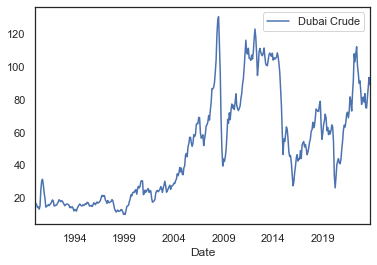

In [ ]:
dubai_crude_df.plot()